# Introduction

This notebook implements Differential Evolution with Novel Parameter Control (DE-NPC) proposed by Meng et al. (2020) [1]. 

Using DE-NPC and MNIST [2], an adversarial image is generated. The prediction of an RBF Network on the adversarial image and original image is displayed.

[1] Meng, Z., Chen, Y., & Li, X. (2020). Enhancing differential evolution with novel parametercontrol. IEEE Access,8, 51145–51167. \\
[2] LeCun, Y., Cortes, C., & Burges, C.  (2010). MNIST handwritten digit database.



# Libraries

In [1]:
%matplotlib inline
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot
from sklearn.metrics import accuracy_score
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from keras.utils import to_categorical
import tensorflow as tf
from keras.layers import Dense, Conv2D, Dropout, Flatten, MaxPooling2D, Input, Activation
from keras.models import Model
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_recall_fscore_support
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials
from scipy.stats import cauchy 
from scipy import stats
import time
import operator
import random
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.cluster import KMeans
from keras.models import load_model
from skimage.measure import compare_ssim as ssim
import pickle

#Set seeds
random.seed(0)
np.random.seed(0)

Using TensorFlow backend.
/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


# DE_NPC Class

In [0]:
#https://www.geeksforgeeks.org/python-peak-signal-to-noise-ratio-psnr/
from math import log10, sqrt 
import cv2 
def PSNR(original, compressed): 
    mse = np.mean((original - compressed) ** 2) 
    if(mse == 0):  # MSE is zero means no noise is present in the signal . 
                  # Therefore PSNR have no importance. 
        return 100
    max_pixel = 255.0
    psnr = 20 * log10(max_pixel / sqrt(mse)) 
    return psnr 

In [0]:
class DE_NPC:
  def __init__(self,param_dict):
    ###Load Params##
    self.img = param_dict["input"]
    self.imsize = param_dict["input_size"]
    self.imclass = param_dict["imclass"]
    self.mean = param_dict["mean"]
    self.std = param_dict["std"]
    self.R_min = param_dict["R_min"]
    self.R_max = param_dict["R_max"]
    self.nfe_max = param_dict["nfe_max"]
    self.PS_ini = param_dict["PS_ini"]
    self.PS_min = param_dict["PS_min"]
    self.K = param_dict["K"]
    self.rarc = param_dict["rarc"]
    self.p = param_dict["p"]
    self.model = param_dict["model"]

    ####Initialize Params####
    self.set_params()

  #Fitness function
  def fitness_func(self,individual):
    individual = individual.reshape(1,int(np.sqrt(self.imsize)),int(np.sqrt(self.imsize)),1)
    pred = self.model.predict(individual  / 255.0)
    pred = pred[0]
    po = pred[self.imclass]
    pred[self.imclass] = 0
    pd = np.max(pred)
    diff = pd-po
    return (0.5)*diff + (0.5)*ssim(individual.reshape(self.imsize),self.img.reshape(self.imsize))

  #Given the population and img(whihc is necessary to calculate the fitness function)
  #choose one individual whose fitness value is in top p percent.
  def get_top_p(self,PS,p):
    num_best = int(PS*p)
    fitness =  [(individual,self.fitness_func(individual)) for individual in self.population[0:PS]]
    fitness.sort(key=lambda x: x[1])
    fitness = fitness[-num_best:]
    return random.choice(fitness)[0]

  def execute(self, model):
    not_improving = 0
    nfe = 0
    PS = self.PS_ini
    A_ind = 0
    G = 1
    start = time.time()
    while nfe < self.nfe_max:
      #############################INITIALIZATION###################################
      #Sets of successfull f and cr values
      #with the corresponding weights
      s_f = [[] for i in range(self.K)]
      s_f_weights = [[] for i in range(self.K)]
      s_cr = [[] for i in range(self.K)]
      s_cr_weights = [[] for i in range(self.K)]
      #the selected k values for this iteration
      k_selections = np.zeros((self.K,PS))
      #how many times the specific k value was a success/failure
      k_success = np.zeros((self.K,1))
      k_failure = np.zeros((self.K,1))

      ####################ADJUST POPULATION AND A###################################
      #Adjustment done due to keep the individuals' values in range.
      #and to reduce the array sizes. However, even if the population size gets 
      #smaller than PS, since the loops are in range(PS), the individuals stored in 
      #the population vector in indices > PS will not be reached. 
      #Instead of picking discarded individuals randomly, we shuffle the population
      #and archive array. It should amount to picking random.
      if G > 2:
        #Adjust the individuals of the population; 
        for i in range(PS):
          self.population[i] = np.clip(self.population[i], self.R_min, self.R_max).reshape(self.imsize)
        #Adjust storage A; 
        for i in range(self.A_size):
          self.A[i] = np.clip(self.A[i], self.R_min, self.R_max).reshape(self.imsize)
        np.random.shuffle(self.A)
        np.random.shuffle(self.population)

      #############################SELECT K,F,CR'S##################################  
      #We select a k value for each individual in the population
      #with respect to the selection probabilities (p_k) of each k.
      custm = stats.rv_discrete(name='custm', values=(np.arange(self.K).reshape(self.K,1), self.p_k))
      k_selections = custm.rvs(size=PS)
      #Get f and cr values for each individual
      for i in range(PS):
        self.cr[i]  = np.random.normal(self.mu_cr[k_selections[i]], 0.1, 1)
        if self.cr[i] < 0:
          self.cr[i] = 0
        self.f[i] = cauchy.rvs(self.mu_f[k_selections[i]],0.1,1)
        while self.f[i] <= 0:
          self.f[i] = cauchy.rvs(self.mu_f[k_selections[i]],0.1,1)
        if self.f[i] > 1:
          self.f[i] = 1
      
      ####################GENERATE U,V AND CALCULATE FITNESS########################
      #Generate donor and trial (U and V) vectors
      #Calculate the fitness values
      for i in range(PS):
        X_p_best =  self.get_top_p(PS,self.p).reshape((self.imsize,1))
        #X_r_1 denotes a random vector selection from the current population
        X_r_1 = random.choice(self.population[:PS]).reshape((self.imsize,1))
        #X_hat_r_2 denotes a randomly selected solution from the union A and P
        X_hat_r_2 = random.choice(np.concatenate((self.population[:PS], self.A[:self.A_size]), axis=0)).reshape((self.imsize,1))
        #mutation, generate trial vector
        self.V[i] = (self.population[i].reshape((self.imsize,1)) + self.f[i]*(X_p_best - self.population[i].reshape((self.imsize,1)))
               + self.f[i]*(X_r_1 - X_hat_r_2)).reshape(self.imsize)
        #crossover, generate donor vector
        self.U[i] = self.population[i]
        for j in range(self.imsize):
          if random.uniform(0, 1) <= self.cr[i]:
            self.U[i][j] = self.V[i][j]
        self.fitness_ind[i] = self.fitness_func(self.population[i])
        self.fitness_U[i] = self.fitness_func(self.U[i])

      ################################INCREMENT nfe#################################
      #Increment nfe
      nfe += PS

      #####################DETERMINE UN/SUCCESSFULL#################################
      #Determine the successful and unsuccessful cr,f,k values.
      #Add unsuccessful individuals to the archive
      for i in range(PS):
        k = k_selections[i]
        if self.fitness_ind[i] <= self.fitness_U[i]:
          s_cr[k].append(self.cr[i])
          s_cr_weights[k].append(np.std(np.subtract(self.population[i],self.U[i])))
          s_f[k].append(self.f[i])
          s_f_weights[k].append(self.fitness_U[i]-self.fitness_ind[i])
          self.population[i] = self.U[i]
          k_success[k] += 1
        else:
          if A_ind >= self.A_size:
            A_ind = 0
          self.A[A_ind] = self.population[i]
          A_ind += 1
          k_failure[k] += 1

      ######################UPDATE MU_CR AND MU_F's#################################
      #update params (mixed with Jade-like update)
      for k in range(self.K):
        if len(s_cr[k]) != 0:
          s_cr_weights[k] = s_cr_weights[k]/np.sum(s_cr_weights[k])
          s_f_weights[k] = s_f_weights[k]/np.sum(s_f_weights[k])
          mean_cr = np.sum(np.multiply(np.square(s_cr[k]),s_cr_weights[k]))/np.sum(np.multiply(s_cr[k],s_cr_weights[k]))
          mean_f = np.sum(np.multiply(np.square(s_f[k]),s_f_weights[k]))/np.sum(np.multiply(s_f[k],s_f_weights[k]))  
          #update mu_cr
          if (np.max(s_cr[k]) > 0) and (self.mu_cr[k] != 0):
            self.mu_cr[k] = mean_cr
          #update mu_f
          self.mu_f[k] = mean_f

      ###########################UPDATE GROUP PROBS#################################
      #Update group probabilities
      for k in range(self.K):
        if k_success[k] != 0:
          k_success[k] = np.square(k_success[k])/(np.sum(k_success[k])*(k_success[k]+k_failure[k]))
        else:
          self.p_k[k] = 0.000000001
      self.p_k = self.p_k/np.sum(self.p_k)

      ###########################END ITERATION######################################
      #increment generation count
      G += 1
      #Get the best individual
      self.X_best = self.get_top_p(PS,1/PS)
      if G > 2: 
        dist = 1-ssim(self.X_best.reshape(self.imsize),self.img.reshape(self.imsize))
        individual = self.X_best.reshape(1,int(np.sqrt(self.imsize)),int(np.sqrt(self.imsize)),1)
        pred = self.model.predict(np.clip(individual, 0, 255)  / 255.0)
        pred = pred[0]
        pred = np.argmax(pred)
        if dist<0.001 and pred != self.imclass[0]:
          self.X_best_fitness = self.fitness_func(self.X_best)
          print("FOUND! " ,nfe, " : "  ,self.X_best_fitness,PS)
          break
        if np.abs(self.X_best_fitness-self.fitness_func(self.X_best)) < 0.01:
          not_improving += 1
          if not_improving > 30:
             self.X_best_fitness = self.fitness_func(self.X_best)
             print(nfe, " : "  ,self.X_best_fitness,PS)
             break
        else:
          not_improving = 0

      #Get the fitness of best individual
      self.X_best_fitness = self.fitness_func(self.X_best)
      #Give feedback
      print(nfe, " : "  ,self.X_best_fitness,PS)

      ######################ADJUST POPULATION SIZE##################################
      #adjust population size 
      #else part changed. there is something wrong with the formula on the paper.
      #since the ends of the two partial functions do not meet, when nfe > x the 
      #population increases. change is to fix this.
      if nfe <= self.x:
        PS = int(np.ceil((((self.y-self.PS_ini)/np.square(self.x-self.PS_ini))*np.square(nfe-self.PS_ini)) + self.PS_ini))
      else:
        initial_formula = int(np.floor((((self.y-self.PS_ini)/(self.x-self.PS_min))*(nfe-self.nfe_max)) + self.PS_min))
        if initial_formula < PS:
          PS = initial_formula
      #adjust archive size according to the new population
      self.A_size = int(self.rarc*PS)
      #Note: archive update moved within "Determine un/successful" as the computation
      #would be too redundant.  
    end = time.time()
    print("Time: ",end-start ," seconds")
    return end-start,nfe

  def change_input(self,img,imclass,imsize):
    self.img = img
    self.imsize = imsize
    self.imclass = imclass
    self.set_params()

  def set_params(self):
    #Calculate pivot for dynamic population change
    self.x = (1/3)*self.nfe_max
    self.y = (2/3)*self.PS_ini     
    #probability of belonging to a group
    self.p_k = np.ones((self.K,1))*(1/self.K)   
    #archive
    self.A_size = int(self.PS_ini*self.rarc)
    self.A = np.zeros((self.A_size,self.imsize))
    #scale factor
    self.f = np.ones((self.PS_ini,1)) 
    self.mu_f = np.ones((self.K,1)) *0.5
    #crossover probability
    self.cr = np.ones((self.PS_ini,1)) 
    self.mu_cr = np.ones((self.K,1)) *0.5
    #Initial population
    self.population = np.zeros((self.PS_ini,self.imsize))
    #Fitness functions
    self.fitness_ind = np.zeros((self.PS_ini,1))
    self.fitness_U = np.zeros((self.PS_ini,1))
    #donor and trial vectors
    self.V = np.zeros((self.PS_ini,self.imsize))
    self.U = np.zeros((self.PS_ini,self.imsize))
    for i in range(self.PS_ini):
      noisy_img = self.img + np.random.normal(self.mean, self.std, (self.imsize,1))
      self.population[i] = np.clip(noisy_img, 0, 255).reshape(self.imsize)
    self.X_best = None
    self.X_best_fitness = None

# Download Neural Network

In [0]:
model = load_model("CNN_CIFAR10_net3.h5")

In [5]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_7 (Conv2D)            (None, 32, 32, 32)        320       
_________________________________________________________________
activation_1 (Activation)    (None, 32, 32, 32)        0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 32, 32, 32)        128       
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 32, 32, 32)        9248      
_________________________________________________________________
activation_2 (Activation)    (None, 32, 32, 32)        0         
_________________________________________________________________
batch_normalization_2 (Batch (None, 32, 32, 32)        128       
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 16, 16, 32)       

# Prepare Data

In [6]:
(X_train, y_train), (X_test, y_test) = tf.keras.datasets.cifar10.load_data()

170500096/170498071 [==============================] - 2s 0us/step


In [7]:
X_sc = X_train / 255.0
X_test_sc = X_test / 255.0
y_cat = to_categorical(y_train)

def grayscale(data, dtype='float32'):
    # luma coding weighted average in video systems
    r, g, b = np.asarray(.3, dtype=dtype), np.asarray(.59, dtype=dtype), np.asarray(.11, dtype=dtype)
    rst = r * data[:, :, :, 0] + g * data[:, :, :, 1] + b * data[:, :, :, 2]
    # add channel dimension
    rst = np.expand_dims(rst, axis=3)
    return rst

X_sc = grayscale(X_sc)
X_test_sc = grayscale(X_test_sc)
X_train = grayscale(X_train)
X_test = grayscale(X_test)

y_pred_test = model.predict(np.expand_dims(X_test_sc.reshape(X_test_sc.shape[0],32,32),axis=3))
y_pred_train = model.predict(np.expand_dims(X_sc.reshape(X_sc.shape[0],32,32),axis=3))
print("Training accuracy: ",accuracy_score(y_train,np.argmax(y_pred_train,axis=1)))
print("Test accuracy: ",accuracy_score(y_test,np.argmax(y_pred_test,axis=1)))

Training accuracy:  0.95842
Test accuracy:  0.8245


In [0]:
def sample_test_set(percentage,X_test,X_test_scaled,y_test,imsize,channels,num_clusters, num_classes,num_samples):
  original = []
  adversarial = []
  original_y = []
  adversarial_y = []
  for sample_class in range(num_classes):
    labels = y_test[(y_test==sample_class).reshape(num_samples)]
    samples_orig = X_test[(y_test==sample_class).reshape(num_samples)]
    samples = X_test_scaled[(y_test==sample_class).reshape(num_samples)]
    samples = samples.reshape((samples.shape[0],imsize*imsize*channels))
    kmeans = KMeans(n_clusters=num_clusters, random_state=0).fit_predict(samples)
    for cluster in range(num_clusters):
      subsamples = np.where(kmeans==cluster)[0]
      ori, adv = train_test_split(subsamples,random_state=0, test_size = percentage ,shuffle=True)
      original.extend(samples_orig[ori])
      original_y.extend(labels[ori])
      adversarial.extend(samples_orig[adv])
      adversarial_y.extend(labels[adv])
  return np.array(original), np.array(adversarial), np.array(original_y), np.array(adversarial_y)

In [0]:
discard,subsample, discard_y, subsample_y = sample_test_set(0.1,X_test,X_test_sc,y_test,32,1,10,10,10000)

In [10]:
subsample.shape

(1047, 32, 32, 1)

In [11]:
subsample_y.shape

(1047, 1)

In [0]:
subsample_sc = subsample / 255.0
y_pred_subsample = model.predict(np.expand_dims(subsample_sc.reshape(subsample_sc.shape[0],32,32),axis=3))

In [13]:
print("Accuracy on subsample: ", accuracy_score(subsample_y,np.argmax(y_pred_subsample,axis=1)))

Accuracy on subsample:  0.8242597898758357


In [0]:
original,adversarial, original_y, adversarial_y = sample_test_set(0.1,subsample,subsample_sc,subsample_y,32,1,6,10,1047)

In [15]:
original_sc = original / 255.0
y_pred_original = model.predict(np.expand_dims(original_sc.reshape(original_sc.shape[0],32,32),axis=3))
print("Accuracy on original: ", accuracy_score(original_y,np.argmax(y_pred_original,axis=1)))

Accuracy on original:  0.824945295404814


In [16]:
adversarial_sc = adversarial / 255.0
y_pred_adversarial = model.predict(np.expand_dims(adversarial_sc.reshape(adversarial_sc.shape[0],32,32),axis=3))
print("Accuracy on adversarial: ", accuracy_score(adversarial_y,np.argmax(y_pred_adversarial,axis=1)))

Accuracy on adversarial:  0.8195488721804511


In [17]:
original.shape

(914, 32, 32, 1)

In [18]:
adversarial.shape

(133, 32, 32, 1)

In [19]:
adversarial_y.shape

(133, 1)

# Evolve

In [0]:
param_dict = {
    "model" : model,
    #Image to be evolved
    "input" : adversarial[0].reshape((32*32,1)),
    "input_size" : 32*32,
    "imclass" : adversarial_y[0],
    #Mean and std for Gaussian noise
    #good results with 10-10
    "mean" : 0, #50(5)   #150 (1)
    "std" : 10, #50 (5) #200 (1) (it was 100)
    #Range
    "R_min" : 0.0,
    "R_max" : 255.0,
    #Maximum number of function evaluations
    "nfe_max" : 10000,#4000 #5000(6) #50000(3)  #10000 (2)
    #Initial and minimum population size
    "PS_ini" : 25, #100 #200(4)
    "PS_min" : 4,
    #Number of groups
    "K" : 7,
    #ratio of the external archive size to the whole population PS
    "rarc" : 1.6,
    #percentage p when we select an individual among top p fits
    "p" : 0.11
}

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:31: UserWarning: DEPRECATED: skimage.measure.compare_ssim has been moved to skimage.metrics.structural_similarity. It will be removed from skimage.measure in version 0.18.
/usr/local/lib/python3.6/dist-packages/skimage/measure/_structural_similarity.py:17: UserWarning: Inputs have mismatched dtype.  Setting data_range based on im1.dtype.
  **kwargs)
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:143: RuntimeWarning: invalid value encountered in true_divide
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:144: RuntimeWarning: invalid value encountered in true_divide


25  :  [0.7161915] 25


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:168: UserWarning: DEPRECATED: skimage.measure.compare_ssim has been moved to skimage.metrics.structural_similarity. It will be removed from skimage.measure in version 0.18.


50  :  [0.7161915] 25
75  :  [0.7161915] 25
100  :  [0.7161915] 25
125  :  [0.7161915] 25
150  :  [0.7161915] 25
175  :  [0.7161915] 25
200  :  [0.7161915] 25
225  :  [0.7161915] 25
250  :  [0.7161915] 25
275  :  [0.7161915] 25
300  :  [0.7161915] 25
325  :  [0.7161915] 25
350  :  [0.7161915] 25
375  :  [0.7161915] 25
400  :  [0.7161915] 25
425  :  [0.7161915] 25
450  :  [0.7161915] 25
475  :  [0.7161915] 25
500  :  [0.7161915] 25
525  :  [0.7161915] 25
550  :  [0.7161915] 25
575  :  [0.7161915] 25
600  :  [0.7161915] 25
625  :  [0.7161915] 25
650  :  [0.7161915] 25
675  :  [0.7161915] 25
700  :  [0.7161915] 25
725  :  [0.7161915] 25
750  :  [0.7161915] 25
775  :  [0.7161915] 25
800  :  [0.7161915] 25
Time:  107.74902629852295  seconds
Original class:  0
Prediction for normal image:  [0]
Prediction for adversarial image:  [2]


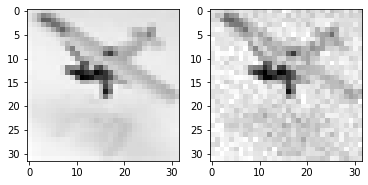

25  :  [0.82461154] 25
50  :  [0.82461154] 25
75  :  [0.82461154] 25
100  :  [0.82645607] 25
125  :  [0.82645607] 25
150  :  [0.83128047] 25
175  :  [0.83128047] 25
200  :  [0.83128047] 25
225  :  [0.8430673] 25
250  :  [0.84479356] 25
275  :  [0.84479356] 25
300  :  [0.84479356] 25
325  :  [0.84479356] 25
350  :  [0.85821015] 25
375  :  [0.85821015] 25
400  :  [0.85821015] 25
425  :  [0.85821015] 25
450  :  [0.8667487] 25
475  :  [0.8673922] 25
500  :  [0.87823427] 25
525  :  [0.87823427] 25
550  :  [0.87823427] 25
575  :  [0.88401484] 25
600  :  [0.88401484] 25
625  :  [0.88401484] 25
650  :  [0.88656074] 25
675  :  [0.88656074] 25
700  :  [0.8882946] 25
725  :  [0.89012814] 25
750  :  [0.89012814] 25
775  :  [0.89012814] 25
800  :  [0.89036405] 25
825  :  [0.8904258] 25
850  :  [0.89074224] 25
875  :  [0.8916873] 25
900  :  [0.8934083] 25
925  :  [0.89423287] 25
950  :  [0.89528424] 25
975  :  [0.8953223] 25
1000  :  [0.8953223] 25
1025  :  [0.8953223] 25
1050  :  [0.89712757] 25
10

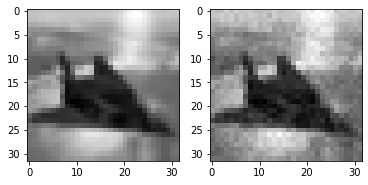

25  :  [0.7570381] 25
50  :  [0.765944] 25
75  :  [0.765944] 25
100  :  [0.765944] 25
125  :  [0.77014565] 25
150  :  [0.79073703] 25
175  :  [0.79073703] 25
200  :  [0.79073703] 25
225  :  [0.79073703] 25
250  :  [0.79073703] 25
275  :  [0.79073703] 25
300  :  [0.79073703] 25
325  :  [0.793146] 25
350  :  [0.795778] 25
375  :  [0.8085222] 25
400  :  [0.8088846] 25
425  :  [0.8088846] 25
450  :  [0.82191825] 25
475  :  [0.8225719] 25
500  :  [0.8376369] 25
525  :  [0.8376369] 25
550  :  [0.84684694] 25
575  :  [0.84684694] 25
600  :  [0.84684694] 25
625  :  [0.84684694] 25
650  :  [0.84684694] 25
675  :  [0.849277] 25
700  :  [0.8533406] 25
725  :  [0.8533406] 25
750  :  [0.85338235] 25
775  :  [0.85338235] 25
800  :  [0.85338235] 25
825  :  [0.8534734] 25
850  :  [0.85375345] 25
875  :  [0.85550284] 25
900  :  [0.8557384] 25
925  :  [0.85750955] 25
950  :  [0.85750955] 25
975  :  [0.8591533] 25
1000  :  [0.8591533] 25
1025  :  [0.85918224] 25
1050  :  [0.86096674] 25
1075  :  [0.86096

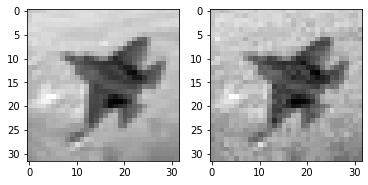

25  :  [0.74954176] 25
50  :  [0.74954176] 25
75  :  [0.7516061] 25
100  :  [0.7516863] 25
125  :  [0.7629197] 25
150  :  [0.7629197] 25
175  :  [0.7629197] 25
200  :  [0.7736992] 25
225  :  [0.77343357] 25
250  :  [0.7906605] 25
275  :  [0.7906605] 25
300  :  [0.7906605] 25
325  :  [0.7906605] 25
350  :  [0.7906605] 25
375  :  [0.7906605] 25
400  :  [0.7906605] 25
425  :  [0.7906605] 25
450  :  [0.8027346] 25
475  :  [0.8080261] 25
500  :  [0.8080261] 25
525  :  [0.8080261] 25
550  :  [0.8080261] 25
575  :  [0.8080261] 25
600  :  [0.8126115] 25
625  :  [0.8126115] 25
650  :  [0.8126762] 25
675  :  [0.81386757] 25
700  :  [0.8172239] 25
725  :  [0.8172239] 25
750  :  [0.8172239] 25
775  :  [0.8172239] 25
800  :  [0.8172239] 25
825  :  [0.81750375] 25
850  :  [0.81830907] 25
875  :  [0.81857276] 25
900  :  [0.81944203] 25
925  :  [0.82005596] 25
950  :  [0.82005596] 25
975  :  [0.8202914] 25
1000  :  [0.8205693] 25
1025  :  [0.82096756] 25
1050  :  [0.8213477] 25
1075  :  [0.8216448] 25

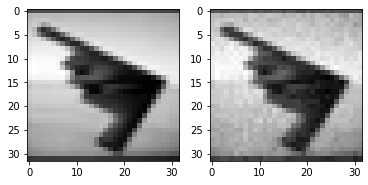

25  :  [0.7575854] 25
50  :  [0.7575854] 25
75  :  [0.75754714] 25
100  :  [0.7576402] 25
125  :  [0.7672756] 25
150  :  [0.7672756] 25
175  :  [0.7672756] 25
200  :  [0.7672756] 25
225  :  [0.7672756] 25
250  :  [0.7672756] 25
275  :  [0.7675247] 25
300  :  [0.7678788] 25
325  :  [0.77102613] 25
350  :  [0.77189684] 25
375  :  [0.7723461] 25
400  :  [0.773552] 25
425  :  [0.7737465] 25
450  :  [0.7768142] 25
475  :  [0.7768142] 25
500  :  [0.7769315] 25
525  :  [0.7780719] 25
550  :  [0.7787665] 25
575  :  [0.7802193] 25
600  :  [0.7802193] 25
625  :  [0.78069085] 25
650  :  [0.7822217] 25
675  :  [0.7837187] 25
700  :  [0.7837187] 25
725  :  [0.7837187] 25
750  :  [0.7848053] 25
775  :  [0.78600466] 25
800  :  [0.78600466] 25
Time:  107.5779116153717  seconds
Original class:  0
Prediction for normal image:  [0]
Prediction for adversarial image:  [2]


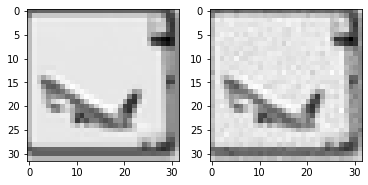

25  :  [0.5961167] 25
50  :  [0.5961167] 25
75  :  [0.5961167] 25
100  :  [0.61885166] 25
125  :  [0.6240177] 25
150  :  [0.6240177] 25
175  :  [0.6240177] 25
200  :  [0.6250697] 25
225  :  [0.6250697] 25
250  :  [0.6250697] 25
275  :  [0.6290611] 25
300  :  [0.62921894] 25
325  :  [0.62921894] 25
350  :  [0.62921894] 25
375  :  [0.62921894] 25
400  :  [0.62921894] 25
425  :  [0.62921894] 25
450  :  [0.62921894] 25
475  :  [0.62921894] 25
500  :  [0.62921894] 25
525  :  [0.62921894] 25
550  :  [0.63059086] 25
575  :  [0.6337787] 25
600  :  [0.63579637] 25
625  :  [0.63579637] 25
650  :  [0.6412724] 25
675  :  [0.6421516] 25
700  :  [0.6421516] 25
725  :  [0.6446868] 25
750  :  [0.6446868] 25
775  :  [0.6508159] 25
800  :  [0.6508159] 25
825  :  [0.6518115] 25
850  :  [0.6529059] 25
875  :  [0.6581725] 25
Time:  116.69379234313965  seconds
Original class:  0
Prediction for normal image:  [0]
Prediction for adversarial image:  [2]


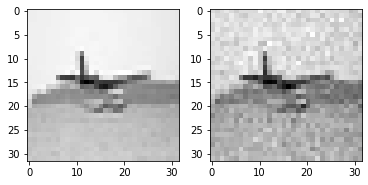

25  :  [0.5746757] 25
50  :  [0.72371584] 25
75  :  [0.7075006] 25
100  :  [0.7075006] 25
125  :  [0.7075006] 25
150  :  [0.7075006] 25
175  :  [0.7100699] 25
200  :  [0.7075006] 25
225  :  [0.7075006] 25
250  :  [0.7075006] 25
275  :  [0.73239326] 25
300  :  [0.7317992] 25
325  :  [0.7317992] 25
350  :  [0.7317992] 25
375  :  [0.7317992] 25
400  :  [0.7317992] 25
425  :  [0.7317992] 25
450  :  [0.7317992] 25
475  :  [0.7317992] 25
500  :  [0.7317992] 25
525  :  [0.7469] 25
550  :  [0.746809] 25
575  :  [0.7472345] 25
600  :  [0.7477094] 25
625  :  [0.74771017] 25
650  :  [0.7482456] 25
675  :  [0.7483138] 25
700  :  [0.7492018] 25
725  :  [0.7570222] 25
750  :  [0.75709176] 25
775  :  [0.75709176] 25
800  :  [0.76477706] 25
825  :  [0.76477706] 25
850  :  [0.765339] 25
875  :  [0.76534116] 25
900  :  [0.76936734] 25
925  :  [0.76936734] 25
950  :  [0.7714952] 25
975  :  [0.7714952] 25
1000  :  [0.77170956] 25
1025  :  [0.77170956] 25
1050  :  [0.77170956] 25
1075  :  [0.77196145] 25
1

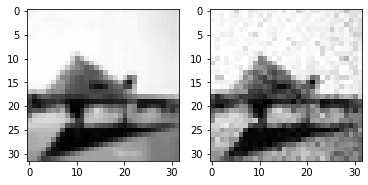

25  :  [0.7270551] 25
50  :  [0.7270551] 25
75  :  [0.7270551] 25
100  :  [0.739461] 25
125  :  [0.7588463] 25
150  :  [0.7590909] 25
175  :  [0.7590909] 25
200  :  [0.7590909] 25
225  :  [0.7590909] 25
250  :  [0.7590909] 25
275  :  [0.7590909] 25
300  :  [0.7590909] 25
325  :  [0.7590909] 25
350  :  [0.76230705] 25
375  :  [0.76230705] 25
400  :  [0.7713351] 25
425  :  [0.7713351] 25
450  :  [0.7713351] 25
475  :  [0.7713351] 25
500  :  [0.7713351] 25
525  :  [0.77393496] 25
550  :  [0.7785475] 25
575  :  [0.7785475] 25
600  :  [0.7828928] 25
625  :  [0.7828928] 25
650  :  [0.7828928] 25
675  :  [0.7828928] 25
700  :  [0.79005295] 25
725  :  [0.79005295] 25
750  :  [0.79005295] 25
775  :  [0.79904896] 25
800  :  [0.79855907] 25
825  :  [0.79855907] 25
850  :  [0.79855907] 25
875  :  [0.79855907] 25
900  :  [0.7988591] 25
Time:  122.69110202789307  seconds
Original class:  0
Prediction for normal image:  [0]
Prediction for adversarial image:  [2]


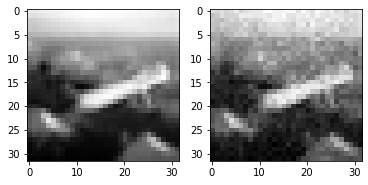

25  :  [0.6100009] 25
50  :  [0.6128266] 25
75  :  [0.67023957] 25
100  :  [0.71188915] 25
125  :  [0.70909727] 25
150  :  [0.71341145] 25
175  :  [0.709414] 25
200  :  [0.709414] 25
225  :  [0.709414] 25
250  :  [0.709414] 25
275  :  [0.709414] 25
300  :  [0.72464526] 25
325  :  [0.72382474] 25
350  :  [0.74202013] 25
375  :  [0.7463709] 25
400  :  [0.74649024] 25
425  :  [0.7477757] 25
450  :  [0.7577363] 25
475  :  [0.7577363] 25
500  :  [0.7577363] 25
525  :  [0.7693427] 25
550  :  [0.7697738] 25
575  :  [0.7713287] 25
600  :  [0.77190864] 25
625  :  [0.77190864] 25
650  :  [0.7738166] 25
675  :  [0.7767517] 25
700  :  [0.7836968] 25
725  :  [0.7836968] 25
750  :  [0.7848195] 25
775  :  [0.7879777] 25
800  :  [0.7879777] 25
825  :  [0.78832096] 25
850  :  [0.78930575] 25
875  :  [0.7904959] 25
900  :  [0.79145885] 25
925  :  [0.79145885] 25
950  :  [0.79145885] 25
975  :  [0.7924901] 25
1000  :  [0.79264987] 25
1025  :  [0.7927469] 25
1050  :  [0.7927469] 25
1075  :  [0.79311776] 2

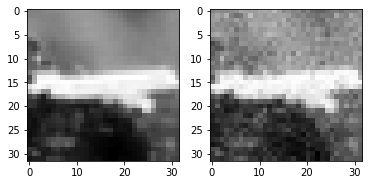

25  :  [0.7489253] 25
50  :  [0.74974763] 25
75  :  [0.7585969] 25
100  :  [0.75959706] 25
125  :  [0.78063023] 25
150  :  [0.78731394] 25
175  :  [0.7880644] 25
200  :  [0.7880644] 25
225  :  [0.795521] 25
250  :  [0.798568] 25
275  :  [0.80323756] 25
300  :  [0.81821275] 25
325  :  [0.81821275] 25
350  :  [0.829229] 25
375  :  [0.8342638] 25
400  :  [0.8342638] 25
425  :  [0.8342638] 25
450  :  [0.8342638] 25
475  :  [0.8384962] 25
500  :  [0.84671783] 25
525  :  [0.84671783] 25
550  :  [0.84671783] 25
575  :  [0.84707797] 25
600  :  [0.84707797] 25
625  :  [0.8511549] 25
650  :  [0.8559146] 25
675  :  [0.8559146] 25
700  :  [0.8559146] 25
725  :  [0.8559146] 25
750  :  [0.8563764] 25
775  :  [0.8563764] 25
800  :  [0.8564035] 25
825  :  [0.8578725] 25
850  :  [0.8578725] 25
875  :  [0.85822517] 25
900  :  [0.85874724] 25
925  :  [0.86004174] 25
950  :  [0.86004174] 25
975  :  [0.86004174] 25
1000  :  [0.86004174] 25
1025  :  [0.8605607] 25
1050  :  [0.8617025] 25
1075  :  [0.8617025

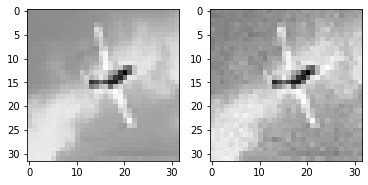

25  :  [0.69520104] 25
50  :  [0.71766186] 25
75  :  [0.7292695] 25
100  :  [0.73801863] 25
125  :  [0.7440516] 25
150  :  [0.74409974] 25
175  :  [0.74663866] 25
200  :  [0.7485781] 25
225  :  [0.7485781] 25
250  :  [0.74984956] 25
275  :  [0.75368357] 25
300  :  [0.7578708] 25
325  :  [0.76351345] 25
350  :  [0.76351345] 25
375  :  [0.76351345] 25
400  :  [0.7659353] 25
425  :  [0.7659353] 25
450  :  [0.7659353] 25
475  :  [0.7659353] 25
500  :  [0.7659353] 25
525  :  [0.769673] 25
550  :  [0.769673] 25
575  :  [0.7711669] 25
600  :  [0.77672434] 25
625  :  [0.77672434] 25
650  :  [0.77805436] 25
675  :  [0.7831379] 25
700  :  [0.7831379] 25
725  :  [0.7831403] 25
750  :  [0.78624344] 25
775  :  [0.7877294] 25
800  :  [0.7877294] 25
825  :  [0.7877294] 25
850  :  [0.7877294] 25
Time:  113.47727966308594  seconds
Original class:  0
Prediction for normal image:  [0]
Prediction for adversarial image:  [2]


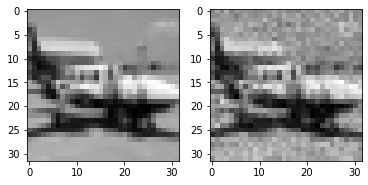

25  :  [0.80522215] 25
50  :  [0.82249117] 25
75  :  [0.8373568] 25
100  :  [0.85863876] 25
125  :  [0.85863876] 25
150  :  [0.85863876] 25
175  :  [0.85863876] 25
200  :  [0.8816193] 25
225  :  [0.8857955] 25
250  :  [0.8857955] 25
275  :  [0.8876784] 25
300  :  [0.8876784] 25
325  :  [0.893213] 25
350  :  [0.9025327] 25
375  :  [0.9025327] 25
400  :  [0.9025327] 25
425  :  [0.9079511] 25
450  :  [0.9099252] 25
475  :  [0.91353214] 25
500  :  [0.91353214] 25
525  :  [0.91417265] 25
550  :  [0.9171977] 25
575  :  [0.9197009] 25
600  :  [0.9197009] 25
625  :  [0.9197009] 25
650  :  [0.9198704] 25
675  :  [0.9213332] 25
700  :  [0.921597] 25
725  :  [0.9229429] 25
750  :  [0.9229429] 25
775  :  [0.9233377] 25
800  :  [0.92344266] 25
825  :  [0.924327] 25
850  :  [0.9250634] 25
875  :  [0.92507327] 25
900  :  [0.92507327] 25
925  :  [0.92573047] 25
950  :  [0.9263861] 25
975  :  [0.9276488] 25
Time:  134.10958409309387  seconds
Original class:  0
Prediction for normal image:  [2]
Predicti

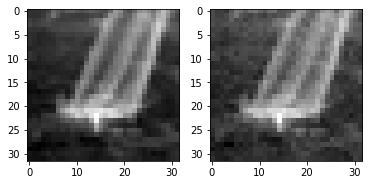

25  :  [0.7958628] 25
50  :  [0.80385566] 25
75  :  [0.80561066] 25
100  :  [0.80561066] 25
125  :  [0.8087981] 25
150  :  [0.810124] 25
175  :  [0.8207605] 25
200  :  [0.8208101] 25
225  :  [0.83895767] 25
250  :  [0.83895767] 25
275  :  [0.83895767] 25
300  :  [0.83895767] 25
325  :  [0.8391281] 25
350  :  [0.84191597] 25
375  :  [0.84191597] 25
400  :  [0.848011] 25
425  :  [0.85167134] 25
450  :  [0.85397834] 25
475  :  [0.85397834] 25
500  :  [0.85397834] 25
525  :  [0.8592957] 25
550  :  [0.8592957] 25
575  :  [0.8592957] 25
600  :  [0.8611542] 25
625  :  [0.8615183] 25
650  :  [0.86207885] 25
675  :  [0.86207885] 25
700  :  [0.8625828] 25
725  :  [0.8625828] 25
750  :  [0.8625828] 25
775  :  [0.8628746] 25
800  :  [0.8628746] 25
825  :  [0.86354387] 25
850  :  [0.8639908] 25
875  :  [0.8639908] 25
900  :  [0.8639908] 25
925  :  [0.8639908] 25
950  :  [0.8641037] 25
975  :  [0.8642421] 25
1000  :  [0.86442095] 25
Time:  133.80201506614685  seconds
Original class:  0
Prediction fo

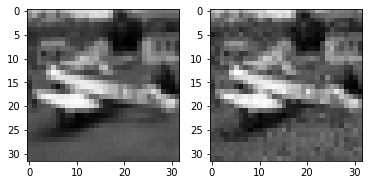

25  :  [0.71765614] 25
50  :  [0.71765614] 25
75  :  [0.710551] 25
100  :  [0.710551] 25
125  :  [0.710551] 25
150  :  [0.7287707] 25
175  :  [0.7273484] 25
200  :  [0.7277375] 25
225  :  [0.7277219] 25
250  :  [0.7277219] 25
275  :  [0.7277219] 25
300  :  [0.7277219] 25
325  :  [0.72855115] 25
350  :  [0.72829515] 25
375  :  [0.72829515] 25
400  :  [0.72829515] 25
425  :  [0.72829515] 25
450  :  [0.72829515] 25
475  :  [0.728351] 25
500  :  [0.7286311] 25
525  :  [0.7286311] 25
550  :  [0.7286311] 25
575  :  [0.72908664] 25
600  :  [0.729819] 25
625  :  [0.7307724] 25
650  :  [0.7307724] 25
675  :  [0.7307724] 25
700  :  [0.7307724] 25
725  :  [0.7307724] 25
750  :  [0.7307724] 25
775  :  [0.7307724] 25
800  :  [0.7307724] 25
825  :  [0.73149645] 25
850  :  [0.73149645] 25
875  :  [0.73149645] 25
900  :  [0.73149645] 25
925  :  [0.73348117] 25
Time:  123.9417073726654  seconds
Original class:  1
Prediction for normal image:  [1]
Prediction for adversarial image:  [6]


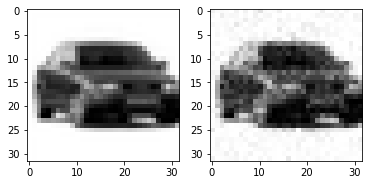

25  :  [0.8793809] 25
50  :  [0.8793809] 25
75  :  [0.8793809] 25
100  :  [0.87938833] 25
125  :  [0.8886173] 25
150  :  [0.8886173] 25
175  :  [0.8886173] 25
200  :  [0.8886173] 25
225  :  [0.8886173] 25
250  :  [0.8886173] 25
275  :  [0.8886173] 25
300  :  [0.8891878] 25
325  :  [0.8891878] 25
350  :  [0.88963884] 25
375  :  [0.8938022] 25
400  :  [0.8939451] 25
425  :  [0.89617014] 25
450  :  [0.898361] 25
475  :  [0.9025591] 25
500  :  [0.90252453] 25
525  :  [0.9055395] 25
550  :  [0.913043] 25
575  :  [0.913043] 25
600  :  [0.913043] 25
625  :  [0.913043] 25
650  :  [0.913043] 25
675  :  [0.913043] 25
700  :  [0.91503334] 25
725  :  [0.91897047] 25
750  :  [0.91897047] 25
775  :  [0.91940403] 25
800  :  [0.91940403] 25
Time:  106.92514061927795  seconds
Original class:  1
Prediction for normal image:  [1]
Prediction for adversarial image:  [2]


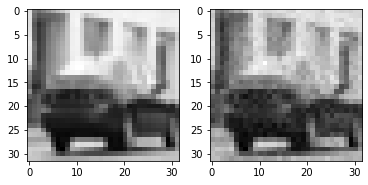

25  :  [0.66633326] 25
50  :  [0.70208776] 25
75  :  [0.7069096] 25
100  :  [0.70716834] 25
125  :  [0.70716834] 25
150  :  [0.71179855] 25
175  :  [0.7120032] 25
200  :  [0.7129104] 25
225  :  [0.71297145] 25
250  :  [0.71297145] 25
275  :  [0.71297145] 25
300  :  [0.71297145] 25
325  :  [0.7148877] 25
350  :  [0.7156848] 25
375  :  [0.72501004] 25
400  :  [0.72501004] 25
425  :  [0.73029387] 25
450  :  [0.73030186] 25
475  :  [0.7320215] 25
500  :  [0.7330035] 25
525  :  [0.736047] 25
550  :  [0.73658943] 25
575  :  [0.73844904] 25
600  :  [0.7410625] 25
625  :  [0.74626255] 25
650  :  [0.74626255] 25
675  :  [0.74626255] 25
700  :  [0.74626255] 25
725  :  [0.74626255] 25
750  :  [0.7469781] 25
775  :  [0.7469781] 25
800  :  [0.7479937] 25
825  :  [0.7479937] 25
Time:  110.1682198047638  seconds
Original class:  1
Prediction for normal image:  [1]
Prediction for adversarial image:  [6]


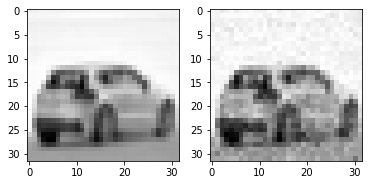

25  :  [0.8609197] 25
50  :  [0.8609197] 25
75  :  [0.8609197] 25
100  :  [0.8724007] 25
125  :  [0.8765739] 25
150  :  [0.87653404] 25
175  :  [0.87653404] 25
200  :  [0.87653404] 25
225  :  [0.87653404] 25
250  :  [0.87653404] 25
275  :  [0.88169336] 25
300  :  [0.8917487] 25
325  :  [0.89267373] 25
350  :  [0.89267373] 25
375  :  [0.89950824] 25
400  :  [0.9003399] 25
425  :  [0.90033895] 25
450  :  [0.9004077] 25
475  :  [0.9017977] 25
500  :  [0.90179783] 25
525  :  [0.90355325] 25
550  :  [0.90355325] 25
575  :  [0.90355325] 25
600  :  [0.9214269] 25
625  :  [0.9214269] 25
650  :  [0.9214269] 25
675  :  [0.9214269] 25
700  :  [0.9214269] 25
725  :  [0.9214269] 25
750  :  [0.93154] 25
775  :  [0.93154] 25
800  :  [0.93154] 25
825  :  [0.93154] 25
850  :  [0.9369516] 25
875  :  [0.9369516] 25
900  :  [0.9369516] 25
925  :  [0.9369516] 25
950  :  [0.93822205] 25
975  :  [0.93822205] 25
1000  :  [0.9382773] 25
1025  :  [0.9382773] 25
1050  :  [0.9387138] 25
1075  :  [0.9416893] 25
11

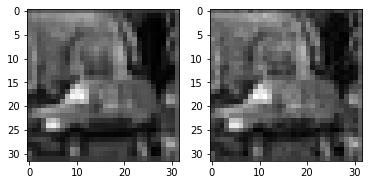

25  :  [0.8661274] 25
50  :  [0.8661274] 25
75  :  [0.8661274] 25
100  :  [0.8661274] 25
125  :  [0.8661274] 25
150  :  [0.8661274] 25
175  :  [0.8661274] 25
200  :  [0.89286137] 25
225  :  [0.89286137] 25
250  :  [0.89286137] 25
275  :  [0.89286137] 25
300  :  [0.89286137] 25
325  :  [0.89286137] 25
350  :  [0.8956963] 25
375  :  [0.8956963] 25
400  :  [0.8956963] 25
425  :  [0.8956963] 25
450  :  [0.8956963] 25
475  :  [0.89961743] 25
500  :  [0.89961743] 25
525  :  [0.9039011] 25
550  :  [0.90747964] 25
575  :  [0.90747964] 25
600  :  [0.9084252] 25
625  :  [0.9124287] 25
650  :  [0.91376984] 25
675  :  [0.91472405] 25
700  :  [0.91472405] 25
725  :  [0.91472405] 25
750  :  [0.91472405] 25
775  :  [0.91719556] 25
800  :  [0.91719556] 25
825  :  [0.9198344] 25
850  :  [0.9198344] 25
875  :  [0.9198344] 25
900  :  [0.9198344] 25
925  :  [0.92051184] 25
950  :  [0.9212431] 25
975  :  [0.9221582] 25
Time:  130.14350986480713  seconds
Original class:  1
Prediction for normal image:  [6]


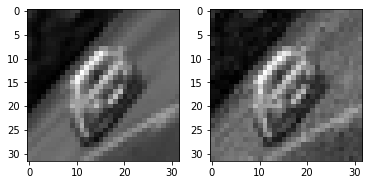

25  :  [0.77682793] 25
50  :  [0.77682793] 25
75  :  [0.77682793] 25
100  :  [0.77682793] 25
125  :  [0.77682793] 25
150  :  [0.77682793] 25
175  :  [0.77682793] 25
200  :  [0.77682793] 25
225  :  [0.78028524] 25
250  :  [0.78052795] 25
275  :  [0.78052795] 25
300  :  [0.78052795] 25
325  :  [0.7839551] 25
350  :  [0.796279] 25
375  :  [0.79619557] 25
400  :  [0.8037231] 25
425  :  [0.8038142] 25
450  :  [0.8089923] 25
475  :  [0.8089923] 25
500  :  [0.8092872] 25
525  :  [0.8092761] 25
550  :  [0.8092761] 25
575  :  [0.8092761] 25
600  :  [0.81159043] 25
625  :  [0.8183404] 25
650  :  [0.8183404] 25
675  :  [0.8183404] 25
700  :  [0.8183404] 25
725  :  [0.82108176] 25
750  :  [0.8210914] 25
775  :  [0.8210914] 25
800  :  [0.8210914] 25
825  :  [0.8336805] 25
850  :  [0.8336805] 25
875  :  [0.8336805] 25
900  :  [0.8336805] 25
925  :  [0.8336805] 25
950  :  [0.83475834] 25
975  :  [0.8417047] 25
1000  :  [0.8417047] 25
1025  :  [0.8417047] 25
1050  :  [0.8417047] 25
1075  :  [0.8433279

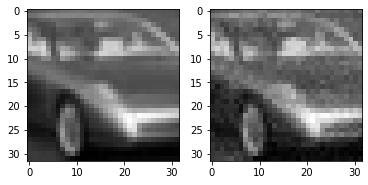

25  :  [0.6677964] 25
50  :  [0.6677964] 25
75  :  [0.70488703] 25
100  :  [0.7446307] 25
125  :  [0.74646986] 25
150  :  [0.74646986] 25
175  :  [0.8064841] 25
200  :  [0.8035415] 25
225  :  [0.8035415] 25
250  :  [0.8035415] 25
275  :  [0.8035415] 25
300  :  [0.8035415] 25
325  :  [0.8035415] 25
350  :  [0.8035415] 25
375  :  [0.8035415] 25
400  :  [0.81787205] 25
425  :  [0.8178727] 25
450  :  [0.8178727] 25
475  :  [0.8178727] 25
500  :  [0.8178727] 25
525  :  [0.8178727] 25
550  :  [0.8178727] 25
575  :  [0.8178727] 25
600  :  [0.8178727] 25
625  :  [0.8209472] 25
650  :  [0.82960856] 25
675  :  [0.8295737] 25
700  :  [0.8295737] 25
725  :  [0.8295737] 25
750  :  [0.8295737] 25
775  :  [0.8295737] 25
800  :  [0.8295737] 25
825  :  [0.8295737] 25
850  :  [0.8295737] 25
875  :  [0.8295737] 25
900  :  [0.8295737] 25
925  :  [0.8295737] 25
950  :  [0.8295737] 25
975  :  [0.8295737] 25
1000  :  [0.8295737] 25
1025  :  [0.8295737] 25
1050  :  [0.83183384] 25
1075  :  [0.83183384] 25
110

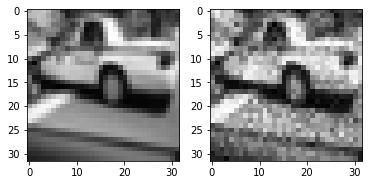

25  :  [0.77473414] 25
50  :  [0.77717566] 25
75  :  [0.77717805] 25
100  :  [0.785655] 25
125  :  [0.7848019] 25
150  :  [0.7848019] 25
175  :  [0.7848019] 25
200  :  [0.7848019] 25
225  :  [0.78943324] 25
250  :  [0.78943324] 25
275  :  [0.78943324] 25
300  :  [0.78943324] 25
325  :  [0.78943324] 25
350  :  [0.7922244] 25
375  :  [0.7922244] 25
400  :  [0.80115724] 25
425  :  [0.80115724] 25
450  :  [0.80115724] 25
475  :  [0.80115724] 25
500  :  [0.80980456] 25
525  :  [0.80980456] 25
550  :  [0.81173027] 25
575  :  [0.81173027] 25
600  :  [0.81173027] 25
625  :  [0.81173027] 25
650  :  [0.81173027] 25
675  :  [0.81173027] 25
700  :  [0.8163989] 25
725  :  [0.8198559] 25
750  :  [0.8198559] 25
775  :  [0.8198559] 25
800  :  [0.8198559] 25
Time:  106.02563500404358  seconds
Original class:  1
Prediction for normal image:  [1]
Prediction for adversarial image:  [2]


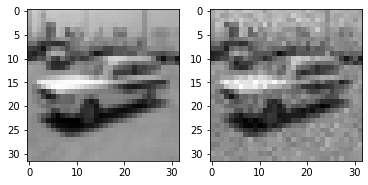

25  :  [0.85278714] 25
50  :  [0.8702457] 25
75  :  [0.871395] 25
100  :  [0.880998] 25
125  :  [0.88100517] 25
150  :  [0.8831109] 25
175  :  [0.882911] 25
200  :  [0.882911] 25
225  :  [0.88953686] 25
250  :  [0.8895774] 25
275  :  [0.89009666] 25
300  :  [0.89009666] 25
325  :  [0.8910047] 25
350  :  [0.89174587] 25
375  :  [0.8973985] 25
400  :  [0.8973985] 25
425  :  [0.8973985] 25
450  :  [0.8973985] 25
475  :  [0.8973985] 25
500  :  [0.90579414] 25
525  :  [0.90579414] 25
550  :  [0.90579414] 25
575  :  [0.90579414] 25
600  :  [0.90579414] 25
625  :  [0.90579414] 25
650  :  [0.90854704] 25
675  :  [0.90871763] 25
700  :  [0.90916306] 25
725  :  [0.915632] 25
750  :  [0.915625] 25
775  :  [0.915625] 25
800  :  [0.9158702] 25
825  :  [0.9158702] 25
Time:  109.4368953704834  seconds
Original class:  1
Prediction for normal image:  [1]
Prediction for adversarial image:  [6]


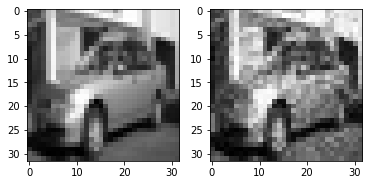

25  :  [0.82128793] 25
50  :  [0.82128793] 25
75  :  [0.82128793] 25
100  :  [0.8302394] 25
125  :  [0.8302394] 25
150  :  [0.8302394] 25
175  :  [0.8302394] 25
200  :  [0.8347571] 25
225  :  [0.8347571] 25
250  :  [0.8373755] 25
275  :  [0.84249514] 25
300  :  [0.843707] 25
325  :  [0.844663] 25
350  :  [0.8470957] 25
375  :  [0.84726274] 25
400  :  [0.8565415] 25
425  :  [0.8565415] 25
450  :  [0.8565415] 25
475  :  [0.86319613] 25
500  :  [0.86319613] 25
525  :  [0.86319613] 25
550  :  [0.86319613] 25
575  :  [0.86319613] 25
600  :  [0.8660068] 25
625  :  [0.8660068] 25
650  :  [0.8660068] 25
675  :  [0.8660068] 25
700  :  [0.86859065] 25
725  :  [0.8705845] 25
750  :  [0.8728432] 25
775  :  [0.87370765] 25
800  :  [0.8744114] 25
Time:  106.69369125366211  seconds
Original class:  1
Prediction for normal image:  [1]
Prediction for adversarial image:  [6]


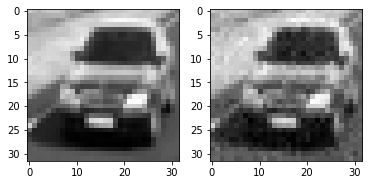

25  :  [0.82288724] 25
50  :  [0.82288724] 25
75  :  [0.82314515] 25
100  :  [0.82314515] 25
125  :  [0.82314515] 25
150  :  [0.82314515] 25
175  :  [0.83754873] 25
200  :  [0.83754873] 25
225  :  [0.83754873] 25
250  :  [0.8444293] 25
275  :  [0.8444293] 25
300  :  [0.8444293] 25
325  :  [0.8444293] 25
350  :  [0.8444293] 25
375  :  [0.8444293] 25
400  :  [0.8444293] 25
425  :  [0.8444293] 25
450  :  [0.8506611] 25
475  :  [0.8506611] 25
500  :  [0.8532163] 25
525  :  [0.856961] 25
550  :  [0.856961] 25
575  :  [0.856961] 25
600  :  [0.856961] 25
625  :  [0.85929596] 25
650  :  [0.85929596] 25
675  :  [0.8608501] 25
700  :  [0.8608501] 25
725  :  [0.8608501] 25
750  :  [0.86165947] 25
775  :  [0.86165947] 25
800  :  [0.8625894] 25
825  :  [0.8625894] 25
850  :  [0.8625894] 25
875  :  [0.8625894] 25
900  :  [0.8625894] 25
925  :  [0.86407065] 25
950  :  [0.8646451] 25
Time:  126.18693590164185  seconds
Original class:  1
Prediction for normal image:  [1]
Prediction for adversarial imag

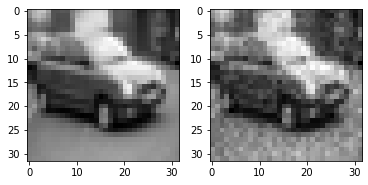

25  :  [0.61199754] 25
50  :  [0.70804983] 25
75  :  [0.67713964] 25
100  :  [0.6803611] 25
125  :  [0.7109474] 25
150  :  [0.71013075] 25
175  :  [0.71013075] 25
200  :  [0.71013075] 25
225  :  [0.7296263] 25
250  :  [0.7304553] 25
275  :  [0.7304553] 25
300  :  [0.7304553] 25
325  :  [0.7304553] 25
350  :  [0.7304553] 25
375  :  [0.754622] 25
400  :  [0.7572901] 25
425  :  [0.7572901] 25
450  :  [0.7572901] 25
475  :  [0.769376] 25
500  :  [0.769376] 25
525  :  [0.769376] 25
550  :  [0.7826507] 25
575  :  [0.7874105] 25
600  :  [0.7874105] 25
625  :  [0.7874105] 25
650  :  [0.7874105] 25
675  :  [0.7874105] 25
700  :  [0.7874105] 25
725  :  [0.7874105] 25
750  :  [0.7906858] 25
775  :  [0.7906858] 25
800  :  [0.7906858] 25
825  :  [0.7906858] 25
850  :  [0.79163337] 25
875  :  [0.79163337] 25
900  :  [0.7933967] 25
925  :  [0.7937706] 25
950  :  [0.7937706] 25
975  :  [0.7937706] 25
1000  :  [0.794009] 25
1025  :  [0.79482424] 25
1050  :  [0.79512525] 25
1075  :  [0.7952832] 25
1100 

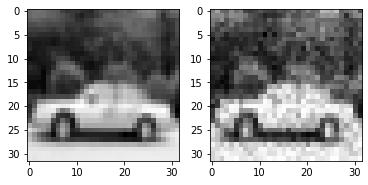

25  :  [0.6761538] 25
50  :  [0.7572277] 25
75  :  [0.74985063] 25
100  :  [0.74985063] 25
125  :  [0.74985063] 25
150  :  [0.74985063] 25
175  :  [0.74985063] 25
200  :  [0.74985063] 25
225  :  [0.74985063] 25
250  :  [0.74985063] 25
275  :  [0.74985063] 25
300  :  [0.74985063] 25
325  :  [0.74985063] 25
350  :  [0.75425065] 25
375  :  [0.75425065] 25
400  :  [0.75425065] 25
425  :  [0.75425065] 25
450  :  [0.75425065] 25
475  :  [0.75425065] 25
500  :  [0.75425065] 25
525  :  [0.7759882] 25
550  :  [0.7759882] 25
575  :  [0.78009367] 25
600  :  [0.78009367] 25
625  :  [0.7871051] 25
650  :  [0.7871051] 25
675  :  [0.7883094] 25
700  :  [0.7883094] 25
725  :  [0.79742014] 25
750  :  [0.79901016] 25
775  :  [0.80516666] 25
800  :  [0.80516666] 25
825  :  [0.80516666] 25
850  :  [0.8054106] 25
875  :  [0.80543613] 25
900  :  [0.81001127] 25
925  :  [0.8103696] 25
950  :  [0.8105757] 25
975  :  [0.81057394] 25
1000  :  [0.81235063] 25
1025  :  [0.8132913] 25
1050  :  [0.8136677] 25
1075 

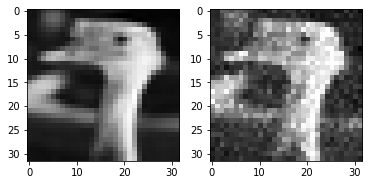

25  :  [0.83983755] 25
50  :  [0.83983755] 25
75  :  [0.83983755] 25
100  :  [0.84280777] 25
125  :  [0.84439874] 25
150  :  [0.84439874] 25
175  :  [0.84439874] 25
200  :  [0.8536813] 25
225  :  [0.8536813] 25
250  :  [0.85658646] 25
275  :  [0.8673732] 25
300  :  [0.8673732] 25
325  :  [0.87136006] 25
350  :  [0.8738398] 25
375  :  [0.8770176] 25
400  :  [0.87871337] 25
425  :  [0.87871337] 25
450  :  [0.8810549] 25
475  :  [0.8829605] 25
500  :  [0.8855821] 25
525  :  [0.8867898] 25
550  :  [0.8867898] 25
575  :  [0.88799906] 25
600  :  [0.890671] 25
625  :  [0.890671] 25
650  :  [0.89191055] 25
675  :  [0.89191055] 25
700  :  [0.8920131] 25
725  :  [0.89331377] 25
750  :  [0.89331377] 25
775  :  [0.89331377] 25
800  :  [0.8934288] 25
825  :  [0.8934288] 25
850  :  [0.8934288] 25
875  :  [0.8934288] 25
900  :  [0.89402175] 25
925  :  [0.89482087] 25
950  :  [0.89495337] 25
975  :  [0.89563596] 25
1000  :  [0.89616835] 25
1025  :  [0.89616835] 25
1050  :  [0.8961715] 25
Time:  140.02

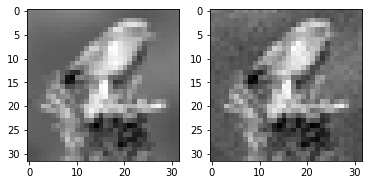

25  :  [0.88294804] 25
50  :  [0.8860272] 25
75  :  [0.9011461] 25
100  :  [0.91831917] 25
125  :  [0.92293084] 25
150  :  [0.93242157] 25
175  :  [0.9405552] 25
200  :  [0.9405552] 25
225  :  [0.9424115] 25
250  :  [0.9424115] 25
275  :  [0.94506025] 25
300  :  [0.94506025] 25
325  :  [0.94611955] 25
350  :  [0.9483512] 25
375  :  [0.9483512] 25
400  :  [0.95052683] 25
425  :  [0.95052683] 25
450  :  [0.95514846] 25
475  :  [0.95514846] 25
500  :  [0.9598695] 25
525  :  [0.9598695] 25
550  :  [0.9598695] 25
575  :  [0.9598695] 25
600  :  [0.9598695] 25
625  :  [0.96116877] 25
650  :  [0.9612523] 25
675  :  [0.9617299] 25
700  :  [0.96297216] 25
725  :  [0.9636779] 25
750  :  [0.9637407] 25
775  :  [0.9649961] 25
800  :  [0.9649961] 25
825  :  [0.9655657] 25
850  :  [0.9658356] 25
875  :  [0.9658356] 25
Time:  116.15392923355103  seconds
Original class:  2
Prediction for normal image:  [2]
Prediction for adversarial image:  [6]


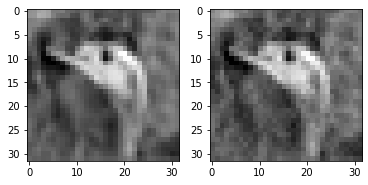

25  :  [0.7592533] 25
50  :  [0.7592533] 25
75  :  [0.7967591] 25
100  :  [0.7963714] 25
125  :  [0.7963714] 25
150  :  [0.7963714] 25
175  :  [0.7963714] 25
200  :  [0.7963714] 25
225  :  [0.7963714] 25
250  :  [0.7963714] 25
275  :  [0.7963714] 25
300  :  [0.7963714] 25
325  :  [0.7963714] 25
350  :  [0.7963714] 25
375  :  [0.7963714] 25
400  :  [0.7963714] 25
425  :  [0.7963714] 25
450  :  [0.7963714] 25
475  :  [0.7963714] 25
500  :  [0.7963714] 25
525  :  [0.7963714] 25
550  :  [0.7963714] 25
575  :  [0.7963714] 25
600  :  [0.7963714] 25
625  :  [0.7963714] 25
650  :  [0.7963714] 25
675  :  [0.7963714] 25
700  :  [0.7963714] 25
725  :  [0.7963714] 25
750  :  [0.7963714] 25
775  :  [0.7963714] 25
800  :  [0.7963714] 25
825  :  [0.7963714] 25
850  :  [0.7963714] 25
Time:  112.36371159553528  seconds
Original class:  2
Prediction for normal image:  [2]
Prediction for adversarial image:  [6]


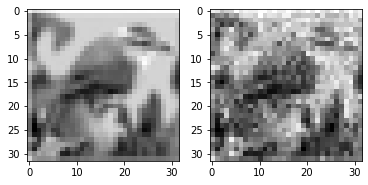

25  :  [0.55282426] 25
50  :  [0.55622244] 25
75  :  [0.57706434] 25
100  :  [0.57217324] 25
125  :  [0.6201538] 25
150  :  [0.6155277] 25
175  :  [0.6155277] 25
200  :  [0.6155277] 25
225  :  [0.6155277] 25
250  :  [0.6155277] 25
275  :  [0.6155277] 25
300  :  [0.62038463] 25
325  :  [0.62038463] 25
350  :  [0.62038463] 25
375  :  [0.62038463] 25
400  :  [0.62038463] 25
425  :  [0.62038463] 25
450  :  [0.62038463] 25
475  :  [0.62038463] 25
500  :  [0.6217398] 25
525  :  [0.6217398] 25
550  :  [0.6240405] 25
575  :  [0.6283464] 25
600  :  [0.63723123] 25
625  :  [0.640373] 25
650  :  [0.6448256] 25
675  :  [0.64600986] 25
700  :  [0.64600986] 25
725  :  [0.64888334] 25
750  :  [0.64901894] 25
775  :  [0.64999336] 25
800  :  [0.64999336] 25
825  :  [0.64999336] 25
850  :  [0.6512418] 25
875  :  [0.6512418] 25
900  :  [0.6530072] 25
Time:  122.72470021247864  seconds
Original class:  2
Prediction for normal image:  [2]
Prediction for adversarial image:  [4]


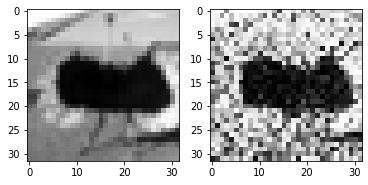

25  :  [0.5084194] 25
50  :  [0.5084194] 25
75  :  [0.5084194] 25
100  :  [0.5581666] 25
125  :  [0.5627427] 25
150  :  [0.5627427] 25
175  :  [0.5627427] 25
200  :  [0.5627427] 25
225  :  [0.5627427] 25
250  :  [0.5627427] 25
275  :  [0.5627427] 25
300  :  [0.5627427] 25
325  :  [0.5627427] 25
350  :  [0.5627427] 25
375  :  [0.5627427] 25
400  :  [0.5627427] 25
425  :  [0.5627427] 25
450  :  [0.5627427] 25
475  :  [0.5627427] 25
500  :  [0.5627427] 25
525  :  [0.5627427] 25
550  :  [0.5627427] 25
575  :  [0.5627427] 25
600  :  [0.5627427] 25
625  :  [0.5627427] 25
650  :  [0.5627427] 25
675  :  [0.5627427] 25
700  :  [0.5627427] 25
725  :  [0.5627427] 25
750  :  [0.5627427] 25
775  :  [0.5627427] 25
800  :  [0.5627427] 25
825  :  [0.5627427] 25
850  :  [0.5627427] 25
875  :  [0.5627427] 25
Time:  116.24107480049133  seconds
Original class:  2
Prediction for normal image:  [2]
Prediction for adversarial image:  [0]


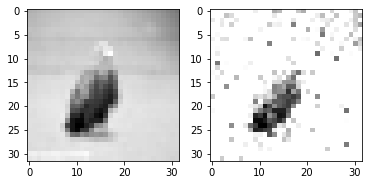

25  :  [0.59181064] 25
50  :  [0.6725862] 25
75  :  [0.66386676] 25
100  :  [0.66386676] 25
125  :  [0.66386676] 25
150  :  [0.66386676] 25
175  :  [0.66386676] 25
200  :  [0.66386676] 25
225  :  [0.66386676] 25
250  :  [0.66386676] 25
275  :  [0.66386676] 25
300  :  [0.6903627] 25
325  :  [0.6903627] 25
350  :  [0.7370467] 25
375  :  [0.7370467] 25
400  :  [0.7370467] 25
425  :  [0.7370467] 25
450  :  [0.7370467] 25
475  :  [0.7370467] 25
500  :  [0.7370467] 25
525  :  [0.7370467] 25
550  :  [0.7370467] 25
575  :  [0.7370467] 25
600  :  [0.7370467] 25
625  :  [0.7395151] 25
650  :  [0.7425857] 25
675  :  [0.7435522] 25
700  :  [0.7574477] 25
725  :  [0.773635] 25
750  :  [0.77751017] 25
775  :  [0.7910024] 25
800  :  [0.7910024] 25
825  :  [0.7910024] 25
850  :  [0.7933849] 25
875  :  [0.80547327] 25
900  :  [0.80547327] 25
925  :  [0.8093815] 25
950  :  [0.8103079] 25
975  :  [0.81120807] 25
1000  :  [0.81120807] 25
1025  :  [0.81120807] 25
1050  :  [0.8120301] 25
1075  :  [0.8120301

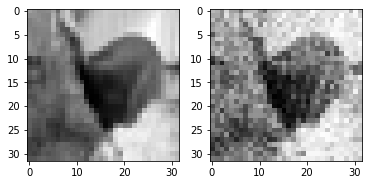

25  :  [0.74530673] 25
50  :  [0.74530673] 25
75  :  [0.74530673] 25
100  :  [0.74530673] 25
125  :  [0.8111285] 25
150  :  [0.8111285] 25
175  :  [0.8111285] 25
200  :  [0.8111285] 25
225  :  [0.8111285] 25
250  :  [0.8111285] 25
275  :  [0.8111285] 25
300  :  [0.8111285] 25
325  :  [0.8111285] 25
350  :  [0.8111285] 25
375  :  [0.8111285] 25
400  :  [0.8111285] 25
425  :  [0.8111285] 25
450  :  [0.8111285] 25
475  :  [0.8111285] 25
500  :  [0.8111285] 25
525  :  [0.81819654] 25
550  :  [0.81819654] 25
575  :  [0.81819654] 25
600  :  [0.81819654] 25
625  :  [0.81819654] 25
650  :  [0.81819654] 25
675  :  [0.81819654] 25
700  :  [0.81819654] 25
725  :  [0.81819654] 25
750  :  [0.81819654] 25
775  :  [0.81819654] 25
800  :  [0.81819654] 25
825  :  [0.81819654] 25
850  :  [0.81819654] 25
875  :  [0.81819654] 25
900  :  [0.81819654] 25
Time:  118.60606455802917  seconds
Original class:  2
Prediction for normal image:  [2]
Prediction for adversarial image:  [6]


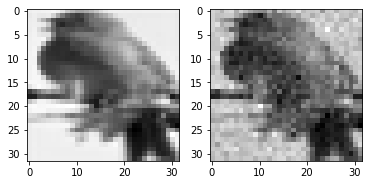

25  :  [0.6294486] 25
50  :  [0.6294486] 25
75  :  [0.6596127] 25
100  :  [0.6604717] 25
125  :  [0.6604717] 25
150  :  [0.7048864] 25
175  :  [0.7048864] 25
200  :  [0.7048864] 25
225  :  [0.7048864] 25
250  :  [0.7048864] 25
275  :  [0.7317942] 25
300  :  [0.7317942] 25
325  :  [0.7317942] 25
350  :  [0.7317942] 25
375  :  [0.735803] 25
400  :  [0.73759544] 25
425  :  [0.73759544] 25
450  :  [0.7390168] 25
475  :  [0.7390168] 25
500  :  [0.7438768] 25
525  :  [0.7438768] 25
550  :  [0.7479118] 25
575  :  [0.75094885] 25
600  :  [0.75094885] 25
625  :  [0.75094885] 25
650  :  [0.75474954] 25
675  :  [0.7548278] 25
700  :  [0.76154196] 25
725  :  [0.76380914] 25
750  :  [0.7727591] 25
775  :  [0.7727591] 25
800  :  [0.7727591] 25
825  :  [0.7759214] 25
850  :  [0.7759214] 25
875  :  [0.77886057] 25
900  :  [0.77886057] 25
925  :  [0.77886057] 25
950  :  [0.7792089] 25
975  :  [0.7792089] 25
1000  :  [0.7802209] 25
1025  :  [0.7811166] 25
1050  :  [0.781623] 25
Time:  142.50035095214844

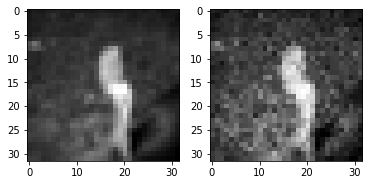

25  :  [0.9002426] 25
50  :  [0.9133272] 25
75  :  [0.91273284] 25
100  :  [0.91273284] 25
125  :  [0.91273284] 25
150  :  [0.91273284] 25
175  :  [0.91273284] 25
200  :  [0.91273284] 25
225  :  [0.91273284] 25
250  :  [0.91273284] 25
275  :  [0.91273284] 25
300  :  [0.91273284] 25
325  :  [0.91273284] 25
350  :  [0.91273284] 25
375  :  [0.91475695] 25
400  :  [0.9147581] 25
425  :  [0.9147581] 25
450  :  [0.9162899] 25
475  :  [0.9183889] 25
500  :  [0.92148036] 25
525  :  [0.92425513] 25
550  :  [0.92771494] 25
575  :  [0.9318522] 25
600  :  [0.9318522] 25
625  :  [0.9318522] 25
650  :  [0.9333935] 25
675  :  [0.9346652] 25
700  :  [0.9382542] 25
725  :  [0.93826175] 25
750  :  [0.9394984] 25
775  :  [0.94153357] 25
800  :  [0.9417143] 25
825  :  [0.9417143] 25
Time:  110.37354302406311  seconds
Original class:  2
Prediction for normal image:  [2]
Prediction for adversarial image:  [6]


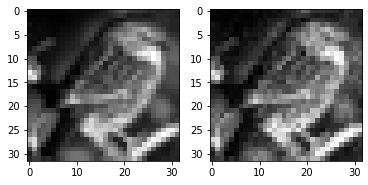

25  :  [0.6984742] 25
50  :  [0.7186905] 25
75  :  [0.7348826] 25
100  :  [0.78433454] 25
125  :  [0.78478396] 25
150  :  [0.78478396] 25
175  :  [0.78478396] 25
200  :  [0.78478396] 25
225  :  [0.7859751] 25
250  :  [0.7939694] 25
275  :  [0.81417185] 25
300  :  [0.81474125] 25
325  :  [0.81474125] 25
350  :  [0.8222362] 25
375  :  [0.8222362] 25
400  :  [0.8222362] 25
425  :  [0.8222362] 25
450  :  [0.8298896] 25
475  :  [0.8298896] 25
500  :  [0.83637464] 25
525  :  [0.83637464] 25
550  :  [0.840775] 25
575  :  [0.840775] 25
600  :  [0.840775] 25
625  :  [0.841398] 25
650  :  [0.8425056] 25
675  :  [0.8437444] 25
700  :  [0.84528625] 25
725  :  [0.8496357] 25
750  :  [0.84976023] 25
775  :  [0.8516816] 25
800  :  [0.8516816] 25
825  :  [0.8516816] 25
850  :  [0.8537271] 25
875  :  [0.85463375] 25
900  :  [0.85463375] 25
925  :  [0.8549189] 25
950  :  [0.8551853] 25
975  :  [0.85592115] 25
1000  :  [0.85647124] 25
1025  :  [0.85647124] 25
1050  :  [0.85735095] 25
Time:  140.978413581

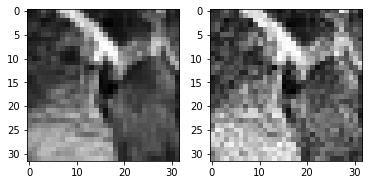

25  :  [0.46392193] 25
50  :  [0.46392193] 25
75  :  [0.34589618] 25
100  :  [0.29874587] 25
125  :  [0.4592123] 25
150  :  [0.55573326] 25
175  :  [0.56605107] 25
200  :  [0.5523765] 25
225  :  [0.57145095] 25
250  :  [0.57145095] 25
275  :  [0.57145095] 25
300  :  [0.57145095] 25
325  :  [0.57801384] 25
350  :  [0.5777769] 25
375  :  [0.5969894] 25
400  :  [0.59784293] 25
425  :  [0.59784293] 25
450  :  [0.59784293] 25
475  :  [0.59784293] 25
500  :  [0.59784293] 25
525  :  [0.59784293] 25
550  :  [0.59784293] 25
575  :  [0.59784293] 25
600  :  [0.59784293] 25
625  :  [0.59784293] 25
650  :  [0.5980007] 25
675  :  [0.59933525] 25
700  :  [0.59933525] 25
725  :  [0.6001817] 25
750  :  [0.60263276] 25
775  :  [0.6084301] 25
800  :  [0.60831153] 25
825  :  [0.6104629] 25
850  :  [0.6104629] 25
875  :  [0.6104629] 25
900  :  [0.6132358] 25
925  :  [0.61330235] 25
950  :  [0.6150936] 25
975  :  [0.615098] 25
1000  :  [0.615098] 25
1025  :  [0.615098] 25
1050  :  [0.6169801] 25
1075  :  [0

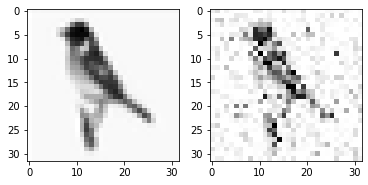

25  :  [0.3349688] 25
50  :  [0.4636674] 25
75  :  [0.52091146] 25
100  :  [0.52164596] 25
125  :  [0.52164596] 25
150  :  [0.5403565] 25
175  :  [0.5403565] 25
200  :  [0.5403565] 25
225  :  [0.5403565] 25
250  :  [0.5403565] 25
275  :  [0.55917364] 25
300  :  [0.56383294] 25
325  :  [0.56438917] 25
350  :  [0.56438917] 25
375  :  [0.56438917] 25
400  :  [0.57129455] 25
425  :  [0.57017106] 25
450  :  [0.5709035] 25
475  :  [0.5725032] 25
500  :  [0.5874238] 25
525  :  [0.5876033] 25
550  :  [0.59782743] 25
575  :  [0.6000131] 25
600  :  [0.60033035] 25
625  :  [0.60033035] 25
650  :  [0.60033035] 25
675  :  [0.6064478] 25
700  :  [0.6064478] 25
725  :  [0.60794467] 25
750  :  [0.6098083] 25
775  :  [0.61070293] 25
800  :  [0.6155303] 25
825  :  [0.6155303] 25
850  :  [0.6172945] 25
875  :  [0.61936134] 25
900  :  [0.61936134] 25
925  :  [0.61936134] 25
950  :  [0.62282056] 25
975  :  [0.62282056] 25
1000  :  [0.623811] 25
1025  :  [0.62405497] 25
1050  :  [0.62405497] 25
1075  :  [0.

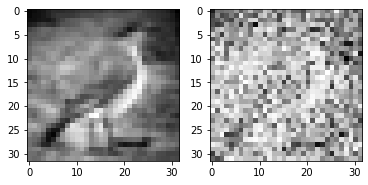

25  :  [0.35802752] 25
50  :  [0.37535197] 25
75  :  [0.46398565] 25
100  :  [0.47952402] 25
125  :  [0.47051018] 25
150  :  [0.49435443] 25
175  :  [0.48463643] 25
200  :  [0.49880618] 25
225  :  [0.522652] 25
250  :  [0.522652] 25
275  :  [0.522652] 25
300  :  [0.53694904] 25
325  :  [0.5372558] 25
350  :  [0.5295446] 25
375  :  [0.5295446] 25
400  :  [0.53220594] 25
425  :  [0.53220594] 25
450  :  [0.5484233] 25
475  :  [0.55032635] 25
500  :  [0.5513935] 25
525  :  [0.5513935] 25
550  :  [0.5513935] 25
575  :  [0.5513935] 25
600  :  [0.5518255] 25
625  :  [0.5518674] 25
650  :  [0.5518674] 25
675  :  [0.55208015] 25
700  :  [0.5518674] 25
725  :  [0.5518674] 25
750  :  [0.5518674] 25
775  :  [0.5518674] 25
800  :  [0.55279315] 25
825  :  [0.5540252] 25
850  :  [0.5540252] 25
875  :  [0.56163144] 25
900  :  [0.56163144] 25
925  :  [0.56163144] 25
950  :  [0.56163144] 25
975  :  [0.56163144] 25
1000  :  [0.56163144] 25
1025  :  [0.56163144] 25
1050  :  [0.56163144] 25
1075  :  [0.561

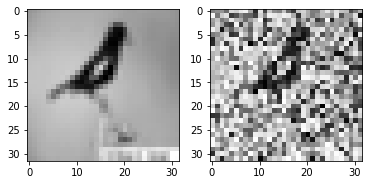

25  :  [0.8392465] 25
50  :  [0.8419908] 25
75  :  [0.85399014] 25
100  :  [0.85399014] 25
125  :  [0.8651657] 25
150  :  [0.8651657] 25
175  :  [0.8651657] 25
200  :  [0.86851835] 25
225  :  [0.8689678] 25
250  :  [0.8762533] 25
275  :  [0.8762533] 25
300  :  [0.87903106] 25
325  :  [0.87903106] 25
350  :  [0.8790736] 25
375  :  [0.88077056] 25
400  :  [0.8841357] 25
425  :  [0.8882348] 25
450  :  [0.8920085] 25
475  :  [0.8920085] 25
500  :  [0.89336187] 25
525  :  [0.8956593] 25
550  :  [0.8956593] 25
575  :  [0.8956593] 25
600  :  [0.89798915] 25
625  :  [0.89880276] 25
650  :  [0.89880276] 25
675  :  [0.8990437] 25
700  :  [0.89912474] 25
725  :  [0.90051246] 25
750  :  [0.9021313] 25
775  :  [0.9021313] 25
800  :  [0.9021313] 25
825  :  [0.90252244] 25
850  :  [0.90252244] 25
875  :  [0.9027948] 25
900  :  [0.90319824] 25
Time:  120.58695697784424  seconds
Original class:  3
Prediction for normal image:  [2]
Prediction for adversarial image:  [2]


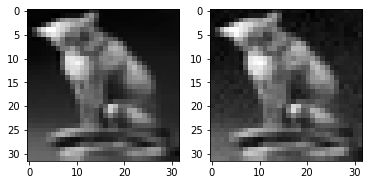

25  :  [0.65002495] 25
50  :  [0.66396195] 25
75  :  [0.6624325] 25
100  :  [0.671824] 25
125  :  [0.671824] 25
150  :  [0.671824] 25
175  :  [0.671824] 25
200  :  [0.671824] 25
225  :  [0.67193305] 25
250  :  [0.6853182] 25
275  :  [0.69431424] 25
300  :  [0.69427824] 25
325  :  [0.6946746] 25
350  :  [0.6946746] 25
375  :  [0.6946746] 25
400  :  [0.6946746] 25
425  :  [0.6946746] 25
450  :  [0.6946746] 25
475  :  [0.6963227] 25
500  :  [0.69512314] 25
525  :  [0.69512314] 25
550  :  [0.69512314] 25
575  :  [0.69512314] 25
600  :  [0.69512314] 25
625  :  [0.70382935] 25
650  :  [0.7055559] 25
675  :  [0.7136064] 25
700  :  [0.71390796] 25
725  :  [0.7251006] 25
750  :  [0.73735654] 25
775  :  [0.73735654] 25
800  :  [0.73751086] 25
825  :  [0.73751086] 25
850  :  [0.73751086] 25
875  :  [0.7439967] 25
900  :  [0.7439967] 25
925  :  [0.7439967] 25
950  :  [0.7439967] 25
975  :  [0.7439967] 25
1000  :  [0.74616265] 25
1025  :  [0.74616265] 25
1050  :  [0.74884856] 25
1075  :  [0.7509264

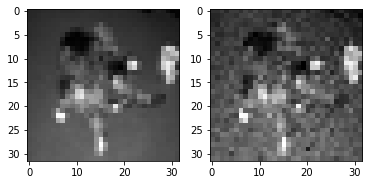

25  :  [0.5657478] 25
50  :  [0.5657478] 25
75  :  [0.71918726] 25
100  :  [0.73588324] 25
125  :  [0.73692405] 25
150  :  [0.73692405] 25
175  :  [0.7525834] 25
200  :  [0.7525834] 25
225  :  [0.7525834] 25
250  :  [0.7525834] 25
275  :  [0.7525834] 25
300  :  [0.7571626] 25
325  :  [0.7584877] 25
350  :  [0.7584877] 25
375  :  [0.7624023] 25
400  :  [0.7624023] 25
425  :  [0.77147484] 25
450  :  [0.7716236] 25
475  :  [0.77536964] 25
500  :  [0.77641964] 25
525  :  [0.77641964] 25
550  :  [0.77641964] 25
575  :  [0.77641964] 25
600  :  [0.77641964] 25
625  :  [0.77641964] 25
650  :  [0.77641964] 25
675  :  [0.7812172] 25
700  :  [0.7846801] 25
725  :  [0.7864705] 25
750  :  [0.7861655] 25
775  :  [0.78740096] 25
800  :  [0.79039246] 25
825  :  [0.7930096] 25
850  :  [0.7935165] 25
875  :  [0.795063] 25
900  :  [0.795063] 25
925  :  [0.7957997] 25
950  :  [0.7974169] 25
Time:  129.31011271476746  seconds
Original class:  3
Prediction for normal image:  [3]
Prediction for adversarial i

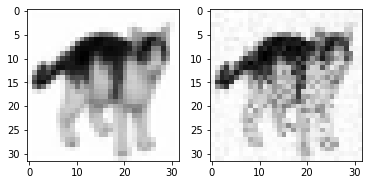

25  :  [0.6967356] 25
50  :  [0.6967356] 25
75  :  [0.78245175] 25
100  :  [0.78303516] 25
125  :  [0.78303516] 25
150  :  [0.78303516] 25
175  :  [0.78802276] 25
200  :  [0.7956942] 25
225  :  [0.7956942] 25
250  :  [0.81728435] 25
275  :  [0.81728435] 25
300  :  [0.81728435] 25
325  :  [0.81728435] 25
350  :  [0.8383046] 25
375  :  [0.8383046] 25
400  :  [0.8383046] 25
425  :  [0.8383046] 25
450  :  [0.8383046] 25
475  :  [0.8383046] 25
500  :  [0.8383046] 25
525  :  [0.84852314] 25
550  :  [0.84852314] 25
575  :  [0.84852314] 25
600  :  [0.85724473] 25
625  :  [0.85724473] 25
650  :  [0.85724473] 25
675  :  [0.8588034] 25
700  :  [0.8588034] 25
725  :  [0.8593931] 25
750  :  [0.8596616] 25
775  :  [0.8596616] 25
800  :  [0.8600048] 25
825  :  [0.8605542] 25
850  :  [0.8610624] 25
875  :  [0.86172307] 25
900  :  [0.8617472] 25
925  :  [0.8621835] 25
950  :  [0.8621835] 25
975  :  [0.8622153] 25
1000  :  [0.8623102] 25
1025  :  [0.8625077] 25
1050  :  [0.86286074] 25
1075  :  [0.86347

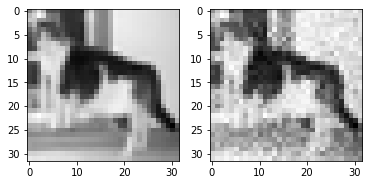

25  :  [0.92019725] 25
50  :  [0.9238192] 25
75  :  [0.9287644] 25
100  :  [0.93695474] 25
125  :  [0.9476778] 25
150  :  [0.9476778] 25
175  :  [0.9476778] 25
200  :  [0.9476778] 25
225  :  [0.9498434] 25
250  :  [0.9498434] 25
275  :  [0.9498434] 25
300  :  [0.9520565] 25
325  :  [0.9520565] 25
350  :  [0.9520565] 25
375  :  [0.9573773] 25
400  :  [0.9636891] 25
425  :  [0.9636891] 25
450  :  [0.9636891] 25
475  :  [0.9636891] 25
500  :  [0.9653945] 25
525  :  [0.9653945] 25
550  :  [0.96925807] 25
575  :  [0.96954775] 25
600  :  [0.9699966] 25
625  :  [0.9706191] 25
650  :  [0.97184765] 25
675  :  [0.9730178] 25
700  :  [0.9730178] 25
725  :  [0.97308874] 25
750  :  [0.97308874] 25
775  :  [0.97308874] 25
800  :  [0.97318244] 25
825  :  [0.97351] 25
850  :  [0.9738202] 25
875  :  [0.9738202] 25
900  :  [0.974007] 25
Time:  121.17847108840942  seconds
Original class:  3
Prediction for normal image:  [2]
Prediction for adversarial image:  [2]


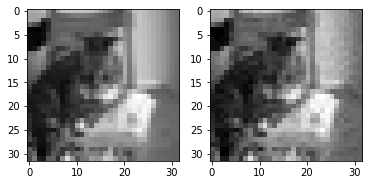

25  :  [0.85029775] 25
50  :  [0.85029775] 25
75  :  [0.8582988] 25
100  :  [0.8600042] 25
125  :  [0.8763814] 25
150  :  [0.8763814] 25
175  :  [0.8763865] 25
200  :  [0.8763865] 25
225  :  [0.8763865] 25
250  :  [0.8795049] 25
275  :  [0.8795049] 25
300  :  [0.8795049] 25
325  :  [0.8795049] 25
350  :  [0.9012157] 25
375  :  [0.90327704] 25
400  :  [0.90327704] 25
425  :  [0.90327704] 25
450  :  [0.90327704] 25
475  :  [0.90487015] 25
500  :  [0.91174895] 25
525  :  [0.91174895] 25
550  :  [0.9175291] 25
575  :  [0.91842604] 25
600  :  [0.9188565] 25
625  :  [0.9188565] 25
650  :  [0.9188565] 25
675  :  [0.91886294] 25
700  :  [0.91886294] 25
725  :  [0.91886294] 25
750  :  [0.9234686] 25
775  :  [0.92474735] 25
800  :  [0.92474735] 25
825  :  [0.92673177] 25
850  :  [0.92725515] 25
875  :  [0.9289979] 25
900  :  [0.9300429] 25
925  :  [0.9317466] 25
950  :  [0.93293476] 25
975  :  [0.93293476] 25
1000  :  [0.9334154] 25
1025  :  [0.9334154] 25
1050  :  [0.93345064] 25
1075  :  [0.93

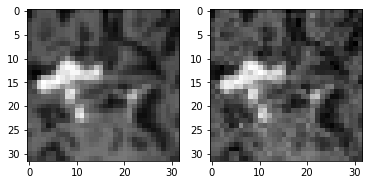

25  :  [0.67531955] 25
50  :  [0.6835526] 25
75  :  [0.7333337] 25
100  :  [0.7333337] 25
125  :  [0.7333337] 25
150  :  [0.7333337] 25
175  :  [0.7333337] 25
200  :  [0.74598217] 25
225  :  [0.7459297] 25
250  :  [0.75061786] 25
275  :  [0.7502147] 25
300  :  [0.7502147] 25
325  :  [0.7502147] 25
350  :  [0.7539902] 25
375  :  [0.75462353] 25
400  :  [0.75462353] 25
425  :  [0.75462353] 25
450  :  [0.75462353] 25
475  :  [0.75462353] 25
500  :  [0.7558156] 25
525  :  [0.7866644] 25
550  :  [0.78677714] 25
575  :  [0.78677714] 25
600  :  [0.78677714] 25
625  :  [0.78677714] 25
650  :  [0.78677714] 25
675  :  [0.78677714] 25
700  :  [0.78677714] 25
725  :  [0.78677714] 25
750  :  [0.78677714] 25
775  :  [0.78677714] 25
800  :  [0.78677714] 25
825  :  [0.78677714] 25
850  :  [0.78677714] 25
875  :  [0.78677714] 25
900  :  [0.78677714] 25
925  :  [0.78677714] 25
950  :  [0.78677714] 25
975  :  [0.78677714] 25
1000  :  [0.78677714] 25
1025  :  [0.78677714] 25
1050  :  [0.78677714] 25
1075 

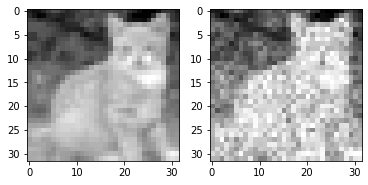

25  :  [0.7114259] 25
50  :  [0.72432864] 25
75  :  [0.7466882] 25
100  :  [0.74669456] 25
125  :  [0.74669456] 25
150  :  [0.7483301] 25
175  :  [0.7483301] 25
200  :  [0.7483301] 25
225  :  [0.75475484] 25
250  :  [0.7600901] 25
275  :  [0.7618848] 25
300  :  [0.76369584] 25
325  :  [0.76369584] 25
350  :  [0.78003144] 25
375  :  [0.78003144] 25
400  :  [0.78003144] 25
425  :  [0.78003144] 25
450  :  [0.78003144] 25
475  :  [0.78003144] 25
500  :  [0.78003144] 25
525  :  [0.78003144] 25
550  :  [0.7852832] 25
575  :  [0.7852832] 25
600  :  [0.7862985] 25
625  :  [0.7865933] 25
650  :  [0.7946262] 25
675  :  [0.7966229] 25
700  :  [0.7966229] 25
725  :  [0.7966229] 25
750  :  [0.7992679] 25
775  :  [0.80779195] 25
800  :  [0.80779195] 25
825  :  [0.8117124] 25
850  :  [0.8117124] 25
875  :  [0.8117124] 25
900  :  [0.8139124] 25
925  :  [0.81426394] 25
950  :  [0.816956] 25
975  :  [0.8185732] 25
1000  :  [0.8185732] 25
1025  :  [0.81975126] 25
1050  :  [0.81975126] 25
1075  :  [0.8197

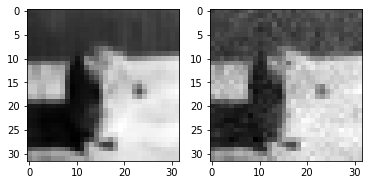

25  :  [0.5840409] 25
50  :  [0.5840409] 25
75  :  [0.5840409] 25
100  :  [0.6070702] 25
125  :  [0.6001327] 25
150  :  [0.6178396] 25
175  :  [0.6209603] 25
200  :  [0.6209603] 25
225  :  [0.6209603] 25
250  :  [0.6209603] 25
275  :  [0.6209603] 25
300  :  [0.6209603] 25
325  :  [0.6209603] 25
350  :  [0.6352443] 25
375  :  [0.63540494] 25
400  :  [0.63540494] 25
425  :  [0.63540494] 25
450  :  [0.63540494] 25
475  :  [0.6375456] 25
500  :  [0.6377331] 25
525  :  [0.6377331] 25
550  :  [0.64673585] 25
575  :  [0.6523696] 25
600  :  [0.6523696] 25
625  :  [0.6523696] 25
650  :  [0.6523696] 25
675  :  [0.6523696] 25
700  :  [0.6523696] 25
725  :  [0.65994364] 25
750  :  [0.65994084] 25
775  :  [0.66243035] 25
800  :  [0.66243035] 25
825  :  [0.66352874] 25
850  :  [0.66352874] 25
875  :  [0.67233175] 25
900  :  [0.67244405] 25
925  :  [0.6761718] 25
950  :  [0.6761718] 25
975  :  [0.6761718] 25
1000  :  [0.67783314] 25
1025  :  [0.68350565] 25
1050  :  [0.68627465] 25
1075  :  [0.688807

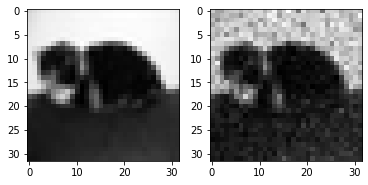

25  :  [0.8395169] 25
50  :  [0.8395169] 25
75  :  [0.8395169] 25
100  :  [0.8430363] 25
125  :  [0.86208355] 25
150  :  [0.86208355] 25
175  :  [0.86208355] 25
200  :  [0.86208355] 25
225  :  [0.86208355] 25
250  :  [0.8629316] 25
275  :  [0.86258805] 25
300  :  [0.86258805] 25
325  :  [0.86258805] 25
350  :  [0.86258805] 25
375  :  [0.8648188] 25
400  :  [0.8758477] 25
425  :  [0.8758477] 25
450  :  [0.8758477] 25
475  :  [0.8774065] 25
500  :  [0.8814998] 25
525  :  [0.89530843] 25
550  :  [0.89530486] 25
575  :  [0.89530486] 25
600  :  [0.89530486] 25
625  :  [0.8976724] 25
650  :  [0.91018647] 25
675  :  [0.91018647] 25
700  :  [0.91103864] 25
725  :  [0.9130881] 25
750  :  [0.91513515] 25
775  :  [0.91513515] 25
800  :  [0.91513515] 25
825  :  [0.91513515] 25
850  :  [0.91513515] 25
875  :  [0.9186619] 25
900  :  [0.9236203] 25
925  :  [0.9236203] 25
950  :  [0.9236203] 25
975  :  [0.9299655] 25
1000  :  [0.9299655] 25
1025  :  [0.9299655] 25
1050  :  [0.9299655] 25
1075  :  [0.9

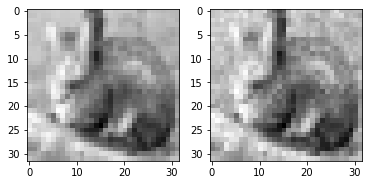

25  :  [0.79414904] 25
50  :  [0.8550043] 25
75  :  [0.88474613] 25
100  :  [0.88474613] 25
125  :  [0.88474613] 25
150  :  [0.88474613] 25
175  :  [0.88474613] 25
200  :  [0.89329636] 25
225  :  [0.89544827] 25
250  :  [0.8954371] 25
275  :  [0.8985541] 25
300  :  [0.8985541] 25
325  :  [0.89949465] 25
350  :  [0.8995974] 25
375  :  [0.90272266] 25
400  :  [0.90623754] 25
425  :  [0.90899265] 25
450  :  [0.91126615] 25
475  :  [0.9113029] 25
500  :  [0.9113029] 25
525  :  [0.9113029] 25
550  :  [0.91188097] 25
575  :  [0.91188097] 25
600  :  [0.9121639] 25
625  :  [0.9127325] 25
650  :  [0.9127325] 25
675  :  [0.9128717] 25
700  :  [0.9131043] 25
725  :  [0.9131043] 25
750  :  [0.9132211] 25
775  :  [0.9132421] 25
800  :  [0.91332614] 25
825  :  [0.91335106] 25
850  :  [0.91345215] 25
Time:  116.5993263721466  seconds
Original class:  3
Prediction for normal image:  [3]
Prediction for adversarial image:  [2]


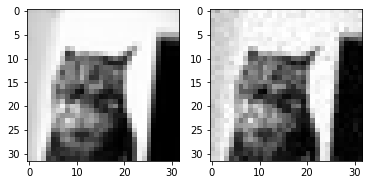

25  :  [0.8952818] 25
50  :  [0.9091252] 25
75  :  [0.9091252] 25
100  :  [0.9168159] 25
125  :  [0.9168159] 25
150  :  [0.919894] 25
175  :  [0.9213926] 25
200  :  [0.9257759] 25
225  :  [0.940256] 25
250  :  [0.940256] 25
275  :  [0.940256] 25
300  :  [0.94971627] 25
325  :  [0.94971627] 25
350  :  [0.94971627] 25
375  :  [0.94971627] 25
400  :  [0.9515383] 25
425  :  [0.9515383] 25
450  :  [0.9515383] 25
475  :  [0.9515383] 25
500  :  [0.9515383] 25
525  :  [0.9526963] 25
550  :  [0.9526963] 25
575  :  [0.9526963] 25
600  :  [0.9545237] 25
625  :  [0.95619786] 25
650  :  [0.95619786] 25
675  :  [0.95824206] 25
700  :  [0.95908684] 25
725  :  [0.96224177] 25
750  :  [0.96224177] 25
775  :  [0.9650851] 25
800  :  [0.9650851] 25
825  :  [0.96511817] 25
850  :  [0.96513593] 25
875  :  [0.96521866] 25
900  :  [0.96619725] 25
925  :  [0.96624374] 25
950  :  [0.96643656] 25
975  :  [0.966784] 25
1000  :  [0.966784] 25
Time:  135.35522985458374  seconds
Original class:  3
Prediction for nor

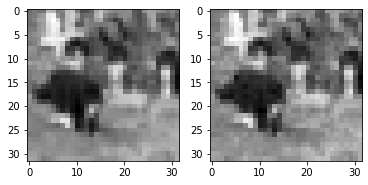

25  :  [0.89468396] 25
50  :  [0.91093683] 25
75  :  [0.9112617] 25
100  :  [0.9112617] 25
125  :  [0.91134924] 25
150  :  [0.91621566] 25
175  :  [0.9178556] 25
200  :  [0.9178556] 25
225  :  [0.9178556] 25
250  :  [0.9184998] 25
275  :  [0.9209964] 25
300  :  [0.92108524] 25
325  :  [0.92108524] 25
350  :  [0.92108524] 25
375  :  [0.92108524] 25
400  :  [0.9276651] 25
425  :  [0.9276651] 25
450  :  [0.934772] 25
475  :  [0.93481696] 25
500  :  [0.93481696] 25
525  :  [0.93481696] 25
550  :  [0.93481696] 25
575  :  [0.93481696] 25
600  :  [0.93481696] 25
625  :  [0.9365134] 25
650  :  [0.9365134] 25
675  :  [0.9365134] 25
700  :  [0.9365134] 25
725  :  [0.9374926] 25
750  :  [0.9413074] 25
775  :  [0.9413074] 25
800  :  [0.9439473] 25
825  :  [0.94620734] 25
Time:  109.65126252174377  seconds
Original class:  3
Prediction for normal image:  [5]
Prediction for adversarial image:  [6]


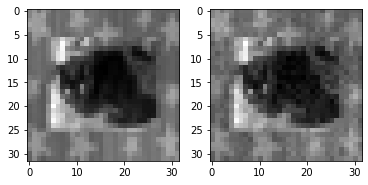

25  :  [0.14055124] 25
50  :  [0.5375099] 25
75  :  [0.6469209] 25
100  :  [0.69544053] 25
125  :  [0.71925807] 25
150  :  [0.72621495] 25
175  :  [0.72621495] 25
200  :  [0.72621495] 25
225  :  [0.72621495] 25
250  :  [0.72621495] 25
275  :  [0.7279646] 25
300  :  [0.7280694] 25
325  :  [0.73849714] 25
350  :  [0.73961467] 25
375  :  [0.73961467] 25
400  :  [0.7459389] 25
425  :  [0.74875975] 25
450  :  [0.75217485] 25
475  :  [0.7554276] 25
500  :  [0.7571315] 25
525  :  [0.7605437] 25
550  :  [0.7635377] 25
575  :  [0.7646909] 25
600  :  [0.76765144] 25
625  :  [0.7696707] 25
650  :  [0.77094537] 25
675  :  [0.7741233] 25
700  :  [0.775005] 25
725  :  [0.7784244] 25
750  :  [0.7784244] 25
775  :  [0.7797529] 25
800  :  [0.7801038] 25
825  :  [0.78037536] 25
850  :  [0.78159547] 25
875  :  [0.7832852] 25
900  :  [0.7832852] 25
925  :  [0.7835068] 25
950  :  [0.7835068] 25
975  :  [0.7835068] 25
1000  :  [0.7835068] 25
1025  :  [0.78367835] 25
1050  :  [0.78380287] 25
1075  :  [0.7838

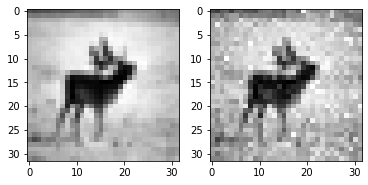

25  :  [0.5849286] 25
50  :  [0.6438878] 25
75  :  [0.6198844] 25
100  :  [0.6611663] 25
125  :  [0.66656774] 25
150  :  [0.6689813] 25
175  :  [0.66903067] 25
200  :  [0.66903067] 25
225  :  [0.66903067] 25
250  :  [0.6936636] 25
275  :  [0.691316] 25
300  :  [0.691316] 25
325  :  [0.691316] 25
350  :  [0.69422126] 25
375  :  [0.69422126] 25
400  :  [0.69847554] 25
425  :  [0.7088058] 25
450  :  [0.7088058] 25
475  :  [0.7088058] 25
500  :  [0.71106625] 25
525  :  [0.71603477] 25
550  :  [0.71603477] 25
575  :  [0.72100055] 25
600  :  [0.72519857] 25
625  :  [0.7253178] 25
650  :  [0.7253178] 25
675  :  [0.7261535] 25
700  :  [0.72617066] 25
725  :  [0.72617066] 25
750  :  [0.7278351] 25
775  :  [0.72979474] 25
800  :  [0.73044837] 25
825  :  [0.73224413] 25
850  :  [0.7327927] 25
875  :  [0.7333633] 25
900  :  [0.73375136] 25
925  :  [0.7348039] 25
950  :  [0.7348039] 25
975  :  [0.7358431] 25
1000  :  [0.7359412] 25
1025  :  [0.7359412] 25
1050  :  [0.73623776] 25
1075  :  [0.736296

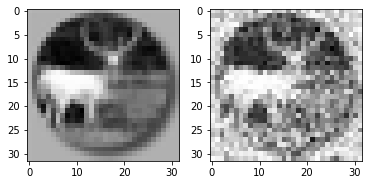

25  :  [0.86841655] 25
50  :  [0.87730825] 25
75  :  [0.8824209] 25
100  :  [0.8824209] 25
125  :  [0.8824209] 25
150  :  [0.8824209] 25
175  :  [0.89008] 25
200  :  [0.8903669] 25
225  :  [0.8907059] 25
250  :  [0.91672885] 25
275  :  [0.91672885] 25
300  :  [0.91672885] 25
325  :  [0.91672885] 25
350  :  [0.91672885] 25
375  :  [0.9181744] 25
400  :  [0.9181744] 25
425  :  [0.92022866] 25
450  :  [0.92022866] 25
475  :  [0.92022866] 25
500  :  [0.927555] 25
525  :  [0.92862046] 25
550  :  [0.92862046] 25
575  :  [0.92862046] 25
600  :  [0.92862046] 25
625  :  [0.9305955] 25
650  :  [0.9305955] 25
675  :  [0.93158996] 25
700  :  [0.9350976] 25
725  :  [0.9350976] 25
750  :  [0.9350976] 25
775  :  [0.9363704] 25
800  :  [0.93715334] 25
825  :  [0.93838227] 25
850  :  [0.9395381] 25
875  :  [0.9406216] 25
900  :  [0.94088167] 25
925  :  [0.9415488] 25
950  :  [0.94251657] 25
975  :  [0.94298875] 25
1000  :  [0.9439683] 25
1025  :  [0.9439683] 25
Time:  137.39687514305115  seconds
Origin

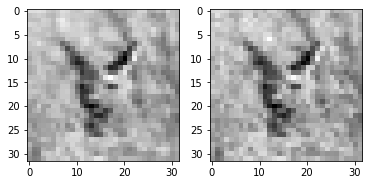

25  :  [0.8280277] 25
50  :  [0.8349533] 25
75  :  [0.8872243] 25
100  :  [0.8832792] 25
125  :  [0.8832792] 25
150  :  [0.8832792] 25
175  :  [0.8832792] 25
200  :  [0.89193285] 25
225  :  [0.8939205] 25
250  :  [0.8925437] 25
275  :  [0.8925437] 25
300  :  [0.8925437] 25
325  :  [0.8925437] 25
350  :  [0.89300734] 25
375  :  [0.89300734] 25
400  :  [0.89300734] 25
425  :  [0.89300734] 25
450  :  [0.89300734] 25
475  :  [0.89300734] 25
500  :  [0.89300734] 25
525  :  [0.8946245] 25
550  :  [0.8999214] 25
575  :  [0.8999214] 25
600  :  [0.8999214] 25
625  :  [0.909162] 25
650  :  [0.9108666] 25
675  :  [0.9189161] 25
700  :  [0.9240931] 25
725  :  [0.9240931] 25
750  :  [0.9250611] 25
775  :  [0.9250611] 25
800  :  [0.9288412] 25
825  :  [0.9320278] 25
850  :  [0.9320278] 25
Time:  113.32478404045105  seconds
Original class:  4
Prediction for normal image:  [4]
Prediction for adversarial image:  [2]


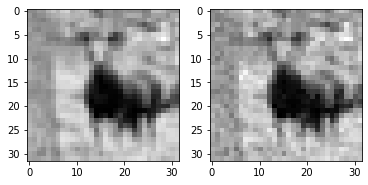

25  :  [0.6943091] 25
50  :  [0.715981] 25
75  :  [0.72696495] 25
100  :  [0.72696495] 25
125  :  [0.72696495] 25
150  :  [0.75746113] 25
175  :  [0.75746113] 25
200  :  [0.75746113] 25
225  :  [0.7637819] 25
250  :  [0.785016] 25
275  :  [0.78992593] 25
300  :  [0.78992593] 25
325  :  [0.791794] 25
350  :  [0.8134382] 25
375  :  [0.8134382] 25
400  :  [0.8134382] 25
425  :  [0.8393067] 25
450  :  [0.8393067] 25
475  :  [0.8393067] 25
500  :  [0.8393067] 25
525  :  [0.8393067] 25
550  :  [0.8393067] 25
575  :  [0.8393067] 25
600  :  [0.83997893] 25
625  :  [0.8420669] 25
650  :  [0.8420669] 25
675  :  [0.8420669] 25
700  :  [0.8461281] 25
725  :  [0.8461281] 25
750  :  [0.84700865] 25
775  :  [0.84856784] 25
800  :  [0.8493042] 25
825  :  [0.85138226] 25
850  :  [0.85138226] 25
875  :  [0.8533754] 25
900  :  [0.85407126] 25
925  :  [0.85407126] 25
950  :  [0.85407126] 25
975  :  [0.8547679] 25
1000  :  [0.8553922] 25
1025  :  [0.85566807] 25
1050  :  [0.85594034] 25
1075  :  [0.8563978

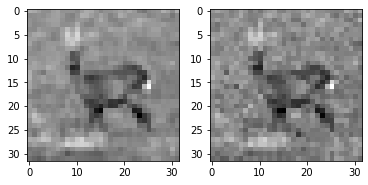

25  :  [0.77806187] 25
50  :  [0.77806187] 25
75  :  [0.78775394] 25
100  :  [0.7984889] 25
125  :  [0.80737156] 25
150  :  [0.8230052] 25
175  :  [0.8230052] 25
200  :  [0.8230052] 25
225  :  [0.83640456] 25
250  :  [0.83640456] 25
275  :  [0.84850633] 25
300  :  [0.84850633] 25
325  :  [0.84850633] 25
350  :  [0.84850633] 25
375  :  [0.84850633] 25
400  :  [0.84850633] 25
425  :  [0.84850633] 25
450  :  [0.8541909] 25
475  :  [0.8541909] 25
500  :  [0.85615885] 25
525  :  [0.85615885] 25
550  :  [0.85615885] 25
575  :  [0.871276] 25
600  :  [0.871276] 25
625  :  [0.871276] 25
650  :  [0.8746951] 25
675  :  [0.8856053] 25
700  :  [0.8880281] 25
725  :  [0.8880281] 25
750  :  [0.8880281] 25
775  :  [0.89055] 25
800  :  [0.89055] 25
825  :  [0.8947332] 25
850  :  [0.8977511] 25
875  :  [0.8989528] 25
900  :  [0.9051812] 25
925  :  [0.9082581] 25
950  :  [0.9093472] 25
975  :  [0.9093472] 25
1000  :  [0.9100908] 25
1025  :  [0.9108715] 25
1050  :  [0.9108715] 25
1075  :  [0.9108715] 25
1

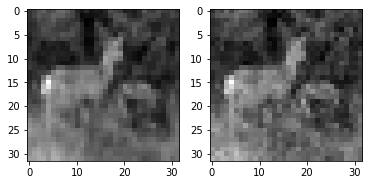

25  :  [0.81969965] 25
50  :  [0.81969965] 25
75  :  [0.8205411] 25
100  :  [0.8201806] 25
125  :  [0.8380706] 25
150  :  [0.84047127] 25
175  :  [0.84449756] 25
200  :  [0.844697] 25
225  :  [0.8532554] 25
250  :  [0.8597423] 25
275  :  [0.8597423] 25
300  :  [0.8597423] 25
325  :  [0.8761685] 25
350  :  [0.8761685] 25
375  :  [0.87709767] 25
400  :  [0.8781353] 25
425  :  [0.8839135] 25
450  :  [0.8863012] 25
475  :  [0.89644074] 25
500  :  [0.89644074] 25
525  :  [0.89644074] 25
550  :  [0.9043332] 25
575  :  [0.9043332] 25
600  :  [0.90678746] 25
625  :  [0.91069937] 25
650  :  [0.91069937] 25
675  :  [0.91069937] 25
700  :  [0.91548276] 25
725  :  [0.91548276] 25
750  :  [0.91548276] 25
775  :  [0.91548276] 25
800  :  [0.9178182] 25
825  :  [0.9178182] 25
850  :  [0.91833454] 25
875  :  [0.91833454] 25
900  :  [0.91833454] 25
925  :  [0.91833454] 25
950  :  [0.92016876] 25
975  :  [0.9216391] 25
1000  :  [0.9223594] 25
1025  :  [0.92285514] 25
1050  :  [0.925449] 25
1075  :  [0.92

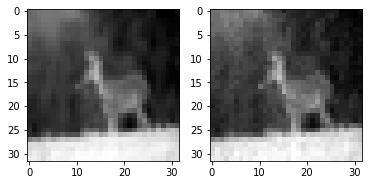

25  :  [0.4454176] 25
50  :  [0.6408247] 25
75  :  [0.73176706] 25
100  :  [0.7155961] 25
125  :  [0.7155961] 25
150  :  [0.7155961] 25
175  :  [0.7155961] 25
200  :  [0.7155961] 25
225  :  [0.7155961] 25
250  :  [0.7426791] 25
275  :  [0.74425435] 25
300  :  [0.7441702] 25
325  :  [0.7441702] 25
350  :  [0.7441702] 25
375  :  [0.7441702] 25
400  :  [0.7441702] 25
425  :  [0.7441702] 25
450  :  [0.7441702] 25
475  :  [0.7441702] 25
500  :  [0.7441702] 25
525  :  [0.7441702] 25
550  :  [0.7441702] 25
575  :  [0.7441702] 25
600  :  [0.7441702] 25
625  :  [0.7441702] 25
650  :  [0.7441702] 25
675  :  [0.75380003] 25
700  :  [0.77884233] 25
725  :  [0.77884233] 25
750  :  [0.77884233] 25
775  :  [0.77884233] 25
800  :  [0.77884233] 25
825  :  [0.77884233] 25
850  :  [0.77884233] 25
875  :  [0.77884233] 25
900  :  [0.77884233] 25
925  :  [0.77884233] 25
950  :  [0.77884233] 25
975  :  [0.77884233] 25
1000  :  [0.77884233] 25
1025  :  [0.7913648] 25
1050  :  [0.7913648] 25
1075  :  [0.792184

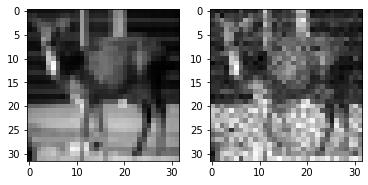

25  :  [0.8555992] 25
50  :  [0.8555992] 25
75  :  [0.8555992] 25
100  :  [0.8844271] 25
125  :  [0.88432544] 25
150  :  [0.88432544] 25
175  :  [0.88432544] 25
200  :  [0.88432544] 25
225  :  [0.88432544] 25
250  :  [0.88432544] 25
275  :  [0.88432544] 25
300  :  [0.88432544] 25
325  :  [0.88543904] 25
350  :  [0.88543904] 25
375  :  [0.90163136] 25
400  :  [0.9016521] 25
425  :  [0.9016521] 25
450  :  [0.9036217] 25
475  :  [0.90728843] 25
500  :  [0.90728843] 25
525  :  [0.9105735] 25
550  :  [0.91177344] 25
575  :  [0.9164518] 25
600  :  [0.91775477] 25
625  :  [0.91942924] 25
650  :  [0.91942924] 25
675  :  [0.91942924] 25
700  :  [0.91966057] 25
725  :  [0.92027307] 25
750  :  [0.920662] 25
775  :  [0.920662] 25
800  :  [0.922021] 25
825  :  [0.922021] 25
850  :  [0.92203707] 25
875  :  [0.92203707] 25
900  :  [0.92203707] 25
925  :  [0.92203707] 25
950  :  [0.92226076] 25
975  :  [0.9223842] 25
1000  :  [0.9225377] 25
1025  :  [0.92255896] 25
1050  :  [0.92266494] 25
1075  :  [0

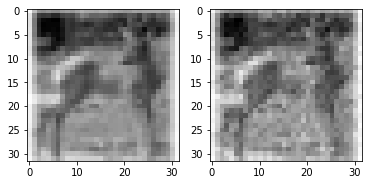

25  :  [0.76117253] 25
50  :  [0.76414454] 25
75  :  [0.7640134] 25
100  :  [0.7640134] 25
125  :  [0.7640134] 25
150  :  [0.7640134] 25
175  :  [0.7640134] 25
200  :  [0.7717869] 25
225  :  [0.7717869] 25
250  :  [0.7964797] 25
275  :  [0.813468] 25
300  :  [0.813468] 25
325  :  [0.813468] 25
350  :  [0.813468] 25
375  :  [0.813468] 25
400  :  [0.82811856] 25
425  :  [0.82811856] 25
450  :  [0.82811856] 25
475  :  [0.82811856] 25
500  :  [0.82811856] 25
525  :  [0.82811856] 25
550  :  [0.82811856] 25
575  :  [0.8316463] 25
600  :  [0.84384614] 25
625  :  [0.8451307] 25
650  :  [0.8451307] 25
675  :  [0.8451307] 25
700  :  [0.8451444] 25
725  :  [0.8451444] 25
750  :  [0.85695004] 25
775  :  [0.85806787] 25
800  :  [0.85806787] 25
825  :  [0.86380184] 25
850  :  [0.86380184] 25
875  :  [0.8647721] 25
900  :  [0.87197113] 25
925  :  [0.87850857] 25
950  :  [0.8818238] 25
975  :  [0.8818238] 25
1000  :  [0.8818238] 25
1025  :  [0.8818238] 25
1050  :  [0.8818238] 25
1075  :  [0.883228] 25

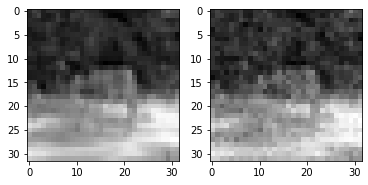

25  :  [0.87790763] 25
50  :  [0.87790763] 25
75  :  [0.87790763] 25
100  :  [0.8912746] 25
125  :  [0.8922327] 25
150  :  [0.8922327] 25
175  :  [0.90174764] 25
200  :  [0.90174764] 25
225  :  [0.9206354] 25
250  :  [0.9206354] 25
275  :  [0.9279305] 25
300  :  [0.9279305] 25
325  :  [0.9279305] 25
350  :  [0.93147516] 25
375  :  [0.93147516] 25
400  :  [0.9321083] 25
425  :  [0.93570244] 25
450  :  [0.93810296] 25
475  :  [0.9412739] 25
500  :  [0.94249475] 25
525  :  [0.94249475] 25
550  :  [0.94249475] 25
575  :  [0.94293976] 25
600  :  [0.94293976] 25
625  :  [0.9450686] 25
650  :  [0.9450686] 25
675  :  [0.9453663] 25
700  :  [0.9462922] 25
725  :  [0.9473773] 25
750  :  [0.9473773] 25
775  :  [0.94818676] 25
800  :  [0.94818676] 25
825  :  [0.94847465] 25
850  :  [0.94858587] 25
875  :  [0.94901276] 25
900  :  [0.94901276] 25
925  :  [0.9490758] 25
950  :  [0.9492016] 25
975  :  [0.9492016] 25
1000  :  [0.9494039] 25
Time:  142.10089945793152  seconds
Original class:  4
Predicti

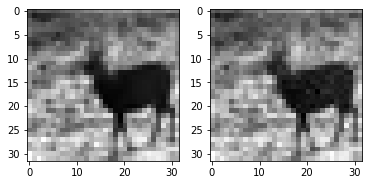

25  :  [0.8528327] 25
50  :  [0.8528327] 25
75  :  [0.86456543] 25
100  :  [0.86456543] 25
125  :  [0.86456543] 25
150  :  [0.86456543] 25
175  :  [0.86456543] 25
200  :  [0.86456543] 25
225  :  [0.86456543] 25
250  :  [0.86456543] 25
275  :  [0.86456543] 25
300  :  [0.86456543] 25
325  :  [0.86456543] 25
350  :  [0.86456543] 25
375  :  [0.86456543] 25
400  :  [0.8655052] 25
425  :  [0.8655052] 25
450  :  [0.8655052] 25
475  :  [0.8655052] 25
500  :  [0.8655052] 25
525  :  [0.87601644] 25
550  :  [0.87601644] 25
575  :  [0.8780667] 25
600  :  [0.8925053] 25
625  :  [0.8925053] 25
650  :  [0.8925053] 25
675  :  [0.8951312] 25
700  :  [0.8951312] 25
725  :  [0.8951312] 25
750  :  [0.9042406] 25
775  :  [0.908937] 25
800  :  [0.908937] 25
825  :  [0.908937] 25
850  :  [0.908937] 25
875  :  [0.91144323] 25
900  :  [0.91144323] 25
925  :  [0.91192746] 25
950  :  [0.91455317] 25
975  :  [0.91455317] 25
1000  :  [0.9169475] 25
1025  :  [0.91817546] 25
1050  :  [0.9200314] 25
1075  :  [0.92185

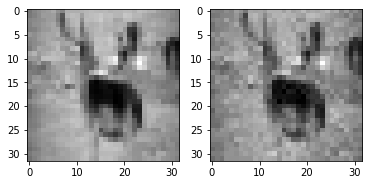

25  :  [0.8748017] 25
50  :  [0.8748017] 25
75  :  [0.89380926] 25
100  :  [0.89380926] 25
125  :  [0.89380926] 25
150  :  [0.89380926] 25
175  :  [0.89380926] 25
200  :  [0.8949901] 25
225  :  [0.8949901] 25
250  :  [0.9218221] 25
275  :  [0.92297554] 25
300  :  [0.92297554] 25
325  :  [0.92297554] 25
350  :  [0.92297554] 25
375  :  [0.93308115] 25
400  :  [0.93308115] 25
425  :  [0.9349544] 25
450  :  [0.9349544] 25
475  :  [0.9349544] 25
500  :  [0.9349544] 25
525  :  [0.9396757] 25
550  :  [0.9396757] 25
575  :  [0.9415139] 25
600  :  [0.9416491] 25
625  :  [0.9416491] 25
650  :  [0.94335574] 25
675  :  [0.94587785] 25
700  :  [0.94587785] 25
725  :  [0.94640577] 25
750  :  [0.9480505] 25
775  :  [0.9480505] 25
800  :  [0.9480505] 25
825  :  [0.9480505] 25
850  :  [0.9480505] 25
875  :  [0.9480505] 25
900  :  [0.94812614] 25
925  :  [0.94812614] 25
950  :  [0.9482377] 25
975  :  [0.9482377] 25
1000  :  [0.9482377] 25
1025  :  [0.94835997] 25
1050  :  [0.94835997] 25
1075  :  [0.948

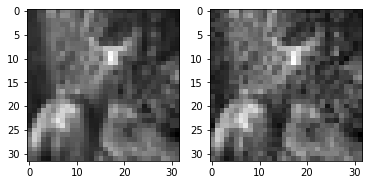

25  :  [0.63274336] 25
50  :  [0.642624] 25
75  :  [0.6446873] 25
100  :  [0.65526253] 25
125  :  [0.65526253] 25
150  :  [0.65526253] 25
175  :  [0.65902233] 25
200  :  [0.6688163] 25
225  :  [0.6763521] 25
250  :  [0.67726535] 25
275  :  [0.68255025] 25
300  :  [0.6962416] 25
325  :  [0.69949305] 25
350  :  [0.69949305] 25
375  :  [0.69949305] 25
400  :  [0.69949305] 25
425  :  [0.70936227] 25
450  :  [0.71473527] 25
475  :  [0.72499406] 25
500  :  [0.72499406] 25
525  :  [0.72499406] 25
550  :  [0.7335855] 25
575  :  [0.734849] 25
600  :  [0.7396003] 25
625  :  [0.74108034] 25
650  :  [0.74837345] 25
675  :  [0.74837345] 25
700  :  [0.7541361] 25
725  :  [0.7567949] 25
750  :  [0.75757146] 25
775  :  [0.7604518] 25
800  :  [0.761338] 25
825  :  [0.76426685] 25
850  :  [0.76559126] 25
875  :  [0.76703906] 25
900  :  [0.7698055] 25
925  :  [0.7698055] 25
950  :  [0.77094805] 25
975  :  [0.77216893] 25
1000  :  [0.7747313] 25
1025  :  [0.7747313] 25
1050  :  [0.775275] 25
1075  :  [0.7

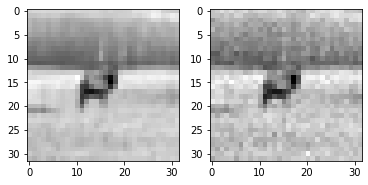

25  :  [0.7304437] 25
50  :  [0.7304437] 25
75  :  [0.7304437] 25
100  :  [0.7304437] 25
125  :  [0.7304437] 25
150  :  [0.7363483] 25
175  :  [0.79365754] 25
200  :  [0.79365754] 25
225  :  [0.79365754] 25
250  :  [0.79365754] 25
275  :  [0.79365754] 25
300  :  [0.79365754] 25
325  :  [0.79365754] 25
350  :  [0.7979529] 25
375  :  [0.7979529] 25
400  :  [0.7979529] 25
425  :  [0.81095266] 25
450  :  [0.8117719] 25
475  :  [0.8117719] 25
500  :  [0.8117719] 25
525  :  [0.8117719] 25
550  :  [0.8117719] 25
575  :  [0.8117719] 25
600  :  [0.8203739] 25
625  :  [0.82972383] 25
650  :  [0.82972383] 25
675  :  [0.82972383] 25
700  :  [0.8379171] 25
725  :  [0.84410185] 25
750  :  [0.84506965] 25
775  :  [0.84506965] 25
800  :  [0.84506965] 25
825  :  [0.84809935] 25
850  :  [0.84809935] 25
875  :  [0.84809935] 25
900  :  [0.84809935] 25
925  :  [0.8494911] 25
950  :  [0.85200286] 25
975  :  [0.8533537] 25
1000  :  [0.858392] 25
1025  :  [0.8587414] 25
1050  :  [0.8587414] 25
1075  :  [0.859

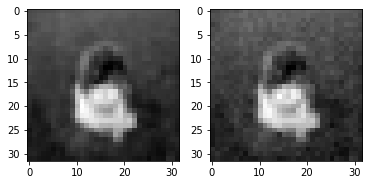

25  :  [0.7118925] 25
50  :  [0.7118925] 25
75  :  [0.7414598] 25
100  :  [0.7838987] 25
125  :  [0.7877988] 25
150  :  [0.7877988] 25
175  :  [0.8064772] 25
200  :  [0.81045264] 25
225  :  [0.8102024] 25
250  :  [0.8102024] 25
275  :  [0.8345945] 25
300  :  [0.8345945] 25
325  :  [0.8345945] 25
350  :  [0.8345945] 25
375  :  [0.8345945] 25
400  :  [0.8345945] 25
425  :  [0.8345945] 25
450  :  [0.8345945] 25
475  :  [0.8345945] 25
500  :  [0.8396785] 25
525  :  [0.84263885] 25
550  :  [0.8487164] 25
575  :  [0.8487164] 25
600  :  [0.85027695] 25
625  :  [0.8512503] 25
650  :  [0.85524243] 25
675  :  [0.8571635] 25
700  :  [0.8571635] 25
725  :  [0.8571635] 25
750  :  [0.863117] 25
775  :  [0.8641691] 25
800  :  [0.86474794] 25
825  :  [0.86756307] 25
850  :  [0.86943406] 25
875  :  [0.87014043] 25
900  :  [0.8703917] 25
925  :  [0.8703917] 25
950  :  [0.87125826] 25
975  :  [0.8722661] 25
1000  :  [0.8722661] 25
1025  :  [0.8722661] 25
1050  :  [0.8722661] 25
Time:  149.21065950393677 

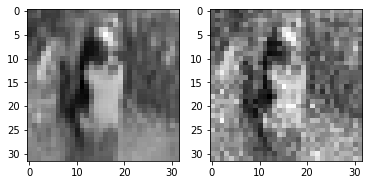

25  :  [0.7823031] 25
50  :  [0.799676] 25
75  :  [0.80926144] 25
100  :  [0.80926144] 25
125  :  [0.8128513] 25
150  :  [0.83594847] 25
175  :  [0.83594847] 25
200  :  [0.83594847] 25
225  :  [0.83594847] 25
250  :  [0.83594847] 25
275  :  [0.83717966] 25
300  :  [0.83717966] 25
325  :  [0.83717966] 25
350  :  [0.8425417] 25
375  :  [0.8425417] 25
400  :  [0.8425417] 25
425  :  [0.84414905] 25
450  :  [0.84755933] 25
475  :  [0.84832126] 25
500  :  [0.84832126] 25
525  :  [0.85120094] 25
550  :  [0.85120094] 25
575  :  [0.85120094] 25
600  :  [0.85120094] 25
625  :  [0.85649896] 25
650  :  [0.85649896] 25
675  :  [0.86491084] 25
700  :  [0.86491084] 25
725  :  [0.86654454] 25
750  :  [0.8686993] 25
775  :  [0.8694638] 25
800  :  [0.8732638] 25
825  :  [0.8732638] 25
850  :  [0.8757059] 25
875  :  [0.8757059] 25
900  :  [0.8764153] 25
925  :  [0.8764153] 25
Time:  134.24827814102173  seconds
Original class:  5
Prediction for normal image:  [5]
Prediction for adversarial image:  [2]


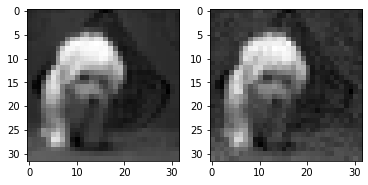

25  :  [0.8550141] 25
50  :  [0.8619487] 25
75  :  [0.8612882] 25
100  :  [0.8612882] 25
125  :  [0.8612882] 25
150  :  [0.8756626] 25
175  :  [0.8756626] 25
200  :  [0.8756626] 25
225  :  [0.8774675] 25
250  :  [0.87892234] 25
275  :  [0.87892234] 25
300  :  [0.87892234] 25
325  :  [0.88646984] 25
350  :  [0.88646984] 25
375  :  [0.88646984] 25
400  :  [0.88646984] 25
425  :  [0.88646984] 25
450  :  [0.88646984] 25
475  :  [0.88646984] 25
500  :  [0.88646984] 25
525  :  [0.88646984] 25
550  :  [0.88646984] 25
575  :  [0.88646984] 25
600  :  [0.88646984] 25
625  :  [0.88646984] 25
650  :  [0.8886839] 25
675  :  [0.88920164] 25
700  :  [0.88920164] 25
725  :  [0.89523256] 25
750  :  [0.8973441] 25
775  :  [0.90245736] 25
800  :  [0.91330695] 25
825  :  [0.91330695] 25
850  :  [0.9162601] 25
875  :  [0.9162601] 25
900  :  [0.9162601] 25
925  :  [0.9168711] 25
950  :  [0.9168711] 25
975  :  [0.92209584] 25
1000  :  [0.9226843] 25
1025  :  [0.92291164] 25
1050  :  [0.924831] 25
1075  :  [0

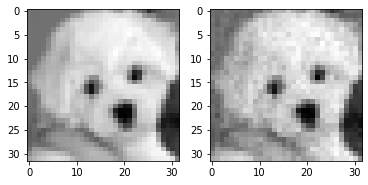

25  :  [0.86858815] 25
50  :  [0.86858815] 25
75  :  [0.8767042] 25
100  :  [0.8767042] 25
125  :  [0.87956417] 25
150  :  [0.8830246] 25
175  :  [0.8884844] 25
200  :  [0.8931899] 25
225  :  [0.8962456] 25
250  :  [0.89894795] 25
275  :  [0.90124977] 25
300  :  [0.9156647] 25
325  :  [0.9156647] 25
350  :  [0.9156647] 25
375  :  [0.9181875] 25
400  :  [0.9181875] 25
425  :  [0.9200733] 25
450  :  [0.9200733] 25
475  :  [0.9200733] 25
500  :  [0.92180544] 25
525  :  [0.92382276] 25
550  :  [0.92382276] 25
575  :  [0.92647713] 25
600  :  [0.92801] 25
625  :  [0.93087876] 25
650  :  [0.93087876] 25
675  :  [0.93087876] 25
700  :  [0.93239874] 25
725  :  [0.9370172] 25
750  :  [0.9370172] 25
775  :  [0.93845934] 25
800  :  [0.93845934] 25
825  :  [0.93951714] 25
850  :  [0.9399798] 25
875  :  [0.9412613] 25
900  :  [0.9412613] 25
925  :  [0.9422343] 25
950  :  [0.9423902] 25
975  :  [0.9427419] 25
1000  :  [0.9428965] 25
1025  :  [0.9430809] 25
1050  :  [0.9431065] 25
1075  :  [0.9435164]

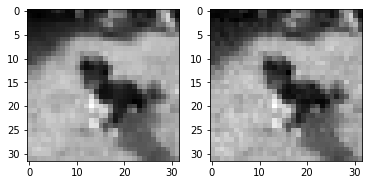

25  :  [0.83409667] 25
50  :  [0.83409667] 25
75  :  [0.83409667] 25
100  :  [0.83409667] 25
125  :  [0.84967923] 25
150  :  [0.8521848] 25
175  :  [0.85582566] 25
200  :  [0.85582566] 25
225  :  [0.85582566] 25
250  :  [0.85697246] 25
275  :  [0.85697246] 25
300  :  [0.85697246] 25
325  :  [0.86621606] 25
350  :  [0.86621606] 25
375  :  [0.8739284] 25
400  :  [0.8739284] 25
425  :  [0.87705165] 25
450  :  [0.87705165] 25
475  :  [0.87705165] 25
500  :  [0.87973887] 25
525  :  [0.87973887] 25
550  :  [0.88694596] 25
575  :  [0.89580566] 25
600  :  [0.8972471] 25
625  :  [0.8990475] 25
650  :  [0.8990475] 25
675  :  [0.90148985] 25
700  :  [0.90148985] 25
725  :  [0.90148985] 25
750  :  [0.90248215] 25
775  :  [0.90569544] 25
800  :  [0.9057782] 25
825  :  [0.90872604] 25
850  :  [0.90875024] 25
875  :  [0.90875024] 25
900  :  [0.91061604] 25
Time:  129.32245254516602  seconds
Original class:  5
Prediction for normal image:  [5]
Prediction for adversarial image:  [2]


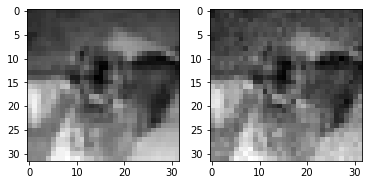

25  :  [0.6930201] 25
50  :  [0.6930201] 25
75  :  [0.7301537] 25
100  :  [0.72533625] 25
125  :  [0.74184275] 25
150  :  [0.7444314] 25
175  :  [0.7444314] 25
200  :  [0.74494433] 25
225  :  [0.74491864] 25
250  :  [0.7498231] 25
275  :  [0.74896544] 25
300  :  [0.74896544] 25
325  :  [0.7605114] 25
350  :  [0.75987947] 25
375  :  [0.75987947] 25
400  :  [0.7679175] 25
425  :  [0.7679175] 25
450  :  [0.7679175] 25
475  :  [0.7708572] 25
500  :  [0.7722716] 25
525  :  [0.77705634] 25
550  :  [0.7967157] 25
575  :  [0.7967157] 25
600  :  [0.8018424] 25
625  :  [0.8018424] 25
650  :  [0.8018424] 25
675  :  [0.8018424] 25
700  :  [0.8018424] 25
725  :  [0.8018424] 25
750  :  [0.8018424] 25
775  :  [0.8023639] 25
800  :  [0.8080571] 25
825  :  [0.8080571] 25
850  :  [0.8080571] 25
875  :  [0.8080571] 25
900  :  [0.8080571] 25
925  :  [0.8139315] 25
950  :  [0.8139315] 25
975  :  [0.8139315] 25
1000  :  [0.8139315] 25
1025  :  [0.8146862] 25
1050  :  [0.81466377] 25
1075  :  [0.81466377] 25

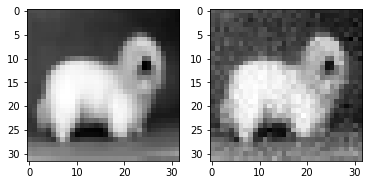

25  :  [0.88728917] 25
50  :  [0.9180987] 25
75  :  [0.91999066] 25
100  :  [0.91999066] 25
125  :  [0.91999066] 25
150  :  [0.92496896] 25
175  :  [0.92492664] 25
200  :  [0.92674303] 25
225  :  [0.9263882] 25
250  :  [0.9263882] 25
275  :  [0.9263882] 25
300  :  [0.9263882] 25
325  :  [0.9263882] 25
350  :  [0.9263882] 25
375  :  [0.92809856] 25
400  :  [0.93334067] 25
425  :  [0.93334067] 25
450  :  [0.93625796] 25
475  :  [0.93625796] 25
500  :  [0.93625796] 25
525  :  [0.93861693] 25
550  :  [0.93861693] 25
575  :  [0.9417013] 25
600  :  [0.94324815] 25
625  :  [0.94324815] 25
650  :  [0.94324815] 25
675  :  [0.9446199] 25
700  :  [0.9446199] 25
725  :  [0.94749767] 25
750  :  [0.94749767] 25
775  :  [0.94749767] 25
800  :  [0.9502109] 25
825  :  [0.9504496] 25
Time:  112.97765970230103  seconds
Original class:  5
Prediction for normal image:  [3]
Prediction for adversarial image:  [6]


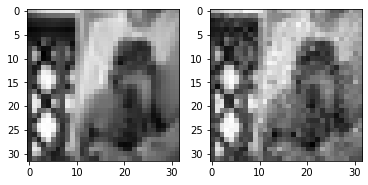

25  :  [0.7765346] 25
50  :  [0.78039664] 25
75  :  [0.8083529] 25
100  :  [0.8083529] 25
125  :  [0.82124686] 25
150  :  [0.82675] 25
175  :  [0.817497] 25
200  :  [0.817497] 25
225  :  [0.817497] 25
250  :  [0.817497] 25
275  :  [0.817497] 25
300  :  [0.817497] 25
325  :  [0.8510809] 25
350  :  [0.8510809] 25
375  :  [0.8510809] 25
400  :  [0.8510809] 25
425  :  [0.8559075] 25
450  :  [0.85604846] 25
475  :  [0.85604846] 25
500  :  [0.85604846] 25
525  :  [0.85604846] 25
550  :  [0.85604846] 25
575  :  [0.85604846] 25
600  :  [0.85604846] 25
625  :  [0.85604846] 25
650  :  [0.85604846] 25
675  :  [0.85604846] 25
700  :  [0.85604846] 25
725  :  [0.85604846] 25
750  :  [0.85604846] 25
775  :  [0.85604846] 25
800  :  [0.85604846] 25
825  :  [0.85604846] 25
850  :  [0.8596282] 25
875  :  [0.858704] 25
900  :  [0.858704] 25
925  :  [0.858704] 25
950  :  [0.858704] 25
975  :  [0.858704] 25
1000  :  [0.858704] 25
1025  :  [0.858704] 25
1050  :  [0.858704] 25
1075  :  [0.858704] 25
1100  :  

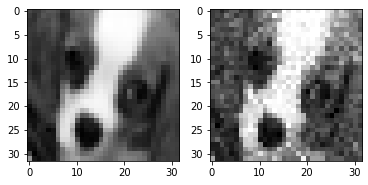

25  :  [0.83415985] 25
50  :  [0.858882] 25
75  :  [0.87778234] 25
100  :  [0.8793342] 25
125  :  [0.8975712] 25
150  :  [0.8975712] 25
175  :  [0.8975712] 25
200  :  [0.8975712] 25
225  :  [0.8975712] 25
250  :  [0.8975712] 25
275  :  [0.8975712] 25
300  :  [0.8975712] 25
325  :  [0.8975712] 25
350  :  [0.8975712] 25
375  :  [0.90132004] 25
400  :  [0.90133154] 25
425  :  [0.90133154] 25
450  :  [0.9016789] 25
475  :  [0.91412115] 25
500  :  [0.91412115] 25
525  :  [0.91412115] 25
550  :  [0.91412115] 25
575  :  [0.91412115] 25
600  :  [0.9144541] 25
625  :  [0.9144541] 25
650  :  [0.91612846] 25
675  :  [0.9173349] 25
700  :  [0.91834056] 25
725  :  [0.91834056] 25
750  :  [0.91834056] 25
775  :  [0.91834056] 25
800  :  [0.9196155] 25
825  :  [0.9209813] 25
850  :  [0.9222406] 25
875  :  [0.9222406] 25
900  :  [0.9224416] 25
925  :  [0.9224973] 25
950  :  [0.92332006] 25
975  :  [0.9235227] 25
1000  :  [0.9236297] 25
1025  :  [0.9239216] 25
1050  :  [0.9239216] 25
1075  :  [0.9239216

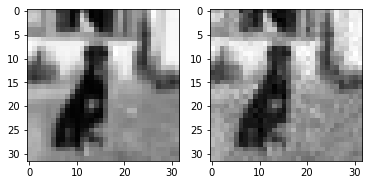

25  :  [0.76183796] 25
50  :  [0.79896265] 25
75  :  [0.7978125] 25
100  :  [0.7978125] 25
125  :  [0.7978125] 25
150  :  [0.7978125] 25
175  :  [0.7978125] 25
200  :  [0.7978125] 25
225  :  [0.7978125] 25
250  :  [0.7978125] 25
275  :  [0.80054766] 25
300  :  [0.80054766] 25
325  :  [0.80054766] 25
350  :  [0.80054766] 25
375  :  [0.80054766] 25
400  :  [0.8037951] 25
425  :  [0.8112339] 25
450  :  [0.8112339] 25
475  :  [0.8112339] 25
500  :  [0.8112339] 25
525  :  [0.81745696] 25
550  :  [0.83351684] 25
575  :  [0.83351684] 25
600  :  [0.8427122] 25
625  :  [0.8427122] 25
650  :  [0.8427122] 25
675  :  [0.8471668] 25
700  :  [0.8471668] 25
725  :  [0.8471668] 25
750  :  [0.8471668] 25
775  :  [0.84733516] 25
800  :  [0.8480096] 25
825  :  [0.85057175] 25
850  :  [0.85057175] 25
875  :  [0.8536583] 25
900  :  [0.8544057] 25
925  :  [0.855881] 25
950  :  [0.858675] 25
975  :  [0.85927874] 25
1000  :  [0.85966754] 25
1025  :  [0.860343] 25
1050  :  [0.86164486] 25
1075  :  [0.86164486]

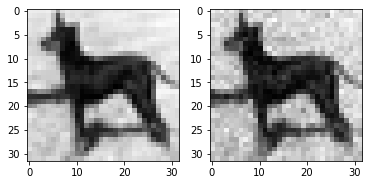

25  :  [0.8508642] 25
50  :  [0.8516722] 25
75  :  [0.8516722] 25
100  :  [0.858201] 25
125  :  [0.858201] 25
150  :  [0.858201] 25
175  :  [0.858201] 25
200  :  [0.858201] 25
225  :  [0.858201] 25
250  :  [0.858201] 25
275  :  [0.86489797] 25
300  :  [0.8658733] 25
325  :  [0.8666409] 25
350  :  [0.8666409] 25
375  :  [0.87370795] 25
400  :  [0.87375957] 25
425  :  [0.8753115] 25
450  :  [0.8753115] 25
475  :  [0.8753115] 25
500  :  [0.8753115] 25
525  :  [0.87879753] 25
550  :  [0.87896824] 25
575  :  [0.8789617] 25
600  :  [0.8789617] 25
625  :  [0.87910503] 25
650  :  [0.8807991] 25
675  :  [0.89030135] 25
700  :  [0.89030135] 25
725  :  [0.89030135] 25
750  :  [0.8903854] 25
775  :  [0.8980868] 25
800  :  [0.8980868] 25
Time:  109.91858196258545  seconds
Original class:  5
Prediction for normal image:  [5]
Prediction for adversarial image:  [3]


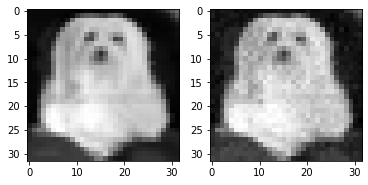

25  :  [0.8659147] 25
50  :  [0.8659147] 25
75  :  [0.88792264] 25
100  :  [0.88658357] 25
125  :  [0.8905668] 25
150  :  [0.89173055] 25
175  :  [0.89173055] 25
200  :  [0.8972907] 25
225  :  [0.8972907] 25
250  :  [0.9067566] 25
275  :  [0.9225829] 25
300  :  [0.9224145] 25
325  :  [0.9224145] 25
350  :  [0.9224145] 25
375  :  [0.9224145] 25
400  :  [0.9224145] 25
425  :  [0.9224145] 25
450  :  [0.9252157] 25
475  :  [0.9252157] 25
500  :  [0.9252157] 25
525  :  [0.9252157] 25
550  :  [0.92564857] 25
575  :  [0.92602855] 25
600  :  [0.9259845] 25
625  :  [0.9259845] 25
650  :  [0.9333987] 25
675  :  [0.9360616] 25
700  :  [0.93616754] 25
725  :  [0.9376874] 25
750  :  [0.93778694] 25
775  :  [0.93778694] 25
800  :  [0.93778694] 25
825  :  [0.9414973] 25
850  :  [0.9414973] 25
875  :  [0.9416903] 25
900  :  [0.9416903] 25
925  :  [0.94702005] 25
950  :  [0.94702005] 25
975  :  [0.94731736] 25
1000  :  [0.94731736] 25
1025  :  [0.94731736] 25
1050  :  [0.9479381] 25
Time:  141.98225116

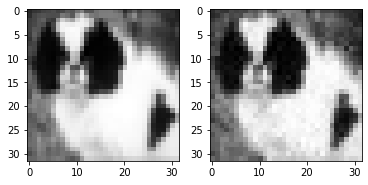

25  :  [0.83093596] 25
50  :  [0.83767587] 25
75  :  [0.8393593] 25
100  :  [0.8433644] 25
125  :  [0.85099757] 25
150  :  [0.8657382] 25
175  :  [0.8657382] 25
200  :  [0.8657382] 25
225  :  [0.8657382] 25
250  :  [0.8657382] 25
275  :  [0.86655694] 25
300  :  [0.86655694] 25
325  :  [0.86655694] 25
350  :  [0.87903976] 25
375  :  [0.88162136] 25
400  :  [0.88162136] 25
425  :  [0.88833714] 25
450  :  [0.8927623] 25
475  :  [0.8953967] 25
500  :  [0.8953967] 25
525  :  [0.89788634] 25
550  :  [0.8999288] 25
575  :  [0.9056927] 25
600  :  [0.9065402] 25
625  :  [0.9065402] 25
650  :  [0.9065402] 25
675  :  [0.9072796] 25
700  :  [0.9078133] 25
725  :  [0.9104208] 25
750  :  [0.9125147] 25
775  :  [0.9125147] 25
800  :  [0.9131154] 25
825  :  [0.9131154] 25
850  :  [0.9131154] 25
875  :  [0.9137951] 25
900  :  [0.9145299] 25
925  :  [0.9151508] 25
950  :  [0.9151508] 25
975  :  [0.9159278] 25
1000  :  [0.9162327] 25
1025  :  [0.9162327] 25
1050  :  [0.9175055] 25
1075  :  [0.9175055] 25

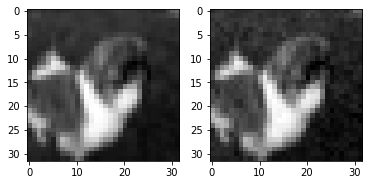

25  :  [0.56891644] 25
50  :  [0.56891644] 25
75  :  [0.6001037] 25
100  :  [0.6001037] 25
125  :  [0.6001037] 25
150  :  [0.6001037] 25
175  :  [0.6001037] 25
200  :  [0.6001037] 25
225  :  [0.60927457] 25
250  :  [0.60725796] 25
275  :  [0.61723053] 25
300  :  [0.631335] 25
325  :  [0.6536144] 25
350  :  [0.6603973] 25
375  :  [0.689661] 25
400  :  [0.69969213] 25
425  :  [0.7046857] 25
450  :  [0.71110827] 25
475  :  [0.71110827] 25
500  :  [0.7141381] 25
525  :  [0.7333908] 25
550  :  [0.7405246] 25
575  :  [0.74623173] 25
600  :  [0.746418] 25
625  :  [0.7475238] 25
650  :  [0.7576882] 25
675  :  [0.7576882] 25
700  :  [0.7621525] 25
725  :  [0.76727116] 25
750  :  [0.76727116] 25
775  :  [0.7675537] 25
800  :  [0.77696854] 25
825  :  [0.77696854] 25
850  :  [0.77832866] 25
875  :  [0.7787287] 25
900  :  [0.7814491] 25
925  :  [0.7814491] 25
950  :  [0.7814491] 25
975  :  [0.7814491] 25
1000  :  [0.78234875] 25
1025  :  [0.7859297] 25
1050  :  [0.7861847] 25
1075  :  [0.7861847] 2

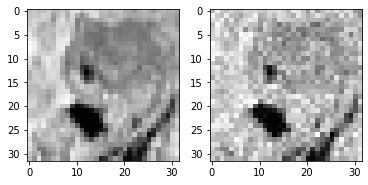

25  :  [0.7117655] 25
50  :  [0.7117655] 25
75  :  [0.71345556] 25
100  :  [0.8011775] 25
125  :  [0.8011775] 25
150  :  [0.82290936] 25
175  :  [0.82290936] 25
200  :  [0.82290936] 25
225  :  [0.82290936] 25
250  :  [0.82290936] 25
275  :  [0.8235865] 25
300  :  [0.8235865] 25
325  :  [0.8235865] 25
350  :  [0.8235865] 25
375  :  [0.8235865] 25
400  :  [0.8235865] 25
425  :  [0.8235865] 25
450  :  [0.82369214] 25
475  :  [0.82369214] 25
500  :  [0.82369214] 25
525  :  [0.82369214] 25
550  :  [0.82369214] 25
575  :  [0.82369214] 25
600  :  [0.82369214] 25
625  :  [0.83747053] 25
650  :  [0.83747053] 25
675  :  [0.83747053] 25
700  :  [0.83747053] 25
725  :  [0.83747053] 25
750  :  [0.8499267] 25
775  :  [0.8499267] 25
800  :  [0.8499267] 25
825  :  [0.8499267] 25
850  :  [0.8499267] 25
875  :  [0.8499267] 25
900  :  [0.8499267] 25
925  :  [0.8517699] 25
950  :  [0.8517699] 25
975  :  [0.8551067] 25
1000  :  [0.85881424] 25
1025  :  [0.8594301] 25
1050  :  [0.8594301] 25
1075  :  [0.860

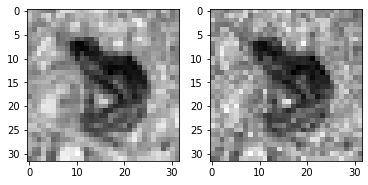

25  :  [0.71516085] 25
50  :  [0.7291668] 25
75  :  [0.7842034] 25
100  :  [0.7842034] 25
125  :  [0.78620875] 25
150  :  [0.78620875] 25
175  :  [0.78620875] 25
200  :  [0.78620875] 25
225  :  [0.78620875] 25
250  :  [0.78620875] 25
275  :  [0.78620875] 25
300  :  [0.7880766] 25
325  :  [0.80450654] 25
350  :  [0.80450654] 25
375  :  [0.80738705] 25
400  :  [0.8210567] 25
425  :  [0.8210567] 25
450  :  [0.8224937] 25
475  :  [0.8230183] 25
500  :  [0.8390341] 25
525  :  [0.8390341] 25
550  :  [0.84399307] 25
575  :  [0.84766656] 25
600  :  [0.8535515] 25
625  :  [0.85882163] 25
650  :  [0.86763316] 25
675  :  [0.86763316] 25
700  :  [0.86763316] 25
725  :  [0.86946714] 25
750  :  [0.8701141] 25
775  :  [0.8804245] 25
800  :  [0.8804245] 25
825  :  [0.8804245] 25
850  :  [0.88218445] 25
875  :  [0.8828925] 25
900  :  [0.8828925] 25
925  :  [0.8849189] 25
950  :  [0.8849189] 25
975  :  [0.88619685] 25
1000  :  [0.88635015] 25
1025  :  [0.88710123] 25
1050  :  [0.88710123] 25
1075  :  [0

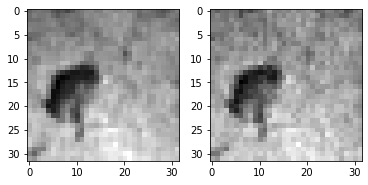

25  :  [0.5082676] 25
50  :  [0.6626041] 25
75  :  [0.57944995] 25
100  :  [0.66496897] 25
125  :  [0.66496897] 25
150  :  [0.66496897] 25
175  :  [0.66496897] 25
200  :  [0.66496897] 25
225  :  [0.66496897] 25
250  :  [0.66496897] 25
275  :  [0.66496897] 25
300  :  [0.66496897] 25
325  :  [0.66496897] 25
350  :  [0.66496897] 25
375  :  [0.66496897] 25
400  :  [0.66496897] 25
425  :  [0.68298167] 25
450  :  [0.6846765] 25
475  :  [0.6918727] 25
500  :  [0.6918727] 25
525  :  [0.6918727] 25
550  :  [0.7220775] 25
575  :  [0.7307339] 25
600  :  [0.7314627] 25
625  :  [0.7421193] 25
650  :  [0.7444599] 25
675  :  [0.7565268] 25
700  :  [0.7630532] 25
725  :  [0.7630532] 25
750  :  [0.76673007] 25
775  :  [0.76673007] 25
800  :  [0.76673007] 25
825  :  [0.76673007] 25
850  :  [0.76770496] 25
875  :  [0.7698798] 25
900  :  [0.7698798] 25
925  :  [0.7733824] 25
950  :  [0.7733824] 25
975  :  [0.7733824] 25
1000  :  [0.7739626] 25
1025  :  [0.7739626] 25
1050  :  [0.7748294] 25
1075  :  [0.77

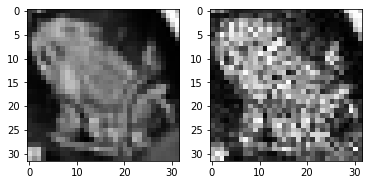

25  :  [0.61789286] 25
50  :  [0.61789286] 25
75  :  [0.6024709] 25
100  :  [0.6024709] 25
125  :  [0.6024709] 25
150  :  [0.6024709] 25
175  :  [0.6024709] 25
200  :  [0.6024709] 25
225  :  [0.6024709] 25
250  :  [0.6024709] 25
275  :  [0.6024709] 25
300  :  [0.6024709] 25
325  :  [0.6024709] 25
350  :  [0.6024709] 25
375  :  [0.6112426] 25
400  :  [0.6112426] 25
425  :  [0.6112426] 25
450  :  [0.6112426] 25
475  :  [0.6112426] 25
500  :  [0.6162051] 25
525  :  [0.6112426] 25
550  :  [0.6112426] 25
575  :  [0.6112426] 25
600  :  [0.6245613] 25
625  :  [0.6245613] 25
650  :  [0.6245613] 25
675  :  [0.6245613] 25
700  :  [0.6245613] 25
725  :  [0.6245613] 25
750  :  [0.6245613] 25
775  :  [0.6245613] 25
800  :  [0.6245613] 25
825  :  [0.6245613] 25
850  :  [0.6245613] 25
875  :  [0.6245613] 25
900  :  [0.6245613] 25
925  :  [0.6245613] 25
950  :  [0.6245613] 25
975  :  [0.6245613] 25
1000  :  [0.6245613] 25
1025  :  [0.6245613] 25
1050  :  [0.6245613] 25
1075  :  [0.6245613] 25
1100  : 

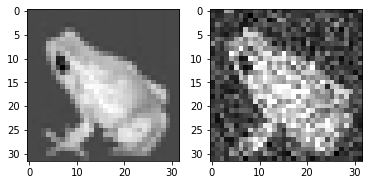

25  :  [0.36780667] 25
50  :  [0.5177913] 25
75  :  [0.55825424] 25
100  :  [0.5769021] 25
125  :  [0.5769021] 25
150  :  [0.5848599] 25
175  :  [0.58729947] 25
200  :  [0.5952775] 25
225  :  [0.60089695] 25
250  :  [0.60476476] 25
275  :  [0.6058043] 25
300  :  [0.6092832] 25
325  :  [0.6092832] 25
350  :  [0.6117449] 25
375  :  [0.61450005] 25
400  :  [0.622305] 25
425  :  [0.6235638] 25
450  :  [0.6243148] 25
475  :  [0.6242589] 25
500  :  [0.6300776] 25
525  :  [0.63051355] 25
550  :  [0.6307311] 25
575  :  [0.63113016] 25
600  :  [0.6332414] 25
625  :  [0.6334261] 25
650  :  [0.6334261] 25
675  :  [0.63449097] 25
700  :  [0.6351043] 25
725  :  [0.6366208] 25
750  :  [0.6371739] 25
775  :  [0.6415875] 25
800  :  [0.6427182] 25
825  :  [0.6427182] 25
850  :  [0.6441541] 25
875  :  [0.6441839] 25
Time:  125.79369401931763  seconds
Original class:  6
Prediction for normal image:  [6]
Prediction for adversarial image:  [0]


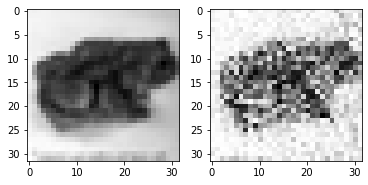

25  :  [0.6444513] 25
50  :  [0.73304725] 25
75  :  [0.77387] 25
100  :  [0.77387] 25
125  :  [0.803965] 25
150  :  [0.82995075] 25
175  :  [0.8300934] 25
200  :  [0.83184224] 25
225  :  [0.83184224] 25
250  :  [0.83184224] 25
275  :  [0.83184224] 25
300  :  [0.83184224] 25
325  :  [0.83184224] 25
350  :  [0.83184224] 25
375  :  [0.83184224] 25
400  :  [0.83184224] 25
425  :  [0.8538098] 25
450  :  [0.8538098] 25
475  :  [0.8538098] 25
500  :  [0.8538098] 25
525  :  [0.8538098] 25
550  :  [0.854774] 25
575  :  [0.854774] 25
600  :  [0.854774] 25
625  :  [0.856772] 25
650  :  [0.85889983] 25
675  :  [0.85889983] 25
700  :  [0.85889983] 25
725  :  [0.85889983] 25
750  :  [0.8597892] 25
775  :  [0.8618275] 25
800  :  [0.8618275] 25
825  :  [0.86443245] 25
850  :  [0.8655297] 25
875  :  [0.8684236] 25
900  :  [0.8684236] 25
925  :  [0.86939645] 25
950  :  [0.87040585] 25
975  :  [0.87122405] 25
1000  :  [0.873752] 25
1025  :  [0.8739382] 25
1050  :  [0.8739382] 25
1075  :  [0.8739382] 25
1

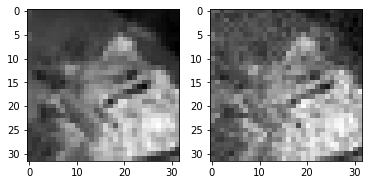

25  :  [0.43509066] 25
50  :  [0.5427849] 25
75  :  [0.468699] 25
100  :  [0.53010094] 25
125  :  [0.54698426] 25
150  :  [0.54698426] 25
175  :  [0.561463] 25
200  :  [0.5714351] 25
225  :  [0.57397735] 25
250  :  [0.56765294] 25
275  :  [0.56765294] 25
300  :  [0.56765294] 25
325  :  [0.56765294] 25
350  :  [0.5872183] 25
375  :  [0.56765294] 25
400  :  [0.56936777] 25
425  :  [0.56936777] 25
450  :  [0.57519954] 25
475  :  [0.56936777] 25
500  :  [0.5782759] 25
525  :  [0.5782759] 25
550  :  [0.5782759] 25
575  :  [0.5782759] 25
600  :  [0.5791901] 25
625  :  [0.5791901] 25
650  :  [0.5791901] 25
675  :  [0.5791901] 25
700  :  [0.5791901] 25
725  :  [0.5791901] 25
750  :  [0.59220326] 25
775  :  [0.591566] 25
800  :  [0.591566] 25
825  :  [0.5929227] 25
850  :  [0.5929227] 25
875  :  [0.5976597] 25
900  :  [0.5981627] 25
925  :  [0.60951036] 25
950  :  [0.6096919] 25
975  :  [0.6096919] 25
1000  :  [0.6096919] 25
1025  :  [0.62981313] 25
1050  :  [0.6298502] 25
1075  :  [0.6298502] 

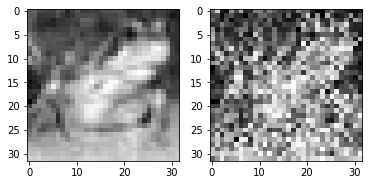

25  :  [0.47691056] 25
50  :  [0.7014797] 25
75  :  [0.7132715] 25
100  :  [0.7132715] 25
125  :  [0.7132715] 25
150  :  [0.7132715] 25
175  :  [0.7132715] 25
200  :  [0.7132715] 25
225  :  [0.7132715] 25
250  :  [0.7132715] 25
275  :  [0.7132715] 25
300  :  [0.7132715] 25
325  :  [0.7132715] 25
350  :  [0.7132715] 25
375  :  [0.7132715] 25
400  :  [0.7132715] 25
425  :  [0.7132715] 25
450  :  [0.7132715] 25
475  :  [0.75568223] 25
500  :  [0.754161] 25
525  :  [0.754161] 25
550  :  [0.754161] 25
575  :  [0.754161] 25
600  :  [0.7861453] 25
625  :  [0.78168267] 25
650  :  [0.78168267] 25
675  :  [0.78168267] 25
700  :  [0.7945572] 25
725  :  [0.7945572] 25
750  :  [0.7945572] 25
775  :  [0.7945572] 25
800  :  [0.8022475] 25
825  :  [0.8022339] 25
850  :  [0.8022339] 25
875  :  [0.8022339] 25
900  :  [0.8022339] 25
925  :  [0.8022339] 25
950  :  [0.8022339] 25
975  :  [0.8022339] 25
1000  :  [0.8022339] 25
1025  :  [0.8022339] 25
1050  :  [0.8022339] 25
1075  :  [0.8022339] 25
1100  :  

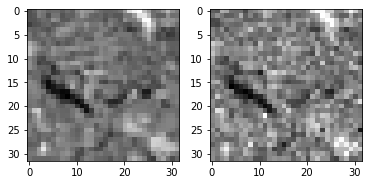

25  :  [0.38285547] 25
50  :  [0.38285547] 25
75  :  [0.519905] 25
100  :  [0.59890676] 25
125  :  [0.59890676] 25
150  :  [0.61977077] 25
175  :  [0.61977077] 25
200  :  [0.61977077] 25
225  :  [0.64458156] 25
250  :  [0.68322134] 25
275  :  [0.75393987] 25
300  :  [0.75393987] 25
325  :  [0.75393987] 25
350  :  [0.75393987] 25
375  :  [0.75393987] 25
400  :  [0.75393987] 25
425  :  [0.75393987] 25
450  :  [0.7644868] 25
475  :  [0.7648822] 25
500  :  [0.7648822] 25
525  :  [0.7648822] 25
550  :  [0.7648822] 25
575  :  [0.7648822] 25
600  :  [0.7648822] 25
625  :  [0.7668679] 25
650  :  [0.7727345] 25
675  :  [0.77279675] 25
700  :  [0.77279675] 25
725  :  [0.7829827] 25
750  :  [0.7838638] 25
775  :  [0.7838638] 25
800  :  [0.78990775] 25
825  :  [0.78990775] 25
850  :  [0.79764044] 25
875  :  [0.79764044] 25
900  :  [0.79764044] 25
925  :  [0.79764044] 25
950  :  [0.79764044] 25
975  :  [0.80451274] 25
1000  :  [0.8066387] 25
1025  :  [0.8066387] 25
1050  :  [0.8066387] 25
1075  :  

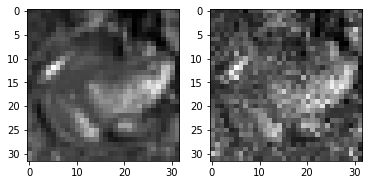

25  :  [0.31877983] 25
50  :  [0.31877983] 25
75  :  [0.6013976] 25
100  :  [0.6013976] 25
125  :  [0.6013976] 25
150  :  [0.6013976] 25
175  :  [0.67325133] 25
200  :  [0.67325133] 25
225  :  [0.67325133] 25
250  :  [0.67325133] 25
275  :  [0.67325133] 25
300  :  [0.67325133] 25
325  :  [0.68596685] 25
350  :  [0.6838448] 25
375  :  [0.6838448] 25
400  :  [0.6838448] 25
425  :  [0.6838448] 25
450  :  [0.7144276] 25
475  :  [0.7144276] 25
500  :  [0.7144276] 25
525  :  [0.7144276] 25
550  :  [0.7144276] 25
575  :  [0.7144276] 25
600  :  [0.7144276] 25
625  :  [0.7144276] 25
650  :  [0.7144276] 25
675  :  [0.7144276] 25
700  :  [0.7144276] 25
725  :  [0.7144276] 25
750  :  [0.7144276] 25
775  :  [0.76012814] 25
800  :  [0.76995265] 25
825  :  [0.76995265] 25
850  :  [0.76995265] 25
875  :  [0.76995265] 25
900  :  [0.76995265] 25
925  :  [0.76995265] 25
950  :  [0.76995265] 25
975  :  [0.76995265] 25
1000  :  [0.76995265] 25
1025  :  [0.77137625] 25
1050  :  [0.77137625] 25
1075  :  [0.7

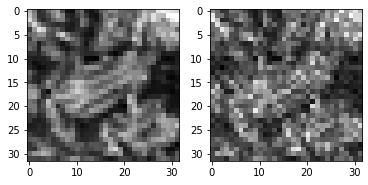

25  :  [0.31782416] 25
50  :  [0.51139265] 25
75  :  [0.44444293] 25
100  :  [0.42990395] 25
125  :  [0.5470982] 25
150  :  [0.48020837] 25
175  :  [0.5467081] 25
200  :  [0.5679736] 25
225  :  [0.56361705] 25
250  :  [0.57540864] 25
275  :  [0.56894076] 25
300  :  [0.62680054] 25
325  :  [0.64082086] 25
350  :  [0.64082086] 25
375  :  [0.64082086] 25
400  :  [0.64082086] 25
425  :  [0.64082086] 25
450  :  [0.64082086] 25
475  :  [0.64082086] 25
500  :  [0.64082086] 25
525  :  [0.64082086] 25
550  :  [0.64082086] 25
575  :  [0.64082086] 25
600  :  [0.64082086] 25
625  :  [0.64082086] 25
650  :  [0.64082086] 25
675  :  [0.64082086] 25
700  :  [0.64082086] 25
725  :  [0.64082086] 25
750  :  [0.64082086] 25
775  :  [0.64082086] 25
800  :  [0.64082086] 25
825  :  [0.64082086] 25
850  :  [0.64082086] 25
875  :  [0.64082086] 25
900  :  [0.64082086] 25
925  :  [0.64082086] 25
950  :  [0.6424925] 25
975  :  [0.68059814] 25
1000  :  [0.6718054] 25
1025  :  [0.6718054] 25
1050  :  [0.6718054] 25

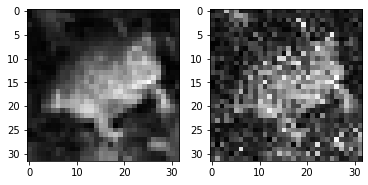

25  :  [0.0528398] 25
50  :  [0.5368961] 25
75  :  [0.651777] 25
100  :  [0.651777] 25
125  :  [0.651777] 25
150  :  [0.651777] 25
175  :  [0.651777] 25
200  :  [0.651777] 25
225  :  [0.651777] 25
250  :  [0.651777] 25
275  :  [0.651777] 25
300  :  [0.651777] 25
325  :  [0.651777] 25
350  :  [0.651777] 25
375  :  [0.651777] 25
400  :  [0.651777] 25
425  :  [0.651777] 25
450  :  [0.651777] 25
475  :  [0.651777] 25
500  :  [0.651777] 25
525  :  [0.651777] 25
550  :  [0.651777] 25
575  :  [0.651777] 25
600  :  [0.651777] 25
625  :  [0.651777] 25
650  :  [0.65281373] 25
675  :  [0.65818995] 25
700  :  [0.6734869] 25
725  :  [0.6734869] 25
750  :  [0.6734869] 25
775  :  [0.69099396] 25
800  :  [0.69099396] 25
825  :  [0.6952112] 25
850  :  [0.6950557] 25
875  :  [0.7097667] 25
900  :  [0.710778] 25
925  :  [0.7119593] 25
950  :  [0.7120646] 25
975  :  [0.72020525] 25
1000  :  [0.73282164] 25
1025  :  [0.7385253] 25
1050  :  [0.7414778] 25
1075  :  [0.7414778] 25
1100  :  [0.7414778] 25
1125

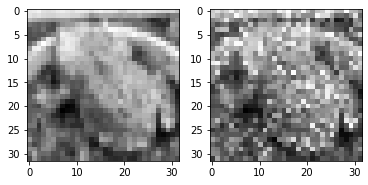

25  :  [0.67307746] 25
50  :  [0.6950394] 25
75  :  [0.6793144] 25
100  :  [0.68971735] 25
125  :  [0.68971735] 25
150  :  [0.68971735] 25
175  :  [0.68971735] 25
200  :  [0.68971735] 25
225  :  [0.68971735] 25
250  :  [0.68971735] 25
275  :  [0.68971735] 25
300  :  [0.68971735] 25
325  :  [0.68971735] 25
350  :  [0.68971735] 25
375  :  [0.68971735] 25
400  :  [0.68971735] 25
425  :  [0.68971735] 25
450  :  [0.68971735] 25
475  :  [0.68971735] 25
500  :  [0.68971735] 25
525  :  [0.68971735] 25
550  :  [0.68971735] 25
575  :  [0.68971735] 25
600  :  [0.68971735] 25
625  :  [0.68971735] 25
650  :  [0.68971735] 25
675  :  [0.68971735] 25
700  :  [0.68971735] 25
725  :  [0.68971735] 25
750  :  [0.68971735] 25
775  :  [0.68971735] 25
800  :  [0.68971735] 25
825  :  [0.68971735] 25
850  :  [0.68971735] 25
875  :  [0.68971735] 25
Time:  119.48062038421631  seconds
Original class:  7
Prediction for normal image:  [7]
Prediction for adversarial image:  [0]


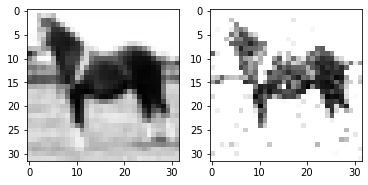

25  :  [0.7402187] 25
50  :  [0.7521528] 25
75  :  [0.7524587] 25
100  :  [0.75825673] 25
125  :  [0.76136637] 25
150  :  [0.7645898] 25
175  :  [0.7645898] 25
200  :  [0.77534544] 25
225  :  [0.787485] 25
250  :  [0.78844464] 25
275  :  [0.78844464] 25
300  :  [0.78844464] 25
325  :  [0.78880835] 25
350  :  [0.7887385] 25
375  :  [0.79014415] 25
400  :  [0.7914591] 25
425  :  [0.79607534] 25
450  :  [0.8020787] 25
475  :  [0.81341594] 25
500  :  [0.81381184] 25
525  :  [0.81381184] 25
550  :  [0.8157844] 25
575  :  [0.8158645] 25
600  :  [0.8158645] 25
625  :  [0.8170605] 25
650  :  [0.8228061] 25
675  :  [0.82531744] 25
700  :  [0.82531846] 25
725  :  [0.8282755] 25
750  :  [0.82944703] 25
775  :  [0.83314854] 25
800  :  [0.83351886] 25
825  :  [0.8372152] 25
850  :  [0.8372152] 25
875  :  [0.8418813] 25
900  :  [0.8418813] 25
925  :  [0.8418813] 25
950  :  [0.8422159] 25
975  :  [0.8471236] 25
1000  :  [0.8471236] 25
1025  :  [0.8481432] 25
1050  :  [0.8481432] 25
1075  :  [0.848143

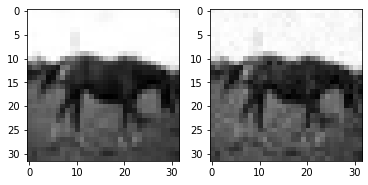

25  :  [0.8131758] 25
50  :  [0.82121724] 25
75  :  [0.82133883] 25
100  :  [0.8215443] 25
125  :  [0.8215443] 25
150  :  [0.8215443] 25
175  :  [0.8215443] 25
200  :  [0.824681] 25
225  :  [0.83268094] 25
250  :  [0.83268094] 25
275  :  [0.83268094] 25
300  :  [0.8349583] 25
325  :  [0.8349583] 25
350  :  [0.8349583] 25
375  :  [0.8349583] 25
400  :  [0.840554] 25
425  :  [0.840554] 25
450  :  [0.840554] 25
475  :  [0.8452648] 25
500  :  [0.8452648] 25
525  :  [0.8452648] 25
550  :  [0.8452648] 25
575  :  [0.8462741] 25
600  :  [0.8467264] 25
625  :  [0.8482551] 25
650  :  [0.8482551] 25
675  :  [0.8488337] 25
700  :  [0.85042673] 25
725  :  [0.85042673] 25
750  :  [0.8513791] 25
775  :  [0.85278916] 25
800  :  [0.85278916] 25
Time:  109.00055766105652  seconds
Original class:  7
Prediction for normal image:  [7]
Prediction for adversarial image:  [6]


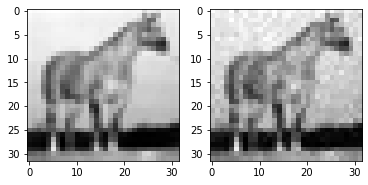

25  :  [0.7908217] 25
50  :  [0.804288] 25
75  :  [0.80463475] 25
100  :  [0.80463475] 25
125  :  [0.80463475] 25
150  :  [0.8047619] 25
175  :  [0.80463475] 25
200  :  [0.80463475] 25
225  :  [0.80463475] 25
250  :  [0.81879824] 25
275  :  [0.81832445] 25
300  :  [0.81832445] 25
325  :  [0.8194418] 25
350  :  [0.8364035] 25
375  :  [0.8357183] 25
400  :  [0.8357183] 25
425  :  [0.8449525] 25
450  :  [0.8449525] 25
475  :  [0.8449525] 25
500  :  [0.8449525] 25
525  :  [0.8629297] 25
550  :  [0.8629297] 25
575  :  [0.8629297] 25
600  :  [0.8629297] 25
625  :  [0.8695737] 25
650  :  [0.8695737] 25
675  :  [0.8695737] 25
700  :  [0.8695737] 25
725  :  [0.8695737] 25
750  :  [0.8695737] 25
775  :  [0.8695737] 25
800  :  [0.8695737] 25
825  :  [0.87221617] 25
850  :  [0.87221617] 25
875  :  [0.87221617] 25
900  :  [0.87221617] 25
925  :  [0.87221617] 25
950  :  [0.8791182] 25
975  :  [0.88259184] 25
1000  :  [0.8839164] 25
1025  :  [0.8839164] 25
1050  :  [0.88764393] 25
1075  :  [0.8878785

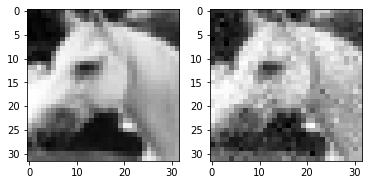

25  :  [0.7224531] 25
50  :  [0.72917473] 25
75  :  [0.7296046] 25
100  :  [0.73242414] 25
125  :  [0.7396585] 25
150  :  [0.7420066] 25
175  :  [0.7420066] 25
200  :  [0.7420066] 25
225  :  [0.7420066] 25
250  :  [0.7497363] 25
275  :  [0.7497363] 25
300  :  [0.7497363] 25
325  :  [0.76217705] 25
350  :  [0.7731998] 25
375  :  [0.7738558] 25
400  :  [0.7738558] 25
425  :  [0.7738558] 25
450  :  [0.7738558] 25
475  :  [0.7738558] 25
500  :  [0.7738558] 25
525  :  [0.7766689] 25
550  :  [0.7784463] 25
575  :  [0.7786001] 25
600  :  [0.7786001] 25
625  :  [0.7786001] 25
650  :  [0.78142214] 25
675  :  [0.7834005] 25
700  :  [0.7832869] 25
725  :  [0.7832869] 25
750  :  [0.78784573] 25
775  :  [0.7881545] 25
800  :  [0.78979576] 25
825  :  [0.78987986] 25
850  :  [0.794754] 25
875  :  [0.794754] 25
900  :  [0.794754] 25
925  :  [0.794754] 25
950  :  [0.794754] 25
975  :  [0.794754] 25
1000  :  [0.794754] 25
1025  :  [0.794754] 25
1050  :  [0.794754] 25
1075  :  [0.79962885] 25
1100  :  [0

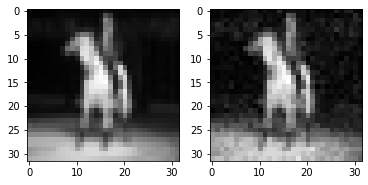

25  :  [0.6897311] 25
50  :  [0.7081133] 25
75  :  [0.7549927] 25
100  :  [0.76713836] 25
125  :  [0.76713836] 25
150  :  [0.76713836] 25
175  :  [0.76713836] 25
200  :  [0.76713836] 25
225  :  [0.76713836] 25
250  :  [0.76713836] 25
275  :  [0.771383] 25
300  :  [0.771383] 25
325  :  [0.77150726] 25
350  :  [0.77150726] 25
375  :  [0.7755928] 25
400  :  [0.7808635] 25
425  :  [0.78886175] 25
450  :  [0.78886175] 25
475  :  [0.78886175] 25
500  :  [0.78886175] 25
525  :  [0.79600453] 25
550  :  [0.7966989] 25
575  :  [0.7966989] 25
600  :  [0.8047825] 25
625  :  [0.8047825] 25
650  :  [0.8066259] 25
675  :  [0.81024766] 25
700  :  [0.81024766] 25
725  :  [0.81024766] 25
750  :  [0.81024766] 25
775  :  [0.81024766] 25
800  :  [0.8173258] 25
825  :  [0.8184661] 25
850  :  [0.8184661] 25
875  :  [0.8219727] 25
Time:  126.4077308177948  seconds
Original class:  7
Prediction for normal image:  [7]
Prediction for adversarial image:  [4]


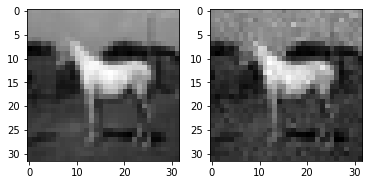

25  :  [0.8368976] 25
50  :  [0.8594954] 25
75  :  [0.8594954] 25
100  :  [0.863264] 25
125  :  [0.86322236] 25
150  :  [0.86322236] 25
175  :  [0.86322236] 25
200  :  [0.8643565] 25
225  :  [0.8643565] 25
250  :  [0.8670495] 25
275  :  [0.87614906] 25
300  :  [0.87614906] 25
325  :  [0.88006544] 25
350  :  [0.88006544] 25
375  :  [0.88006544] 25
400  :  [0.89183617] 25
425  :  [0.89183617] 25
450  :  [0.89183617] 25
475  :  [0.89183617] 25
500  :  [0.89183617] 25
525  :  [0.89485514] 25
550  :  [0.9105396] 25
575  :  [0.9105396] 25
600  :  [0.9105396] 25
625  :  [0.9118917] 25
650  :  [0.9118917] 25
675  :  [0.9153164] 25
700  :  [0.9153164] 25
725  :  [0.9153164] 25
750  :  [0.91746724] 25
775  :  [0.92259085] 25
800  :  [0.92259085] 25
825  :  [0.9227501] 25
850  :  [0.9252691] 25
875  :  [0.9252691] 25
900  :  [0.9252691] 25
925  :  [0.9253557] 25
950  :  [0.9277427] 25
975  :  [0.9285792] 25
1000  :  [0.9308877] 25
1025  :  [0.9313158] 25
1050  :  [0.9313158] 25
1075  :  [0.933119

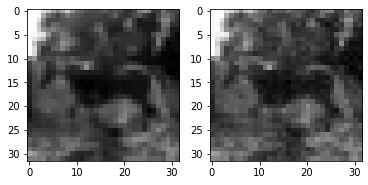

25  :  [0.9571489] 25
50  :  [0.9571489] 25
75  :  [0.9623395] 25
100  :  [0.9624021] 25
125  :  [0.9624021] 25
150  :  [0.9624021] 25
175  :  [0.9624021] 25
200  :  [0.9653799] 25
225  :  [0.9654796] 25
250  :  [0.9686886] 25
275  :  [0.9686613] 25
300  :  [0.9686613] 25
325  :  [0.96936506] 25
350  :  [0.9693806] 25
375  :  [0.9703716] 25
400  :  [0.97244877] 25
425  :  [0.97409046] 25
450  :  [0.9751121] 25
475  :  [0.97527134] 25
500  :  [0.9758183] 25
525  :  [0.97784805] 25
550  :  [0.97882986] 25
575  :  [0.97882986] 25
600  :  [0.97882986] 25
625  :  [0.97882986] 25
650  :  [0.9789455] 25
675  :  [0.97986436] 25
700  :  [0.98062825] 25
725  :  [0.98062825] 25
750  :  [0.98163545] 25
775  :  [0.98163545] 25
800  :  [0.98163545] 25
Time:  115.52857303619385  seconds
Original class:  7
Prediction for normal image:  [9]
Prediction for adversarial image:  [6]


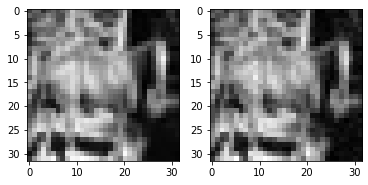

25  :  [0.9084269] 25
50  :  [0.9084269] 25
75  :  [0.92356837] 25
100  :  [0.9290581] 25
125  :  [0.9290581] 25
150  :  [0.9290581] 25
175  :  [0.9311267] 25
200  :  [0.93637264] 25
225  :  [0.944293] 25
250  :  [0.944293] 25
275  :  [0.944293] 25
300  :  [0.944293] 25
325  :  [0.944293] 25
350  :  [0.95416224] 25
375  :  [0.95416224] 25
400  :  [0.9612143] 25
425  :  [0.9612143] 25
450  :  [0.9628423] 25
475  :  [0.9628423] 25
500  :  [0.9647989] 25
525  :  [0.9647989] 25
550  :  [0.9647989] 25
575  :  [0.9647989] 25
600  :  [0.9647989] 25
625  :  [0.9660449] 25
650  :  [0.96619797] 25
675  :  [0.96674293] 25
700  :  [0.9672237] 25
725  :  [0.9675212] 25
750  :  [0.968131] 25
775  :  [0.96907103] 25
800  :  [0.96907103] 25
825  :  [0.96907103] 25
850  :  [0.9695342] 25
Time:  122.52904844284058  seconds
Original class:  7
Prediction for normal image:  [4]
Prediction for adversarial image:  [4]


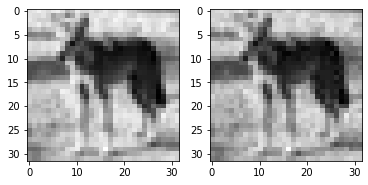

25  :  [0.91719687] 25
50  :  [0.91719687] 25
75  :  [0.91719687] 25
100  :  [0.91719687] 25
125  :  [0.92904985] 25
150  :  [0.92904985] 25
175  :  [0.92904985] 25
200  :  [0.92904985] 25
225  :  [0.92904985] 25
250  :  [0.93273026] 25
275  :  [0.93273026] 25
300  :  [0.93273026] 25
325  :  [0.93739015] 25
350  :  [0.9386673] 25
375  :  [0.9386673] 25
400  :  [0.9386673] 25
425  :  [0.9386673] 25
450  :  [0.9399843] 25
475  :  [0.9399843] 25
500  :  [0.9406665] 25
525  :  [0.94231325] 25
550  :  [0.94231325] 25
575  :  [0.94231325] 25
600  :  [0.9440781] 25
625  :  [0.9489846] 25
650  :  [0.9489846] 25
675  :  [0.9513449] 25
700  :  [0.9513449] 25
725  :  [0.9513449] 25
750  :  [0.95291513] 25
775  :  [0.9533223] 25
800  :  [0.9548942] 25
825  :  [0.9548942] 25
850  :  [0.955131] 25
875  :  [0.95588875] 25
900  :  [0.95588875] 25
Time:  130.05765223503113  seconds
Original class:  7
Prediction for normal image:  [7]
Prediction for adversarial image:  [6]


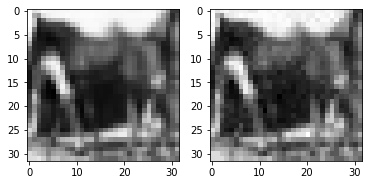

25  :  [0.8872875] 25
50  :  [0.8872875] 25
75  :  [0.8872875] 25
100  :  [0.8872875] 25
125  :  [0.8872875] 25
150  :  [0.8872875] 25
175  :  [0.8872875] 25
200  :  [0.89391243] 25
225  :  [0.89391243] 25
250  :  [0.89391243] 25
275  :  [0.89391243] 25
300  :  [0.89391243] 25
325  :  [0.89391243] 25
350  :  [0.89391243] 25
375  :  [0.89391243] 25
400  :  [0.89391243] 25
425  :  [0.89391243] 25
450  :  [0.89391243] 25
475  :  [0.89391243] 25
500  :  [0.89756763] 25
525  :  [0.89756763] 25
550  :  [0.89756763] 25
575  :  [0.89839405] 25
600  :  [0.901165] 25
625  :  [0.90338516] 25
650  :  [0.9048768] 25
675  :  [0.9053981] 25
700  :  [0.9118804] 25
725  :  [0.9131657] 25
750  :  [0.9134525] 25
775  :  [0.91591084] 25
800  :  [0.91591084] 25
Time:  120.3670301437378  seconds
Original class:  7
Prediction for normal image:  [7]
Prediction for adversarial image:  [6]


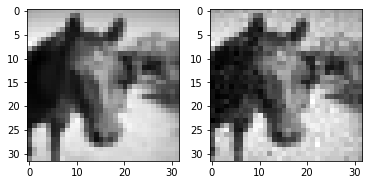

25  :  [0.8253395] 25
50  :  [0.84379894] 25
75  :  [0.84379894] 25
100  :  [0.84379894] 25
125  :  [0.84379894] 25
150  :  [0.84379894] 25
175  :  [0.8442975] 25
200  :  [0.8600696] 25
225  :  [0.8600696] 25
250  :  [0.8600696] 25
275  :  [0.8600696] 25
300  :  [0.8664122] 25
325  :  [0.8712975] 25
350  :  [0.8712975] 25
375  :  [0.8839699] 25
400  :  [0.8839699] 25
425  :  [0.8839699] 25
450  :  [0.88407683] 25
475  :  [0.88492453] 25
500  :  [0.88663435] 25
525  :  [0.8963473] 25
550  :  [0.9008179] 25
575  :  [0.9008179] 25
600  :  [0.9054166] 25
625  :  [0.9057648] 25
650  :  [0.9069699] 25
675  :  [0.9139129] 25
700  :  [0.9139129] 25
725  :  [0.9139129] 25
750  :  [0.9139129] 25
775  :  [0.9139129] 25
800  :  [0.9165733] 25
825  :  [0.92020774] 25
850  :  [0.92020774] 25
875  :  [0.92020774] 25
900  :  [0.92020774] 25
925  :  [0.92030597] 25
950  :  [0.92103803] 25
975  :  [0.9225409] 25
1000  :  [0.9225409] 25
1025  :  [0.92583764] 25
1050  :  [0.9275811] 25
1075  :  [0.9279296

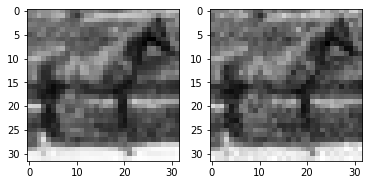

25  :  [0.8115128] 25
50  :  [0.83593667] 25
75  :  [0.8363405] 25
100  :  [0.8363405] 25
125  :  [0.8363405] 25
150  :  [0.8369558] 25
175  :  [0.83691716] 25
200  :  [0.83691716] 25
225  :  [0.83691716] 25
250  :  [0.83691716] 25
275  :  [0.83691716] 25
300  :  [0.8395963] 25
325  :  [0.840708] 25
350  :  [0.8580899] 25
375  :  [0.85808897] 25
400  :  [0.85808897] 25
425  :  [0.85808897] 25
450  :  [0.85808897] 25
475  :  [0.85808897] 25
500  :  [0.85808897] 25
525  :  [0.87131286] 25
550  :  [0.87131286] 25
575  :  [0.87131286] 25
600  :  [0.87131286] 25
625  :  [0.87131286] 25
650  :  [0.87131286] 25
675  :  [0.87172115] 25
700  :  [0.87172115] 25
725  :  [0.87172115] 25
750  :  [0.87210304] 25
775  :  [0.87210304] 25
800  :  [0.87210304] 25
825  :  [0.87713456] 25
850  :  [0.87713456] 25
875  :  [0.8897804] 25
900  :  [0.8897804] 25
925  :  [0.8897804] 25
950  :  [0.8897804] 25
975  :  [0.8897804] 25
1000  :  [0.8897804] 25
1025  :  [0.8897804] 25
1050  :  [0.8897804] 25
1075  :  

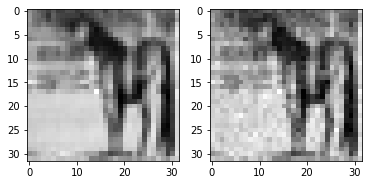

25  :  [0.70084715] 25
50  :  [0.81665057] 25
75  :  [0.81563795] 25
100  :  [0.81563795] 25
125  :  [0.81563795] 25
150  :  [0.81563795] 25
175  :  [0.81563795] 25
200  :  [0.81563795] 25
225  :  [0.81563795] 25
250  :  [0.81563795] 25
275  :  [0.81563795] 25
300  :  [0.81563795] 25
325  :  [0.81563795] 25
350  :  [0.81563795] 25
375  :  [0.81563795] 25
400  :  [0.81563795] 25
425  :  [0.82096756] 25
450  :  [0.82096756] 25
475  :  [0.8235456] 25
500  :  [0.82362545] 25
525  :  [0.82385236] 25
550  :  [0.8293905] 25
575  :  [0.8294549] 25
600  :  [0.8294549] 25
625  :  [0.8294549] 25
650  :  [0.8329948] 25
675  :  [0.833001] 25
700  :  [0.833001] 25
725  :  [0.8335636] 25
750  :  [0.83364] 25
775  :  [0.8358644] 25
800  :  [0.8358644] 25
825  :  [0.839117] 25
Time:  117.0531096458435  seconds
Original class:  8
Prediction for normal image:  [8]
Prediction for adversarial image:  [6]


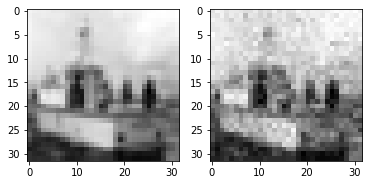

25  :  [0.83541906] 25
50  :  [0.83734834] 25
75  :  [0.8378159] 25
100  :  [0.84814346] 25
125  :  [0.84814775] 25
150  :  [0.85861796] 25
175  :  [0.8664939] 25
200  :  [0.8664939] 25
225  :  [0.8664939] 25
250  :  [0.8664939] 25
275  :  [0.8664939] 25
300  :  [0.8678205] 25
325  :  [0.8711952] 25
350  :  [0.87478536] 25
375  :  [0.87478536] 25
400  :  [0.87478536] 25
425  :  [0.87478536] 25
450  :  [0.88562375] 25
475  :  [0.887282] 25
500  :  [0.887282] 25
525  :  [0.887282] 25
550  :  [0.887282] 25
575  :  [0.88960457] 25
600  :  [0.88960457] 25
625  :  [0.8928201] 25
650  :  [0.8932445] 25
675  :  [0.8932445] 25
700  :  [0.8932445] 25
725  :  [0.8950952] 25
750  :  [0.8950952] 25
775  :  [0.8953979] 25
800  :  [0.8975353] 25
825  :  [0.8992908] 25
850  :  [0.8992908] 25
875  :  [0.8992908] 25
900  :  [0.8992908] 25
925  :  [0.8996384] 25
950  :  [0.90026355] 25
975  :  [0.90026355] 25
1000  :  [0.9004006] 25
1025  :  [0.90072274] 25
1050  :  [0.90072274] 25
1075  :  [0.90072274] 

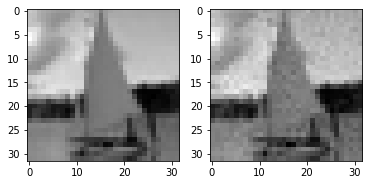

25  :  [0.80494165] 25
50  :  [0.809361] 25
75  :  [0.809361] 25
100  :  [0.809361] 25
125  :  [0.8256663] 25
150  :  [0.8256663] 25
175  :  [0.8256663] 25
200  :  [0.8362517] 25
225  :  [0.8394625] 25
250  :  [0.8394625] 25
275  :  [0.8394625] 25
300  :  [0.84338814] 25
325  :  [0.84840274] 25
350  :  [0.84840274] 25
375  :  [0.85108006] 25
400  :  [0.85221446] 25
425  :  [0.8607867] 25
450  :  [0.8639922] 25
475  :  [0.8639922] 25
500  :  [0.8639922] 25
525  :  [0.86861664] 25
550  :  [0.86861664] 25
575  :  [0.87232506] 25
600  :  [0.87322074] 25
625  :  [0.87322074] 25
650  :  [0.87322074] 25
675  :  [0.8747148] 25
700  :  [0.8803246] 25
725  :  [0.8803246] 25
750  :  [0.8803246] 25
775  :  [0.8812351] 25
800  :  [0.8819145] 25
825  :  [0.8830342] 25
850  :  [0.8832407] 25
875  :  [0.8832407] 25
900  :  [0.88421845] 25
925  :  [0.8844121] 25
950  :  [0.8844984] 25
975  :  [0.8844984] 25
Time:  137.0423641204834  seconds
Original class:  8
Prediction for normal image:  [8]
Predictio

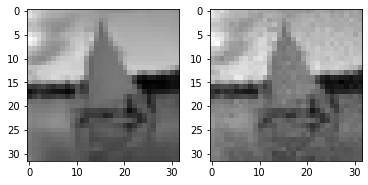

25  :  [0.66101265] 25
50  :  [0.66101265] 25
75  :  [0.66101265] 25
100  :  [0.66101265] 25
125  :  [0.66101265] 25
150  :  [0.66101265] 25
175  :  [0.66101265] 25
200  :  [0.66101265] 25
225  :  [0.66101265] 25
250  :  [0.67953086] 25
275  :  [0.67953086] 25
300  :  [0.67953086] 25
325  :  [0.6964687] 25
350  :  [0.6973938] 25
375  :  [0.7046735] 25
400  :  [0.7046735] 25
425  :  [0.7046735] 25
450  :  [0.7046735] 25
475  :  [0.7046735] 25
500  :  [0.7046735] 25
525  :  [0.7046735] 25
550  :  [0.7046735] 25
575  :  [0.7046735] 25
600  :  [0.70478815] 25
625  :  [0.70478815] 25
650  :  [0.70922625] 25
675  :  [0.70922625] 25
700  :  [0.71101236] 25
725  :  [0.71101236] 25
750  :  [0.7129241] 25
775  :  [0.7129241] 25
800  :  [0.71454656] 25
825  :  [0.71454656] 25
850  :  [0.71454656] 25
875  :  [0.72181684] 25
900  :  [0.73177886] 25
925  :  [0.73177886] 25
950  :  [0.73177886] 25
975  :  [0.73177886] 25
1000  :  [0.73177886] 25
1025  :  [0.73177886] 25
1050  :  [0.73177886] 25
1075 

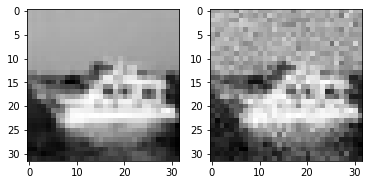

25  :  [0.86756885] 25
50  :  [0.86814713] 25
75  :  [0.8681259] 25
100  :  [0.8723769] 25
125  :  [0.8723174] 25
150  :  [0.87786496] 25
175  :  [0.8779233] 25
200  :  [0.88440907] 25
225  :  [0.88443434] 25
250  :  [0.88485265] 25
275  :  [0.89385784] 25
300  :  [0.8974351] 25
325  :  [0.89765733] 25
350  :  [0.89765733] 25
375  :  [0.89765733] 25
400  :  [0.89765733] 25
425  :  [0.89765733] 25
450  :  [0.89765733] 25
475  :  [0.89765733] 25
500  :  [0.89765733] 25
525  :  [0.89765733] 25
550  :  [0.9021333] 25
575  :  [0.90333796] 25
600  :  [0.90333796] 25
625  :  [0.904369] 25
650  :  [0.9087882] 25
675  :  [0.91180485] 25
700  :  [0.91180485] 25
725  :  [0.91418195] 25
750  :  [0.91418195] 25
775  :  [0.9147737] 25
800  :  [0.91762334] 25
Time:  112.33979439735413  seconds
Original class:  8
Prediction for normal image:  [8]
Prediction for adversarial image:  [6]


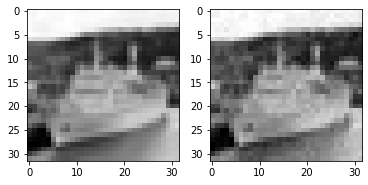

25  :  [0.8272446] 25
50  :  [0.8272446] 25
75  :  [0.83340997] 25
100  :  [0.83340997] 25
125  :  [0.83340997] 25
150  :  [0.83488727] 25
175  :  [0.83488727] 25
200  :  [0.83488727] 25
225  :  [0.83488727] 25
250  :  [0.83488727] 25
275  :  [0.83488727] 25
300  :  [0.8653756] 25
325  :  [0.867315] 25
350  :  [0.86731386] 25
375  :  [0.86731386] 25
400  :  [0.86731386] 25
425  :  [0.86731386] 25
450  :  [0.86731386] 25
475  :  [0.86731386] 25
500  :  [0.8727606] 25
525  :  [0.8727606] 25
550  :  [0.8727606] 25
575  :  [0.8727606] 25
600  :  [0.8727606] 25
625  :  [0.8836761] 25
650  :  [0.8836761] 25
675  :  [0.8836761] 25
700  :  [0.8836761] 25
725  :  [0.8836761] 25
750  :  [0.8836761] 25
775  :  [0.8836761] 25
800  :  [0.8836761] 25
825  :  [0.8836761] 25
850  :  [0.8836761] 25
875  :  [0.8836761] 25
900  :  [0.8836761] 25
925  :  [0.8838668] 25
950  :  [0.88916916] 25
975  :  [0.89691365] 25
1000  :  [0.89691365] 25
1025  :  [0.89691365] 25
1050  :  [0.9017503] 25
1075  :  [0.9069

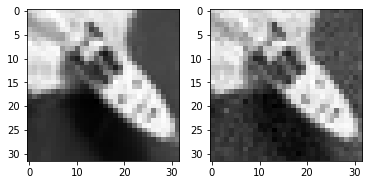

25  :  [0.6644808] 25
50  :  [0.67289054] 25
75  :  [0.6869519] 25
100  :  [0.6869519] 25
125  :  [0.6886944] 25
150  :  [0.6886944] 25
175  :  [0.690307] 25
200  :  [0.690307] 25
225  :  [0.69581765] 25
250  :  [0.71451986] 25
275  :  [0.71451986] 25
300  :  [0.71451986] 25
325  :  [0.71451986] 25
350  :  [0.71451986] 25
375  :  [0.71451986] 25
400  :  [0.71451986] 25
425  :  [0.71451986] 25
450  :  [0.71451986] 25
475  :  [0.71451986] 25
500  :  [0.71451986] 25
525  :  [0.71451986] 25
550  :  [0.71451986] 25
575  :  [0.71451986] 25
600  :  [0.71451986] 25
625  :  [0.71451986] 25
650  :  [0.71451986] 25
675  :  [0.71451986] 25
700  :  [0.71451986] 25
725  :  [0.71451986] 25
750  :  [0.71451986] 25
775  :  [0.71451986] 25
800  :  [0.71451986] 25
825  :  [0.71451986] 25
850  :  [0.71451986] 25
875  :  [0.71451986] 25
900  :  [0.71451986] 25
925  :  [0.71451986] 25
950  :  [0.71451986] 25
975  :  [0.71451986] 25
1000  :  [0.71451986] 25
1025  :  [0.71451986] 25
Time:  143.34805274009705 

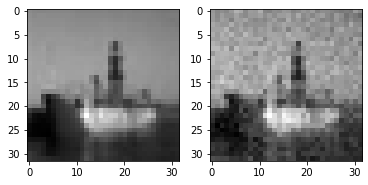

25  :  [0.850711] 25
50  :  [0.850711] 25
75  :  [0.850711] 25
100  :  [0.850711] 25
125  :  [0.850711] 25
150  :  [0.850711] 25
175  :  [0.8602084] 25
200  :  [0.8602084] 25
225  :  [0.87095374] 25
250  :  [0.87095374] 25
275  :  [0.8759099] 25
300  :  [0.8759099] 25
325  :  [0.8759099] 25
350  :  [0.8759099] 25
375  :  [0.8759099] 25
400  :  [0.87952346] 25
425  :  [0.87952346] 25
450  :  [0.88076997] 25
475  :  [0.8882054] 25
500  :  [0.89417946] 25
525  :  [0.90287197] 25
550  :  [0.90287197] 25
575  :  [0.90287197] 25
600  :  [0.90417385] 25
625  :  [0.90417385] 25
650  :  [0.9062592] 25
675  :  [0.9076956] 25
700  :  [0.90850043] 25
725  :  [0.9108173] 25
750  :  [0.9108173] 25
775  :  [0.9108173] 25
800  :  [0.91096467] 25
825  :  [0.9112921] 25
850  :  [0.91330016] 25
875  :  [0.9140986] 25
900  :  [0.91430926] 25
925  :  [0.91470397] 25
950  :  [0.91470397] 25
975  :  [0.9149512] 25
1000  :  [0.9149945] 25
Time:  142.35851454734802  seconds
Original class:  8
Prediction for no

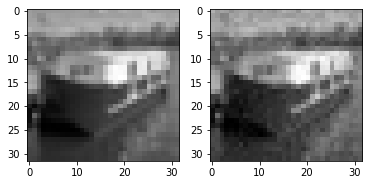

25  :  [0.8353647] 25
50  :  [0.839563] 25
75  :  [0.8395705] 25
100  :  [0.8431942] 25
125  :  [0.85360026] 25
150  :  [0.85360026] 25
175  :  [0.85360026] 25
200  :  [0.859892] 25
225  :  [0.8599268] 25
250  :  [0.8599268] 25
275  :  [0.8599268] 25
300  :  [0.8649752] 25
325  :  [0.8649752] 25
350  :  [0.87356186] 25
375  :  [0.88453966] 25
400  :  [0.8845419] 25
425  :  [0.8845419] 25
450  :  [0.8845419] 25
475  :  [0.8845419] 25
500  :  [0.8845419] 25
525  :  [0.88855535] 25
550  :  [0.89013785] 25
575  :  [0.89013785] 25
600  :  [0.8942385] 25
625  :  [0.89565456] 25
650  :  [0.89895797] 25
675  :  [0.89895797] 25
700  :  [0.89895797] 25
725  :  [0.89895797] 25
750  :  [0.8993968] 25
775  :  [0.90008223] 25
800  :  [0.90094423] 25
825  :  [0.9010482] 25
850  :  [0.90153456] 25
875  :  [0.90281963] 25
900  :  [0.90294766] 25
925  :  [0.90347135] 25
950  :  [0.90347135] 25
975  :  [0.9035114] 25
1000  :  [0.9035114] 25
1025  :  [0.9035114] 25
1050  :  [0.9037335] 25
1075  :  [0.9037

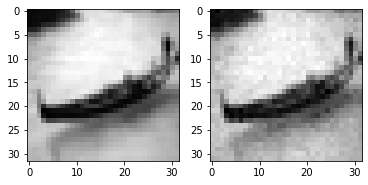

25  :  [0.70802563] 25
50  :  [0.733861] 25
75  :  [0.734927] 25
100  :  [0.734927] 25
125  :  [0.734927] 25
150  :  [0.74352837] 25
175  :  [0.74352837] 25
200  :  [0.74352837] 25
225  :  [0.74352837] 25
250  :  [0.74352837] 25
275  :  [0.74352837] 25
300  :  [0.74352837] 25
325  :  [0.74352837] 25
350  :  [0.7508081] 25
375  :  [0.75575763] 25
400  :  [0.7615166] 25
425  :  [0.7731857] 25
450  :  [0.7731857] 25
475  :  [0.7731857] 25
500  :  [0.7731857] 25
525  :  [0.7731857] 25
550  :  [0.7772425] 25
575  :  [0.7772425] 25
600  :  [0.77818996] 25
625  :  [0.77818996] 25
650  :  [0.7834387] 25
675  :  [0.7834387] 25
700  :  [0.7840147] 25
725  :  [0.7843602] 25
750  :  [0.78481615] 25
775  :  [0.7851044] 25
800  :  [0.7858949] 25
825  :  [0.7870087] 25
850  :  [0.787398] 25
875  :  [0.7876938] 25
900  :  [0.7876938] 25
925  :  [0.7880485] 25
950  :  [0.78822637] 25
975  :  [0.78823537] 25
1000  :  [0.78871953] 25
1025  :  [0.7887629] 25
1050  :  [0.7889775] 25
1075  :  [0.78912646] 2

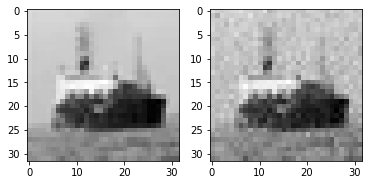

25  :  [0.822634] 25
50  :  [0.8243401] 25
75  :  [0.822634] 25
100  :  [0.8285089] 25
125  :  [0.82720304] 25
150  :  [0.82720304] 25
175  :  [0.83821684] 25
200  :  [0.83821684] 25
225  :  [0.83821684] 25
250  :  [0.8418577] 25
275  :  [0.84692705] 25
300  :  [0.8472508] 25
325  :  [0.8472508] 25
350  :  [0.8472508] 25
375  :  [0.8472508] 25
400  :  [0.8472508] 25
425  :  [0.8472508] 25
450  :  [0.8472508] 25
475  :  [0.8472508] 25
500  :  [0.8472508] 25
525  :  [0.8472508] 25
550  :  [0.8472508] 25
575  :  [0.8472508] 25
600  :  [0.8472508] 25
625  :  [0.8472508] 25
650  :  [0.8472508] 25
675  :  [0.8472508] 25
700  :  [0.8472508] 25
725  :  [0.8514229] 25
750  :  [0.8626571] 25
775  :  [0.8626671] 25
800  :  [0.8626671] 25
825  :  [0.8626671] 25
850  :  [0.8626671] 25
875  :  [0.8626671] 25
900  :  [0.8626671] 25
925  :  [0.8626671] 25
950  :  [0.8626671] 25
975  :  [0.8646883] 25
1000  :  [0.86486113] 25
1025  :  [0.8675768] 25
1050  :  [0.8699581] 25
1075  :  [0.87169266] 25
1100

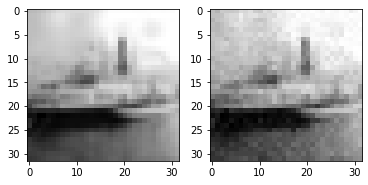

25  :  [0.82506514] 25
50  :  [0.82506514] 25
75  :  [0.8436538] 25
100  :  [0.8471257] 25
125  :  [0.8498584] 25
150  :  [0.84913445] 25
175  :  [0.84913445] 25
200  :  [0.8556806] 25
225  :  [0.8586677] 25
250  :  [0.86267555] 25
275  :  [0.87395465] 25
300  :  [0.87395465] 25
325  :  [0.87395465] 25
350  :  [0.8772476] 25
375  :  [0.8828145] 25
400  :  [0.89250875] 25
425  :  [0.89250875] 25
450  :  [0.89250875] 25
475  :  [0.8951011] 25
500  :  [0.9001986] 25
525  :  [0.9058929] 25
550  :  [0.90998805] 25
575  :  [0.91117144] 25
600  :  [0.91117144] 25
625  :  [0.91539717] 25
650  :  [0.9155221] 25
675  :  [0.9155221] 25
700  :  [0.9155221] 25
725  :  [0.9155221] 25
750  :  [0.9155545] 25
775  :  [0.91594] 25
800  :  [0.9163594] 25
825  :  [0.9163594] 25
850  :  [0.91674006] 25
875  :  [0.9167461] 25
900  :  [0.9173305] 25
925  :  [0.91733307] 25
950  :  [0.91827285] 25
975  :  [0.9183211] 25
1000  :  [0.9187322] 25
1025  :  [0.9188256] 25
1050  :  [0.91923726] 25
Time:  148.536887

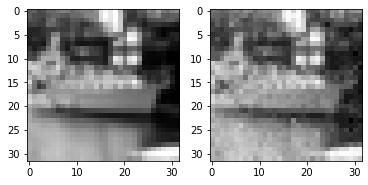

25  :  [0.6015497] 25
50  :  [0.6015497] 25
75  :  [0.6015497] 25
100  :  [0.6015497] 25
125  :  [0.6015497] 25
150  :  [0.6024002] 25
175  :  [0.6024002] 25
200  :  [0.6024002] 25
225  :  [0.61007404] 25
250  :  [0.61137104] 25
275  :  [0.61137104] 25
300  :  [0.61137104] 25
325  :  [0.63249594] 25
350  :  [0.63249594] 25
375  :  [0.63249594] 25
400  :  [0.63249594] 25
425  :  [0.63249594] 25
450  :  [0.63613147] 25
475  :  [0.6463865] 25
500  :  [0.6463865] 25
525  :  [0.64663184] 25
550  :  [0.64663184] 25
575  :  [0.66337883] 25
600  :  [0.66337883] 25
625  :  [0.66337883] 25
650  :  [0.66337883] 25
675  :  [0.66337883] 25
700  :  [0.66337883] 25
725  :  [0.66337883] 25
750  :  [0.66337883] 25
775  :  [0.66337883] 25
800  :  [0.6692728] 25
825  :  [0.6721976] 25
850  :  [0.6721976] 25
875  :  [0.67262214] 25
900  :  [0.6855571] 25
925  :  [0.6855571] 25
950  :  [0.6855571] 25
975  :  [0.6857627] 25
1000  :  [0.6857627] 25
1025  :  [0.6857627] 25
1050  :  [0.68600804] 25
1075  :  [0

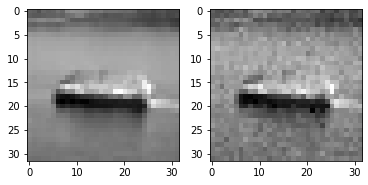

25  :  [0.9182705] 25
50  :  [0.9244317] 25
75  :  [0.9251222] 25
100  :  [0.9251222] 25
125  :  [0.9251222] 25
150  :  [0.9251222] 25
175  :  [0.9251222] 25
200  :  [0.9271054] 25
225  :  [0.926131] 25
250  :  [0.9315531] 25
275  :  [0.93299365] 25
300  :  [0.9328649] 25
325  :  [0.9328649] 25
350  :  [0.9375981] 25
375  :  [0.9375981] 25
400  :  [0.9375981] 25
425  :  [0.9375981] 25
450  :  [0.94612324] 25
475  :  [0.94612324] 25
500  :  [0.94612324] 25
525  :  [0.946836] 25
550  :  [0.946836] 25
575  :  [0.9489578] 25
600  :  [0.9489578] 25
625  :  [0.94922143] 25
650  :  [0.9509176] 25
675  :  [0.9513056] 25
700  :  [0.95355076] 25
725  :  [0.95355076] 25
750  :  [0.9545523] 25
775  :  [0.9545523] 25
800  :  [0.9570382] 25
Time:  110.80626249313354  seconds
Original class:  9
Prediction for normal image:  [9]
Prediction for adversarial image:  [6]


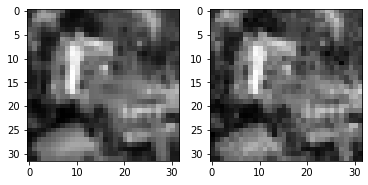

25  :  [0.85671234] 25
50  :  [0.85671234] 25
75  :  [0.85671234] 25
100  :  [0.87420934] 25
125  :  [0.8767024] 25
150  :  [0.87574774] 25
175  :  [0.87574774] 25
200  :  [0.87574774] 25
225  :  [0.8850328] 25
250  :  [0.88520676] 25
275  :  [0.88520676] 25
300  :  [0.88520676] 25
325  :  [0.8891729] 25
350  :  [0.8893773] 25
375  :  [0.8893773] 25
400  :  [0.9003047] 25
425  :  [0.900317] 25
450  :  [0.900317] 25
475  :  [0.900317] 25
500  :  [0.9059417] 25
525  :  [0.91712564] 25
550  :  [0.920678] 25
575  :  [0.9235847] 25
600  :  [0.9267781] 25
625  :  [0.92708457] 25
650  :  [0.92745745] 25
675  :  [0.92761225] 25
700  :  [0.92761225] 25
725  :  [0.9302822] 25
750  :  [0.9302822] 25
775  :  [0.9302822] 25
800  :  [0.93103373] 25
825  :  [0.9317369] 25
850  :  [0.9319116] 25
875  :  [0.9323823] 25
900  :  [0.93379766] 25
925  :  [0.93459165] 25
950  :  [0.9355886] 25
975  :  [0.9355886] 25
1000  :  [0.9355886] 25
1025  :  [0.93590236] 25
1050  :  [0.9363084] 25
1075  :  [0.9367499

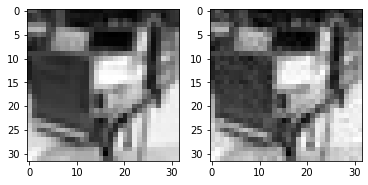

25  :  [0.82521564] 25
50  :  [0.82521564] 25
75  :  [0.8251306] 25
100  :  [0.8251306] 25
125  :  [0.8251306] 25
150  :  [0.8251306] 25
175  :  [0.8251306] 25
200  :  [0.8251306] 25
225  :  [0.8251306] 25
250  :  [0.8251306] 25
275  :  [0.8251306] 25
300  :  [0.8251306] 25
325  :  [0.8251306] 25
350  :  [0.8251306] 25
375  :  [0.8251306] 25
400  :  [0.8251306] 25
425  :  [0.8251306] 25
450  :  [0.8251306] 25
475  :  [0.8251306] 25
500  :  [0.8251306] 25
525  :  [0.8251306] 25
550  :  [0.8251306] 25
575  :  [0.8251306] 25
600  :  [0.8251306] 25
625  :  [0.8251306] 25
650  :  [0.8251306] 25
675  :  [0.8251306] 25
700  :  [0.8251306] 25
725  :  [0.8251306] 25
750  :  [0.8251306] 25
775  :  [0.82541025] 25
800  :  [0.82541025] 25
Time:  113.71007800102234  seconds
Original class:  9
Prediction for normal image:  [9]
Prediction for adversarial image:  [6]


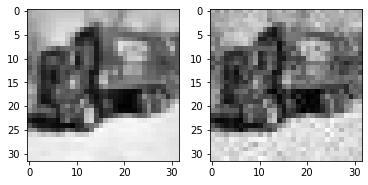

25  :  [0.80366075] 25
50  :  [0.80366075] 25
75  :  [0.80366075] 25
100  :  [0.80366075] 25
125  :  [0.80366075] 25
150  :  [0.80366075] 25
175  :  [0.80366075] 25
200  :  [0.80366075] 25
225  :  [0.80366075] 25
250  :  [0.80366075] 25
275  :  [0.80366075] 25
300  :  [0.80366075] 25
325  :  [0.80366075] 25
350  :  [0.80366075] 25
375  :  [0.80366075] 25
400  :  [0.80366075] 25
425  :  [0.80366075] 25
450  :  [0.80366075] 25
475  :  [0.80366075] 25
500  :  [0.8079481] 25
525  :  [0.8079481] 25
550  :  [0.807974] 25
575  :  [0.8165327] 25
600  :  [0.8165327] 25
625  :  [0.8165327] 25
650  :  [0.8165327] 25
675  :  [0.8174685] 25
700  :  [0.8174685] 25
725  :  [0.8174685] 25
750  :  [0.81762433] 25
775  :  [0.8184091] 25
800  :  [0.8184982] 25
Time:  118.48514533042908  seconds
Original class:  9
Prediction for normal image:  [9]
Prediction for adversarial image:  [2]


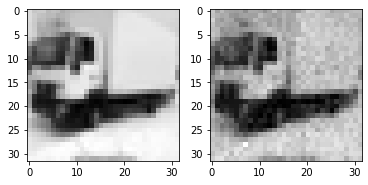

25  :  [0.7571673] 25
50  :  [0.7721484] 25
75  :  [0.7721484] 25
100  :  [0.7721484] 25
125  :  [0.7721484] 25
150  :  [0.7721484] 25
175  :  [0.7721484] 25
200  :  [0.78718793] 25
225  :  [0.7858134] 25
250  :  [0.7858134] 25
275  :  [0.7858134] 25
300  :  [0.7858134] 25
325  :  [0.7858134] 25
350  :  [0.7858134] 25
375  :  [0.7858134] 25
400  :  [0.7858134] 25
425  :  [0.7858134] 25
450  :  [0.7858134] 25
475  :  [0.7858134] 25
500  :  [0.7858134] 25
525  :  [0.7858134] 25
550  :  [0.7858134] 25
575  :  [0.7858134] 25
600  :  [0.7858134] 25
625  :  [0.7858134] 25
650  :  [0.7992424] 25
675  :  [0.8039193] 25
700  :  [0.8039193] 25
725  :  [0.8039193] 25
750  :  [0.8058835] 25
775  :  [0.8059052] 25
800  :  [0.80600023] 25
825  :  [0.8080162] 25
850  :  [0.8125547] 25
875  :  [0.81255376] 25
900  :  [0.8128146] 25
925  :  [0.81317884] 25
950  :  [0.8137735] 25
975  :  [0.81585324] 25
1000  :  [0.8171425] 25
1025  :  [0.8178128] 25
1050  :  [0.8191552] 25
1075  :  [0.819631] 25
1100  

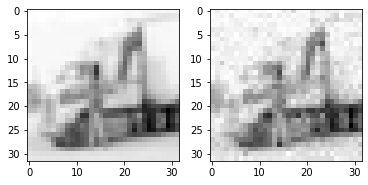

25  :  [0.756603] 25
50  :  [0.75665534] 25
75  :  [0.7765955] 25
100  :  [0.7765955] 25
125  :  [0.7765955] 25
150  :  [0.7765955] 25
175  :  [0.7765955] 25
200  :  [0.7765955] 25
225  :  [0.7765955] 25
250  :  [0.7765955] 25
275  :  [0.7765955] 25
300  :  [0.7765955] 25
325  :  [0.7765955] 25
350  :  [0.7765955] 25
375  :  [0.7765955] 25
400  :  [0.7765955] 25
425  :  [0.7765955] 25
450  :  [0.7765955] 25
475  :  [0.7765955] 25
500  :  [0.7765955] 25
525  :  [0.7765955] 25
550  :  [0.78358805] 25
575  :  [0.78358805] 25
600  :  [0.78358805] 25
625  :  [0.78384554] 25
650  :  [0.79383045] 25
675  :  [0.8015713] 25
700  :  [0.8015713] 25
725  :  [0.80229783] 25
750  :  [0.80415094] 25
775  :  [0.80440533] 25
800  :  [0.80440533] 25
825  :  [0.80496335] 25
850  :  [0.8053059] 25
Time:  124.58960509300232  seconds
Original class:  9
Prediction for normal image:  [9]
Prediction for adversarial image:  [6]


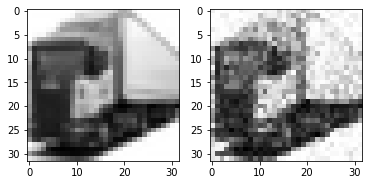

25  :  [0.8030906] 25
50  :  [0.8030906] 25
75  :  [0.80374444] 25
100  :  [0.80374444] 25
125  :  [0.8122941] 25
150  :  [0.8112923] 25
175  :  [0.81716114] 25
200  :  [0.8411579] 25
225  :  [0.84122944] 25
250  :  [0.84122944] 25
275  :  [0.84122944] 25
300  :  [0.85006285] 25
325  :  [0.85006285] 25
350  :  [0.85006285] 25
375  :  [0.85006285] 25
400  :  [0.85006285] 25
425  :  [0.85076195] 25
450  :  [0.85076195] 25
475  :  [0.85076195] 25
500  :  [0.85076195] 25
525  :  [0.85420895] 25
550  :  [0.85420895] 25
575  :  [0.85420895] 25
600  :  [0.8653697] 25
625  :  [0.8653697] 25
650  :  [0.8653697] 25
675  :  [0.8653697] 25
700  :  [0.8653697] 25
725  :  [0.8653697] 25
750  :  [0.8653697] 25
775  :  [0.8653697] 25
800  :  [0.8653697] 25
825  :  [0.8653697] 25
850  :  [0.8653697] 25
875  :  [0.87076795] 25
900  :  [0.87076795] 25
925  :  [0.87076795] 25
950  :  [0.87076795] 25
975  :  [0.87106] 25
1000  :  [0.874791] 25
1025  :  [0.87578624] 25
1050  :  [0.87578624] 25
1075  :  [0.8

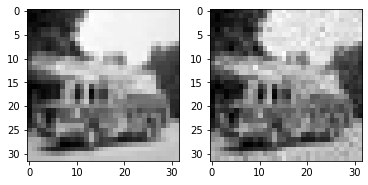

25  :  [0.92142516] 25
50  :  [0.92142516] 25
75  :  [0.92142516] 25
100  :  [0.92142516] 25
125  :  [0.92142516] 25
150  :  [0.92142516] 25
175  :  [0.92142516] 25
200  :  [0.92142516] 25
225  :  [0.92142516] 25
250  :  [0.92142516] 25
275  :  [0.92142516] 25
300  :  [0.92142516] 25
325  :  [0.92142516] 25
350  :  [0.92142516] 25
375  :  [0.92142516] 25
400  :  [0.92548] 25
425  :  [0.92548] 25
450  :  [0.92548] 25
475  :  [0.92548] 25
500  :  [0.92548] 25
525  :  [0.9315749] 25
550  :  [0.9315749] 25
575  :  [0.9315749] 25
600  :  [0.9315749] 25
625  :  [0.9316971] 25
650  :  [0.9327214] 25
675  :  [0.9327214] 25
700  :  [0.9377352] 25
725  :  [0.9377352] 25
750  :  [0.9377352] 25
775  :  [0.93933076] 25
800  :  [0.93974584] 25
Time:  121.25594639778137  seconds
Original class:  9
Prediction for normal image:  [9]
Prediction for adversarial image:  [6]


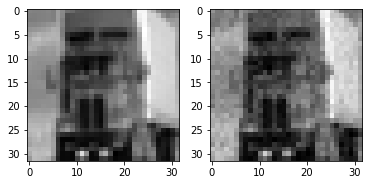

25  :  [0.8207933] 25
50  :  [0.83052695] 25
75  :  [0.8369244] 25
100  :  [0.87046254] 25
125  :  [0.8694525] 25
150  :  [0.8694525] 25
175  :  [0.8694525] 25
200  :  [0.8694525] 25
225  :  [0.8694525] 25
250  :  [0.89598143] 25
275  :  [0.8959236] 25
300  :  [0.8959236] 25
325  :  [0.8959236] 25
350  :  [0.8959236] 25
375  :  [0.8959236] 25
400  :  [0.8959236] 25
425  :  [0.9012546] 25
450  :  [0.9012546] 25
475  :  [0.9012546] 25
500  :  [0.9012546] 25
525  :  [0.90456957] 25
550  :  [0.90456957] 25
575  :  [0.9060566] 25
600  :  [0.9060566] 25
625  :  [0.906604] 25
650  :  [0.906604] 25
675  :  [0.90677077] 25
700  :  [0.90753984] 25
725  :  [0.90926903] 25
750  :  [0.9096569] 25
775  :  [0.90989256] 25
800  :  [0.9101414] 25
825  :  [0.9101414] 25
850  :  [0.91031367] 25
875  :  [0.9106943] 25
900  :  [0.91081977] 25
925  :  [0.91082835] 25
950  :  [0.9108821] 25
975  :  [0.9109628] 25
1000  :  [0.910988] 25
1025  :  [0.9110458] 25
Time:  148.99760484695435  seconds
Original class

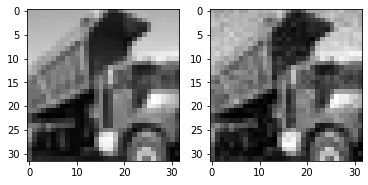

25  :  [0.8828746] 25
50  :  [0.8828746] 25
75  :  [0.8869711] 25
100  :  [0.8869711] 25
125  :  [0.8869711] 25
150  :  [0.8874495] 25
175  :  [0.8879361] 25
200  :  [0.8898301] 25
225  :  [0.89273906] 25
250  :  [0.8927744] 25
275  :  [0.8965499] 25
300  :  [0.8965499] 25
325  :  [0.897665] 25
350  :  [0.8994437] 25
375  :  [0.90113086] 25
400  :  [0.90175295] 25
425  :  [0.90624154] 25
450  :  [0.90623873] 25
475  :  [0.90623873] 25
500  :  [0.90892327] 25
525  :  [0.9104171] 25
550  :  [0.910689] 25
575  :  [0.91366446] 25
600  :  [0.91821724] 25
625  :  [0.91821724] 25
650  :  [0.91821724] 25
675  :  [0.91821724] 25
700  :  [0.91821724] 25
725  :  [0.9184127] 25
750  :  [0.9225834] 25
775  :  [0.9225788] 25
800  :  [0.92457193] 25
Time:  115.67928385734558  seconds
Original class:  9
Prediction for normal image:  [9]
Prediction for adversarial image:  [6]


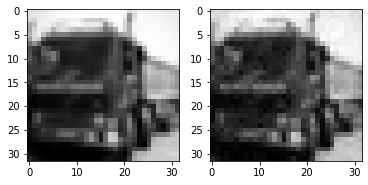

25  :  [0.86074835] 25
50  :  [0.86074835] 25
75  :  [0.86487794] 25
100  :  [0.8762642] 25
125  :  [0.8774073] 25
150  :  [0.8774073] 25
175  :  [0.8774073] 25
200  :  [0.8829625] 25
225  :  [0.8826265] 25
250  :  [0.88696885] 25
275  :  [0.8915043] 25
300  :  [0.8915043] 25
325  :  [0.89768714] 25
350  :  [0.89781547] 25
375  :  [0.89914525] 25
400  :  [0.90236616] 25
425  :  [0.90248734] 25
450  :  [0.90248734] 25
475  :  [0.90454286] 25
500  :  [0.904543] 25
525  :  [0.90619564] 25
550  :  [0.90775603] 25
575  :  [0.91063607] 25
600  :  [0.9165395] 25
625  :  [0.9165395] 25
650  :  [0.9165395] 25
675  :  [0.9181126] 25
700  :  [0.9181289] 25
725  :  [0.92009985] 25
750  :  [0.92328227] 25
775  :  [0.92544556] 25
800  :  [0.92544556] 25
825  :  [0.92563045] 25
850  :  [0.92563045] 25
875  :  [0.92563045] 25
Time:  127.71655607223511  seconds
Original class:  9
Prediction for normal image:  [9]
Prediction for adversarial image:  [6]


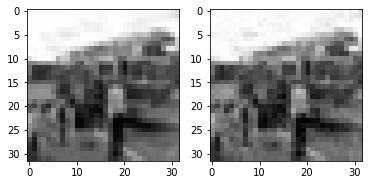

25  :  [0.8237533] 25
50  :  [0.8368629] 25
75  :  [0.8372239] 25
100  :  [0.8372239] 25
125  :  [0.85092515] 25
150  :  [0.85092515] 25
175  :  [0.85197866] 25
200  :  [0.85197866] 25
225  :  [0.85197866] 25
250  :  [0.8613937] 25
275  :  [0.8613937] 25
300  :  [0.8613937] 25
325  :  [0.8616787] 25
350  :  [0.8637698] 25
375  :  [0.8646027] 25
400  :  [0.8696118] 25
425  :  [0.86994946] 25
450  :  [0.8744464] 25
475  :  [0.8744464] 25
500  :  [0.87546164] 25
525  :  [0.87615275] 25
550  :  [0.87865746] 25
575  :  [0.87865746] 25
600  :  [0.88041055] 25
625  :  [0.88041055] 25
650  :  [0.88217974] 25
675  :  [0.88217974] 25
700  :  [0.8826388] 25
725  :  [0.8841895] 25
750  :  [0.8841895] 25
775  :  [0.8841895] 25
800  :  [0.8864754] 25
825  :  [0.8871025] 25
850  :  [0.8889637] 25
875  :  [0.8895317] 25
900  :  [0.8898026] 25
Time:  130.0693416595459  seconds
Original class:  9
Prediction for normal image:  [9]
Prediction for adversarial image:  [6]


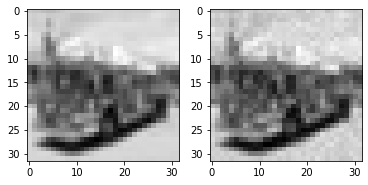

25  :  [0.85192794] 25
50  :  [0.85192794] 25
75  :  [0.85192794] 25
100  :  [0.85192794] 25
125  :  [0.85439277] 25
150  :  [0.8573803] 25
175  :  [0.85693014] 25
200  :  [0.85693014] 25
225  :  [0.8590734] 25
250  :  [0.8604531] 25
275  :  [0.8663441] 25
300  :  [0.8701612] 25
325  :  [0.8694741] 25
350  :  [0.8694741] 25
375  :  [0.870049] 25
400  :  [0.87231064] 25
425  :  [0.8723239] 25
450  :  [0.87570393] 25
475  :  [0.87604713] 25
500  :  [0.87849665] 25
525  :  [0.87850904] 25
550  :  [0.88225174] 25
575  :  [0.88225174] 25
600  :  [0.8839799] 25
625  :  [0.8839799] 25
650  :  [0.8843297] 25
675  :  [0.8874506] 25
700  :  [0.8874506] 25
725  :  [0.8902402] 25
750  :  [0.8902402] 25
775  :  [0.8902402] 25
800  :  [0.89097846] 25
Time:  119.19678831100464  seconds
Original class:  9
Prediction for normal image:  [9]
Prediction for adversarial image:  [6]


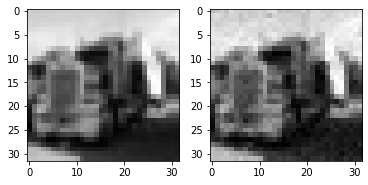

25  :  [0.88262254] 25
50  :  [0.88262254] 25
75  :  [0.8827051] 25
100  :  [0.8913851] 25
125  :  [0.8913851] 25
150  :  [0.8926259] 25
175  :  [0.89890754] 25
200  :  [0.8990985] 25
225  :  [0.9001113] 25
250  :  [0.90017974] 25
275  :  [0.91270924] 25
300  :  [0.91270924] 25
325  :  [0.91270924] 25
350  :  [0.91307366] 25
375  :  [0.9131714] 25
400  :  [0.9131714] 25
425  :  [0.91345286] 25
450  :  [0.91345286] 25
475  :  [0.91345286] 25
500  :  [0.91345286] 25
525  :  [0.9173434] 25
550  :  [0.9173434] 25
575  :  [0.9173434] 25
600  :  [0.92045164] 25
625  :  [0.92045164] 25
650  :  [0.92045164] 25
675  :  [0.92045164] 25
700  :  [0.92152566] 25
725  :  [0.92175305] 25
750  :  [0.92175305] 25
775  :  [0.9223858] 25
800  :  [0.92447627] 25
825  :  [0.9246999] 25
850  :  [0.9246999] 25
875  :  [0.9281085] 25
900  :  [0.9281085] 25
925  :  [0.9281085] 25
950  :  [0.9281085] 25
975  :  [0.9319891] 25
1000  :  [0.9319891] 25
1025  :  [0.9319891] 25
1050  :  [0.9319891] 25
Time:  149.562

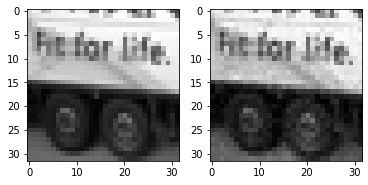

In [21]:
de_npc = DE_NPC(param_dict)
times = []
nfes = []
psnrs = []
predicted_classes = []
for adv_ind in range(adversarial.shape[0]):
  de_npc.change_input(adversarial[adv_ind].reshape((32*32,1)),adversarial_y[adv_ind],32*32)
  timed, nfed = de_npc.execute(model)
  times.append(timed)
  nfes.append(nfed)
## increasing coefficient of the first term in fitness function and
## increasing the standard deviation of the noise increases the chance
## to find an adversarial example but it decreases the image quality
## of the adversarial example found
## also this algorithm can discard the best individual in the next generation
## to prevent this we can put it to population[0] after shuffling
  adv = np.clip(de_npc.X_best, 0, 255)
  psnrs.append(PSNR(adversarial[adv_ind],adv))
  preds_adv = model.predict(adv.reshape(1,32,32,1) / 255.0)
  predicted_classes.extend(np.argmax(preds_adv,axis=1))
  print("Original class: ",adversarial_y[adv_ind][0])
  print("Prediction for normal image: ", np.argmax(model.predict(adversarial[adv_ind].reshape(1,32,32,1) / 255.0),axis=1))
  print("Prediction for adversarial image: ",np.argmax(preds_adv,axis=1))
  fig = plt.figure()
  ax1 = fig.add_subplot(1,2,1)
  ax1.imshow(adversarial[adv_ind].reshape(32,32),cmap="gray")
  ax2 = fig.add_subplot(1,2,2)
  ax2.imshow(de_npc.X_best.reshape(32,32),cmap="gray")
  plt.show()
  adversarial[adv_ind] = de_npc.X_best.reshape((32,32,1))

airplane										
automobile										
bird										
cat										
deer										
dog										
frog										
horse										
ship										
truck

In [0]:
import pickle

In [0]:
file_ = open('adv_de_cnn_cifar_ssim', 'wb')
pickle.dump(adversarial, file_)
pickle.dump(times, file_)
pickle.dump(nfes , file_)
pickle.dump(psnrs , file_)
pickle.dump(predicted_classes, file_)
file_.close()

In [24]:
print(np.max(times))
print(np.min(times))
print(np.mean(times))
print(np.std(times))

269.8168568611145
106.02563500404358
156.20300780740897
38.461459629626745


In [25]:
print(np.max(nfes))
print(np.min(nfes))
print(np.mean(nfes))
print(np.std(nfes))

2000
800
1128.3082706766918
274.84281715577396


In [26]:
print(np.max(psnrs))
print(np.min(psnrs))
print(np.mean(psnrs))
print(np.std(psnrs))

23.52102223852754
5.489655540354686
11.00826156404951
3.017735653903357
